In [1]:
import os, gc
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from time import time, ctime

from engine_hms_trainer import (
    seed_everything, gen_non_overlap_samples, calc_entropy, evaluate_oof, get_logger, TARGETS, TARGETS_PRED, Trainer
)
from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


# Load Data

In [3]:
def eeg_from_parquet(parquet_path: str, display: bool = False) -> np.ndarray:
    """
    This function reads a parquet file and extracts the middle 50 seconds of readings. Then it fills NaN values
    with the mean value (ignoring NaNs).
    :param parquet_path: path to parquet file.
    :param display: whether to display EEG plots or not.
    :return data: np.array of shape  (time_steps, eeg_features) -> (10_000, 8)
    """
    # === Extract middle 50 seconds ===
    eeg = pd.read_parquet(parquet_path, columns=EEG_FEAT_USE)
    rows = len(eeg)
    offset = (rows - 10_000) // 2 # 50 * 200 = 10_000
    eeg = eeg.iloc[offset:offset+10_000] # middle 50 seconds, has the same amount of readings to left and right
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    # === Convert to numpy ===
    data = np.zeros((10_000, len(EEG_FEAT_USE))) # create placeholder of same shape with zeros
    for index, feature in enumerate(EEG_FEAT_USE):
        x = eeg[feature].values.astype('float32') # convert to float32
        mean = np.nanmean(x) # arithmetic mean along the specified axis, ignoring NaNs
        nan_percentage = np.isnan(x).mean() # percentage of NaN values in feature
        # === Fill nan values ===
        if nan_percentage < 1: # if some values are nan, but not all
            x = np.nan_to_num(x, nan=mean)
        else: # if all values are nan
            x[:] = 0
        data[:, index] = x
        if display: 
            if index != 0:
                offset += x.max()
            plt.plot(range(10_000), x-offset, label=feature)
            offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1].split('.')[0]
        plt.yticks([])
        plt.title(f'EEG {name}',size=16)
        plt.show()    
    return data

In [4]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [5]:
CREATE_EEGS = False
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs.npy')

if CREATE_EEGS:
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        # Save EEG to Python dictionary of numpy arrays
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=eeg_id<1)
        ALL_EEG_SIGNALS[eeg_id] = data

    np.save("./inputs/eegs.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

In [6]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:]

print("targets: ", targets.to_list())

train_csv['entropy'] = train_csv.apply(calc_entropy, axis=1, tgt_list=targets)
train_csv['total_votes'] = train_csv[targets].sum(axis=1)

hard_csv = train_csv[train_csv['entropy'] < ModelConfig.SPLIT_ENTROPY].copy().reset_index(drop=True)

train_all = gen_non_overlap_samples(train_csv, targets)
train_hard = gen_non_overlap_samples(hard_csv, targets)

print("train_all.shape = ", train_all.shape)
print("train_all nan_count: ", train_all.isnull().sum().sum())
display(train_all.head())

print(" ")

print("train_hard.shape = ", train_hard.shape)
print("train_hard nan_count: ", train_hard.isnull().sum().sum())
display(train_hard.head())

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all.shape =  (20183, 12)
train_all nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.0,0.000000,0.25,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.0,0.857143,0.00,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,642382,0.0,0.000000,0.00,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,5955,Other
3,751790,0.0,0.000000,1.00,0.000000,0.000000,0.000000,618728447,908.0,908.0,38549,GPD
4,778705,0.0,0.000000,0.00,0.000000,0.000000,1.000000,52296320,0.0,0.0,40955,Other


 
train_hard.shape =  (6187, 12)
train_hard nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


# Dataset

In [7]:
class EEGSeqDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', downsample=None):
        self.df = df
        self.config = config
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob = self.__data_generation(idx)

        if self.downsample is not None:
            X = X[::self.downsample,:]

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)
    
    def __data_generation(self, index):
        row = self.df.iloc[index]
        X = np.zeros((10_000, 8), dtype='float32')
        
        data = self.eegs[row.eeg_id]
        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        # !!! change to bandpass filter (low=5, hight=20, order=2) !!!
        X = butter_lowpass_filter(X)

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)
        else:
            y_prob = np.zeros(6, dtype='float32')

        return X, y_prob

# def pad_collate(batch, max_length=512):
#     x = [item[0] for item in batch]
#     y = [item[1] for item in batch]

#     x_tensor = torch.stack(x, dim=0).unsqueeze(0)
#     y_tensor = torch.stack(y, dim=0)

#     pad_len = (max_length - x_tensor.size(2)) // 2
#     x_pad = F.pad(x_tensor, (0, 0, pad_len, pad_len), mode='constant', value=0).squeeze(0)

#     return x_pad, y_tensor

# class CustomPatchTSMixer(nn.Module):
#     def __init__(self, in_channels=8, num_classes=6):
#         super().__init__()

#         mixer_config = PatchTSMixerConfig().from_pretrained("ibm/patchtsmixer-etth1-pretrain")
#         mixer_config.num_input_channels = in_channels
#         mixer_config.num_targets = num_classes

#         self.model = PatchTSMixerForTimeSeriesClassification(mixer_config)
    
#     def forward(self, x):
#         output = self.model(x)
#         return output.prediction_outputs


X shape: torch.Size([16, 10000, 8])
y shape: torch.Size([16, 6])


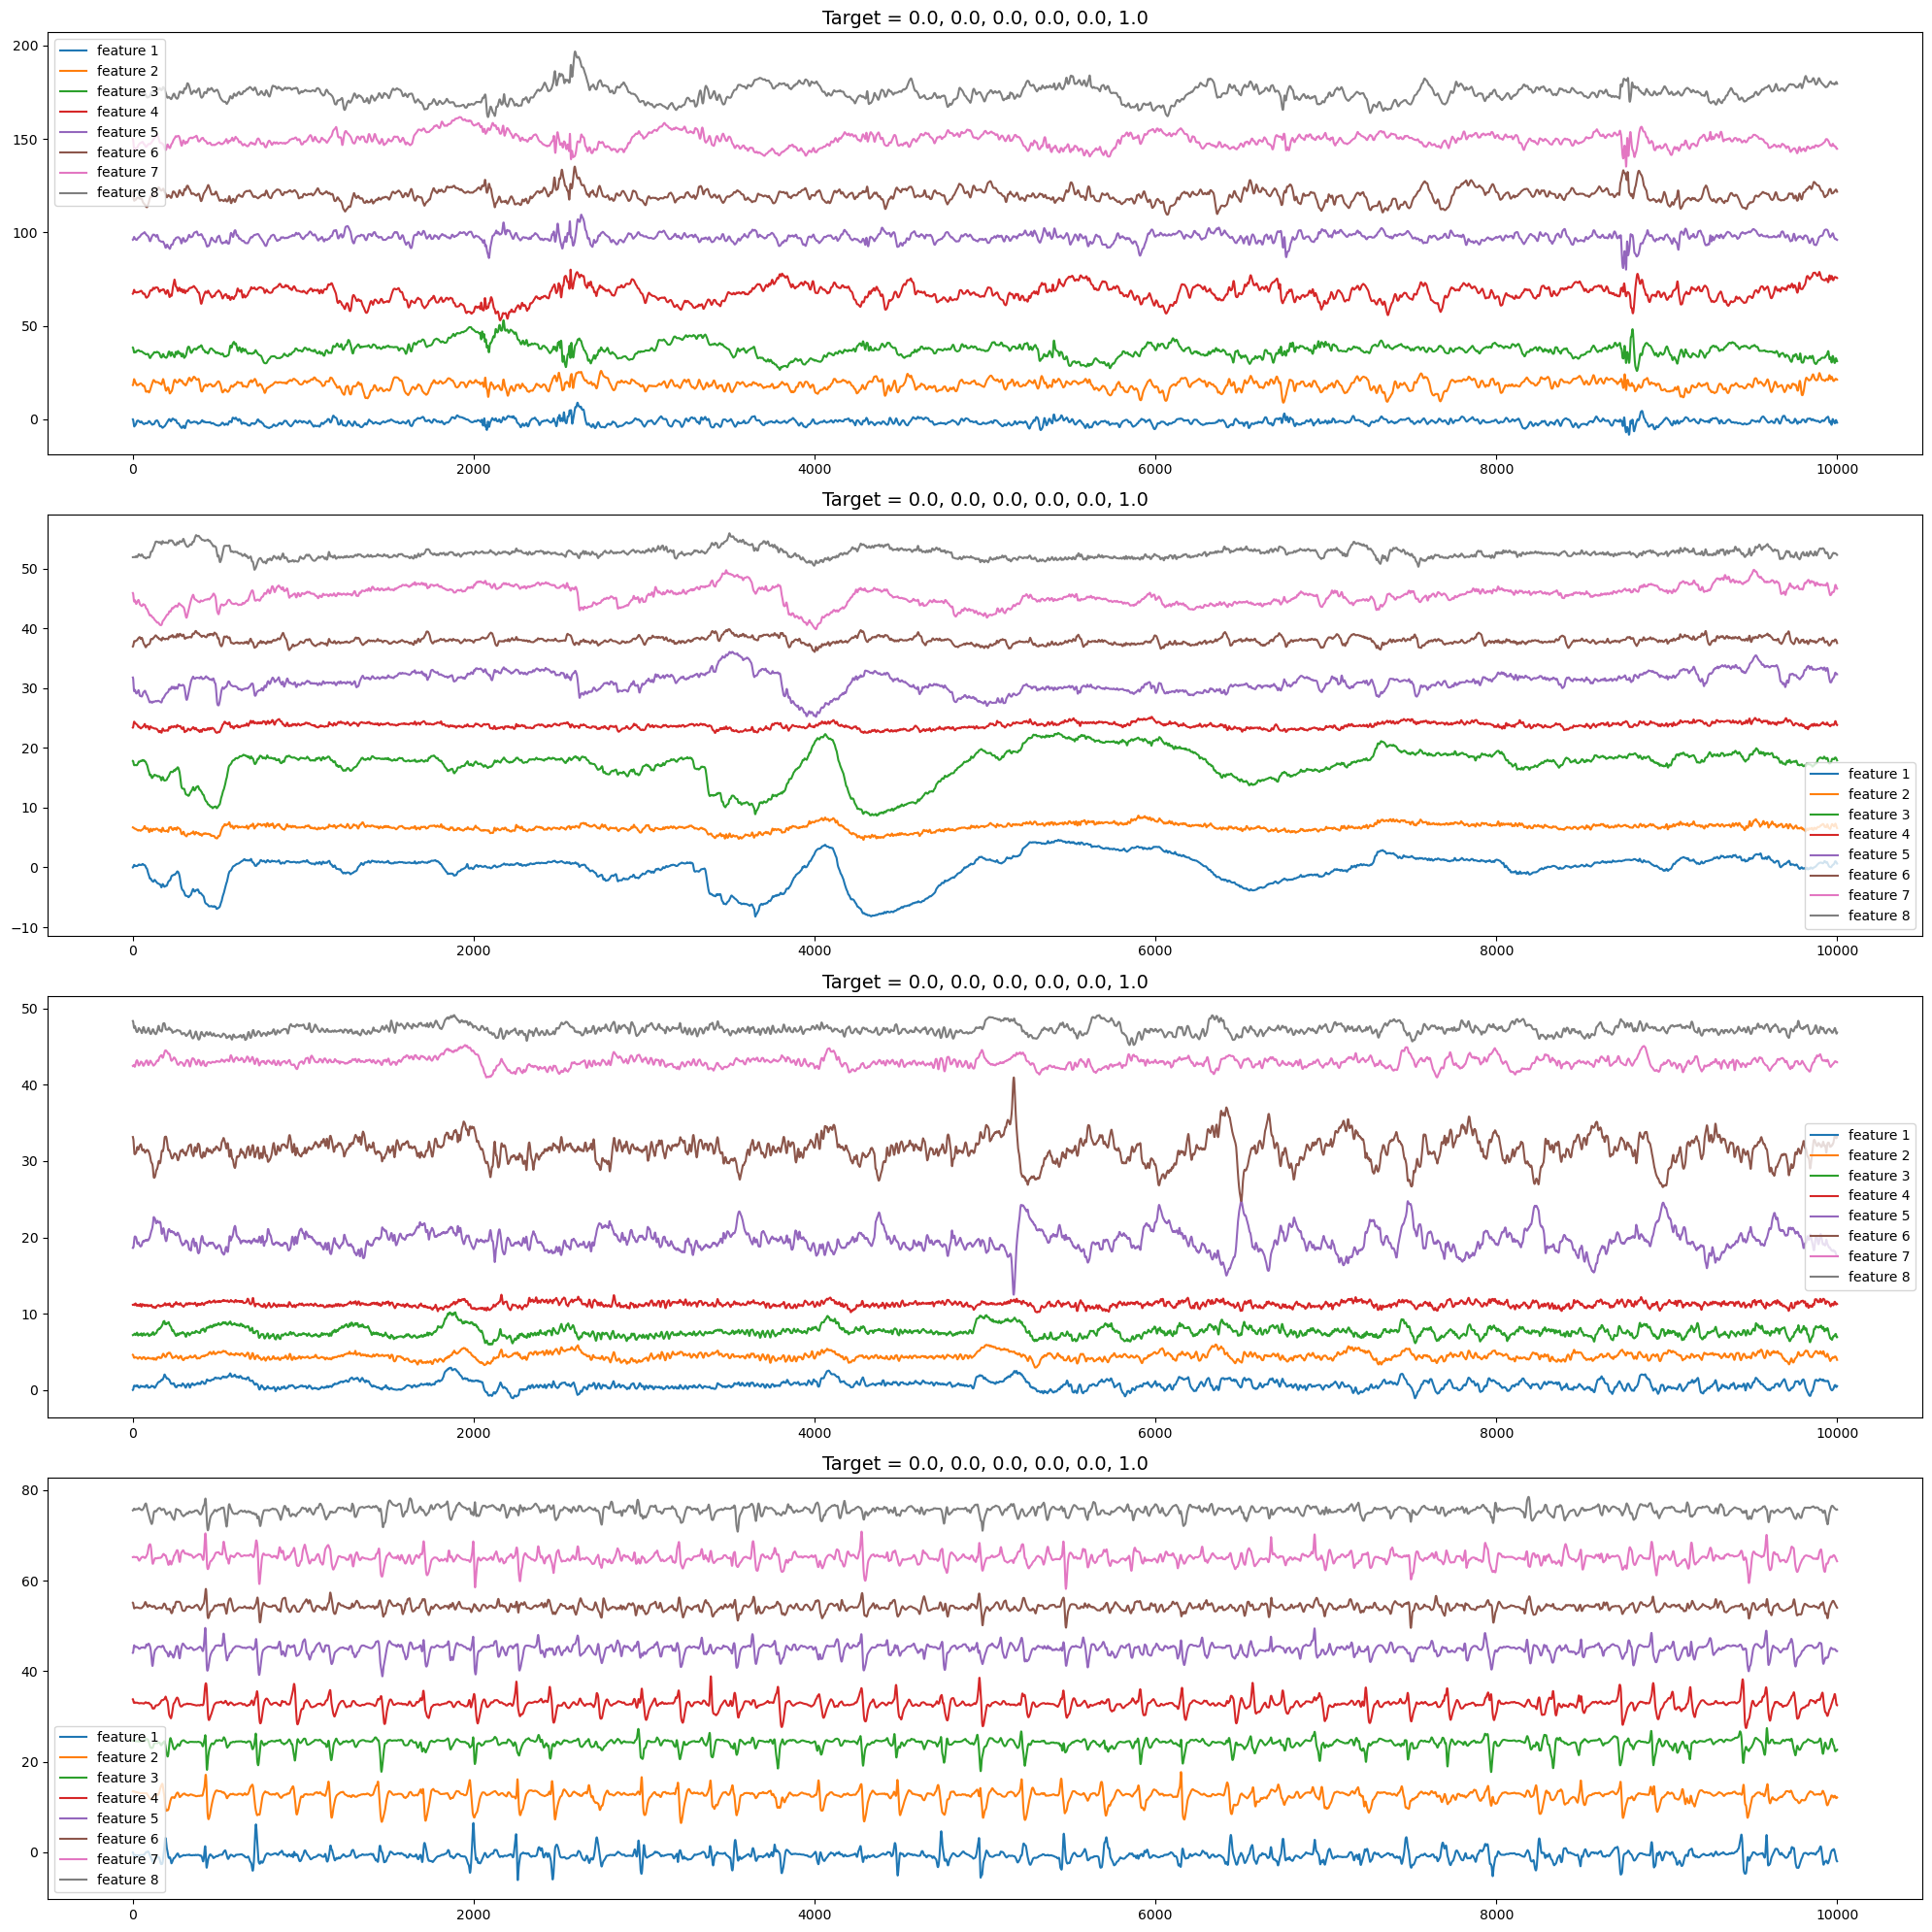

In [8]:
# visualize the dataset
train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train", downsample=None)
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

for batch in train_loader:
    X, y = batch
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    fig, axes = plt.subplots(4, 1, figsize=(20, 20))
    for item in range(4):
        offset = 0
        for col in range(X.shape[-1]):
            if col != 0:
                offset -= X[item,:,col].min()
            axes[item].plot(np.arange(X.shape[1]), X[item,:,col]+offset, label=f'feature {col+1}')
            offset += X[item,:,col].max()
        tt = f'{y[col][0]:0.1f}'
        for t in y[col][1:]:
            tt += f', {t:0.1f}'
        axes[item].set_title(f'Target = {tt}',size=14)
        axes[item].legend()
    fig.tight_layout()
    plt.show()
    break

# Model

In [9]:
class ResNet_1D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dropout=0.0):
        super(ResNet_1D_Block, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(num_features=in_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = self.downsampling(x)
        out = self.block(x)
        out += identity
        return out

class ResNetGRU(nn.Module):
    def __init__(self, kernels, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(ResNetGRU, self).__init__()
        
        self.kernels = kernels
        self.planes = 24
        self.in_channels = in_channels

        # Define the separate convolutional layers
        self.parallel_conv = self._make_parallel_conv_layers()
        # Define the ResNet part of the model
        self.resnet_part = self._make_resnet_part(fixed_kernel_size)
        # Define the GRU part of the model
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        # Define the final fully connected layer
        self.fc = nn.Linear(in_features=424, out_features=num_classes)

    def _make_parallel_conv_layers(self):
        return nn.ModuleList([
            nn.Conv1d(
                in_channels=self.in_channels, 
                out_channels=self.planes, 
                kernel_size=kernel_size,
                stride=1, 
                padding=0, 
                bias=False
            ) for kernel_size in self.kernels
        ])

    def _make_resnet_part(self, fixed_kernel_size, blocks=9):
        # prepare resnet layers
        downsampling = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        resnet_layers = [
            ResNet_1D_Block(
                in_channels=self.planes, 
                out_channels=self.planes, 
                kernel_size=fixed_kernel_size, 
                stride=1, 
                padding=fixed_kernel_size//2, 
                downsampling=downsampling)
            for _ in range(blocks)
        ]
        # return the resnet encoder
        return nn.Sequential(
            nn.BatchNorm1d(num_features=self.planes),
            nn.ReLU(inplace=False),
            nn.Conv1d(
                in_channels=self.planes, 
                out_channels=self.planes, 
                kernel_size=fixed_kernel_size, 
                stride=2, 
                padding=2, 
                bias=False
            ),
            *resnet_layers,
            nn.BatchNorm1d(num_features=self.planes),
            nn.ReLU(inplace=False),
            nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        )
    
    def forward(self, x):
        # extract features using resnet 
        x = x.permute(0, 2, 1)
        out_sep = [conv(x) for conv in self.parallel_conv]
        out = torch.cat(out_sep, dim=2)
        out = self.resnet_part(out)
        out = out.reshape(out.shape[0], -1)
        # extract features using rnn
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  
        # concatenate the features
        new_out = torch.cat([out, new_rnn_h], dim=1) 
        # total features = 424 = 24*6 + 128*2 
        # pass through the final fully connected layer
        result = self.fc(new_out)  
        
        return result

In [10]:
train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train", downsample=None)
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

model = ResNetGRU(kernels=[3,5,7,9], in_channels=8, fixed_kernel_size=5, num_classes=6)

for batch in train_loader:
    X, y = batch
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    y_pred = model(X)
    print(y_pred.shape)
    
    break

X shape: torch.Size([16, 10000, 8])
y shape: torch.Size([16, 6])
torch.Size([16, 6])


# Train

In [11]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=ModelConfig.SEED)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = EEGSeqDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train")
    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=None, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [12]:
ModelConfig.EPOCHS = 15
ModelConfig.BATCH_SIZE = 32
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.MODEL_BACKBONE = 'reset_gru'
ModelConfig.MODEL_NAME = "ResNetGRU"
ModelConfig.RESNET_GRU_KERNELS = [3, 5, 7, 9] # [3, 5, 7, 9, 11]
ModelConfig.RESNET_GRU_FIXED_KERNEL_SIZE = 5

In [13]:
logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Run Training ==================

k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)

oof_stage_1, oof_stage_2 = pd.DataFrame(), pd.DataFrame()
loss_history_1, loss_history_2 = [], []

for fold in range(k_folds):
    tik = time()

    model = ResNetGRU(
        kernels=ModelConfig.RESNET_GRU_KERNELS, 
        in_channels=8, 
        fixed_kernel_size=ModelConfig.RESNET_GRU_FIXED_KERNEL_SIZE, 
        num_classes=6
        )

    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    # STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid size {valid_folds.shape[0]} \n{'=' * 100}")
    logger.info(f"- First Stage -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

    # STAGE 2
    tik = time()
    logger.info(f"- Second Stage -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = ResNetGRU(
        kernels=ModelConfig.RESNET_GRU_KERNELS, 
        in_channels=8, 
        fixed_kernel_size=ModelConfig.RESNET_GRU_FIXED_KERNEL_SIZE, 
        num_classes=6
        )

    valid_predicts, loss_records = train_fold(
        model, fold, train_hard, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

****************************************************************************************************
Script Start: Mon Mar 25 11:57:41 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: ResNetGRU
MODEL_BACKBONE: reset_gru
BATCH_SIZE: 32
EPOCHS: 15
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: False
AUGMENTATIONS: ['h_flip', 'v_flip', 'xy_masking', 'cutmix']
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
DUAL_ENCODER_BACKBONE: tf_efficientnet_b2
MAE_PRETRAINED_WEIGHTS: facebook/vit-mae-base
MAE_HIDDEN_DROPOUT_PROB: 0.05
MAE_ATTENTION_DROPOUT_PROB: 0.05
RESNET_GRU_KERNELS: [3, 5, 7, 9]
RESNET_GRU_FIXED_KERNEL_SIZE: 5
****************************************************************************************************
Fold: 0 || Valid size 3988 
- First Stage -


Train [0]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 1 [0/506] | Train Loss: 1.4879 Grad: 161359.2188 LR: 4.0004e-06 | Elapse: 0.71s
Epoch 1 [50/506] | Train Loss: 1.4753 Grad: 92137.0391 LR: 5.0683e-06 | Elapse: 5.03s
Epoch 1 [100/506] | Train Loss: 1.4507 Grad: 291913.0625 LR: 8.1444e-06 | Elapse: 9.30s
Epoch 1 [150/506] | Train Loss: 1.4510 Grad: 139289.4688 LR: 1.3097e-05 | Elapse: 13.57s
Epoch 1 [200/506] | Train Loss: 1.4459 Grad: 159466.9375 LR: 1.9715e-05 | Elapse: 17.85s
Epoch 1 [250/506] | Train Loss: 1.4320 Grad: 121858.3438 LR: 2.7713e-05 | Elapse: 22.13s
Epoch 1 [300/506] | Train Loss: 1.4196 Grad: 80727.7109 LR: 3.6752e-05 | Elapse: 26.42s
Epoch 1 [350/506] | Train Loss: 1.4091 Grad: 124630.7969 LR: 4.6442e-05 | Elapse: 30.70s
Epoch 1 [400/506] | Train Loss: 1.3946 Grad: 94552.4453 LR: 5.6371e-05 | Elapse: 34.98s
Epoch 1 [450/506] | Train Loss: 1.3822 Grad: 102319.6641 LR: 6.6112e-05 | Elapse: 39.26s
Epoch 1 [500/506] | Train Loss: 1.3692 Grad: 66931.9062 LR: 7.5250e-05 | Elapse: 43.54s
Epoch 1 [505/506] | Train Loss:

Valid [0]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 1 [0/125] | Valid Loss: 1.2016 | Elapse: 0.10s
Epoch 1 [50/125] | Valid Loss: 1.2746 | Elapse: 4.11s
Epoch 1 [100/125] | Valid Loss: 1.2643 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3680; (valid) 1.2591 | Time: 53.99s
Best model found in epoch 1 | valid loss: 1.2591


Epoch 1 [124/125] | Valid Loss: 1.2591 | Elapse: 10.02s


Train [1]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 2 [0/506] | Train Loss: 1.3221 Grad: 82880.2656 LR: 7.6287e-05 | Elapse: 0.09s
Epoch 2 [50/506] | Train Loss: 1.2420 Grad: 108444.2344 LR: 8.4285e-05 | Elapse: 4.36s
Epoch 2 [100/506] | Train Loss: 1.2083 Grad: 336099.9688 LR: 9.0903e-05 | Elapse: 8.58s
Epoch 2 [150/506] | Train Loss: 1.2071 Grad: 105471.0625 LR: 9.5856e-05 | Elapse: 12.80s
Epoch 2 [200/506] | Train Loss: 1.2047 Grad: 119577.7969 LR: 9.8932e-05 | Elapse: 17.03s
Epoch 2 [250/506] | Train Loss: 1.1942 Grad: 137749.6875 LR: 1.0000e-04 | Elapse: 21.25s
Epoch 2 [300/506] | Train Loss: 1.1842 Grad: 110188.2188 LR: 9.9987e-05 | Elapse: 25.48s
Epoch 2 [350/506] | Train Loss: 1.1739 Grad: 129304.5312 LR: 9.9948e-05 | Elapse: 29.70s
Epoch 2 [400/506] | Train Loss: 1.1623 Grad: 116654.6797 LR: 9.9883e-05 | Elapse: 33.93s
Epoch 2 [450/506] | Train Loss: 1.1500 Grad: 128405.7344 LR: 9.9791e-05 | Elapse: 38.16s
Epoch 2 [500/506] | Train Loss: 1.1398 Grad: 132136.8594 LR: 9.9673e-05 | Elapse: 42.39s
Epoch 2 [505/506] | Train Lo

Valid [1]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 2 [0/125] | Valid Loss: 0.8563 | Elapse: 0.08s
Epoch 2 [50/125] | Valid Loss: 1.0416 | Elapse: 4.06s
Epoch 2 [100/125] | Valid Loss: 1.0475 | Elapse: 8.03s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.1385; (valid) 1.0451 | Time: 52.73s
Best model found in epoch 2 | valid loss: 1.0451


Epoch 2 [124/125] | Valid Loss: 1.0451 | Elapse: 9.92s


Train [2]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 3 [0/506] | Train Loss: 1.2136 Grad: 142550.8281 LR: 9.9657e-05 | Elapse: 0.09s
Epoch 3 [50/506] | Train Loss: 1.0183 Grad: 150915.5625 LR: 9.9509e-05 | Elapse: 4.32s
Epoch 3 [100/506] | Train Loss: 0.9940 Grad: 553488.7500 LR: 9.9335e-05 | Elapse: 8.55s
Epoch 3 [150/506] | Train Loss: 0.9936 Grad: 149022.9375 LR: 9.9136e-05 | Elapse: 12.78s
Epoch 3 [200/506] | Train Loss: 0.9894 Grad: 159068.7656 LR: 9.8910e-05 | Elapse: 17.02s
Epoch 3 [250/506] | Train Loss: 0.9793 Grad: 194804.1562 LR: 9.8658e-05 | Elapse: 21.26s
Epoch 3 [300/506] | Train Loss: 0.9719 Grad: 155274.6875 LR: 9.8381e-05 | Elapse: 25.50s
Epoch 3 [350/506] | Train Loss: 0.9653 Grad: 176990.5000 LR: 9.8078e-05 | Elapse: 29.74s
Epoch 3 [400/506] | Train Loss: 0.9589 Grad: 245289.5781 LR: 9.7749e-05 | Elapse: 33.99s
Epoch 3 [450/506] | Train Loss: 0.9492 Grad: 223452.3438 LR: 9.7396e-05 | Elapse: 38.23s
Epoch 3 [500/506] | Train Loss: 0.9440 Grad: 168532.4219 LR: 9.7017e-05 | Elapse: 42.47s
Epoch 3 [505/506] | Train L

Valid [2]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 3 [0/125] | Valid Loss: 0.7416 | Elapse: 0.08s
Epoch 3 [50/125] | Valid Loss: 0.8926 | Elapse: 4.07s
Epoch 3 [100/125] | Valid Loss: 0.9030 | Elapse: 8.06s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.9431; (valid) 0.9022 | Time: 52.85s
Best model found in epoch 3 | valid loss: 0.9022


Epoch 3 [124/125] | Valid Loss: 0.9022 | Elapse: 9.95s


Train [3]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 4 [0/506] | Train Loss: 1.0329 Grad: 195187.3438 LR: 9.6970e-05 | Elapse: 0.09s
Epoch 4 [50/506] | Train Loss: 0.8593 Grad: 220399.7344 LR: 9.6564e-05 | Elapse: 4.34s
Epoch 4 [100/506] | Train Loss: 0.8468 Grad: 428092.1562 LR: 9.6133e-05 | Elapse: 8.58s
Epoch 4 [150/506] | Train Loss: 0.8513 Grad: 217026.5625 LR: 9.5677e-05 | Elapse: 12.82s
Epoch 4 [200/506] | Train Loss: 0.8508 Grad: 207790.6094 LR: 9.5198e-05 | Elapse: 17.06s
Epoch 4 [250/506] | Train Loss: 0.8455 Grad: 271836.0312 LR: 9.4694e-05 | Elapse: 21.30s
Epoch 4 [300/506] | Train Loss: 0.8418 Grad: 205479.1562 LR: 9.4167e-05 | Elapse: 25.55s
Epoch 4 [350/506] | Train Loss: 0.8394 Grad: 210556.0781 LR: 9.3617e-05 | Elapse: 29.79s
Epoch 4 [400/506] | Train Loss: 0.8367 Grad: 267993.9375 LR: 9.3043e-05 | Elapse: 34.03s
Epoch 4 [450/506] | Train Loss: 0.8308 Grad: 295687.5312 LR: 9.2447e-05 | Elapse: 38.28s
Epoch 4 [500/506] | Train Loss: 0.8282 Grad: 275237.4375 LR: 9.1828e-05 | Elapse: 42.52s
Epoch 4 [505/506] | Train L

Valid [3]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 4 [0/125] | Valid Loss: 0.6852 | Elapse: 0.08s
Epoch 4 [50/125] | Valid Loss: 0.8088 | Elapse: 4.07s
Epoch 4 [100/125] | Valid Loss: 0.8250 | Elapse: 8.06s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8275; (valid) 0.8263 | Time: 52.90s
Best model found in epoch 4 | valid loss: 0.8263


Epoch 4 [124/125] | Valid Loss: 0.8263 | Elapse: 9.96s


Train [4]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 5 [0/506] | Train Loss: 0.8848 Grad: 273677.0312 LR: 9.1752e-05 | Elapse: 0.09s
Epoch 5 [50/506] | Train Loss: 0.7650 Grad: 248681.8750 LR: 9.1109e-05 | Elapse: 4.34s
Epoch 5 [100/506] | Train Loss: 0.7591 Grad: 493688.5625 LR: 9.0444e-05 | Elapse: 8.59s
Epoch 5 [150/506] | Train Loss: 0.7649 Grad: 307699.2812 LR: 8.9757e-05 | Elapse: 12.85s
Epoch 5 [200/506] | Train Loss: 0.7668 Grad: 268702.6875 LR: 8.9050e-05 | Elapse: 17.10s
Epoch 5 [250/506] | Train Loss: 0.7632 Grad: 304792.5625 LR: 8.8322e-05 | Elapse: 21.35s
Epoch 5 [300/506] | Train Loss: 0.7615 Grad: 254842.8906 LR: 8.7573e-05 | Elapse: 25.60s
Epoch 5 [350/506] | Train Loss: 0.7606 Grad: 255620.1562 LR: 8.6805e-05 | Elapse: 29.85s
Epoch 5 [400/506] | Train Loss: 0.7601 Grad: 322581.5625 LR: 8.6017e-05 | Elapse: 34.10s
Epoch 5 [450/506] | Train Loss: 0.7563 Grad: 350056.2812 LR: 8.5211e-05 | Elapse: 38.35s
Epoch 5 [500/506] | Train Loss: 0.7552 Grad: 332022.7812 LR: 8.4385e-05 | Elapse: 42.61s
Epoch 5 [505/506] | Train L

Valid [4]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 5 [0/125] | Valid Loss: 0.6334 | Elapse: 0.08s
Epoch 5 [50/125] | Valid Loss: 0.7430 | Elapse: 4.09s
Epoch 5 [100/125] | Valid Loss: 0.7676 | Elapse: 8.09s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.7546; (valid) 0.7704 | Time: 53.03s
Best model found in epoch 5 | valid loss: 0.7704


Epoch 5 [124/125] | Valid Loss: 0.7704 | Elapse: 9.99s


Train [5]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 6 [0/506] | Train Loss: 0.8093 Grad: 331720.3750 LR: 8.4285e-05 | Elapse: 0.09s
Epoch 6 [50/506] | Train Loss: 0.7068 Grad: 323372.5000 LR: 8.3439e-05 | Elapse: 4.34s
Epoch 6 [100/506] | Train Loss: 0.7030 Grad: 427814.6875 LR: 8.2576e-05 | Elapse: 8.59s
Epoch 6 [150/506] | Train Loss: 0.7094 Grad: 363511.9062 LR: 8.1695e-05 | Elapse: 12.85s
Epoch 6 [200/506] | Train Loss: 0.7130 Grad: 310076.5312 LR: 8.0798e-05 | Elapse: 17.10s
Epoch 6 [250/506] | Train Loss: 0.7112 Grad: 335293.0938 LR: 7.9884e-05 | Elapse: 21.35s
Epoch 6 [300/506] | Train Loss: 0.7103 Grad: 299943.9688 LR: 7.8955e-05 | Elapse: 25.60s
Epoch 6 [350/506] | Train Loss: 0.7101 Grad: 318222.1250 LR: 7.8010e-05 | Elapse: 29.86s
Epoch 6 [400/506] | Train Loss: 0.7113 Grad: 419148.9062 LR: 7.7051e-05 | Elapse: 34.11s
Epoch 6 [450/506] | Train Loss: 0.7083 Grad: 374984.0938 LR: 7.6077e-05 | Elapse: 38.36s
Epoch 6 [500/506] | Train Loss: 0.7079 Grad: 389450.4688 LR: 7.5090e-05 | Elapse: 42.61s
Epoch 6 [505/506] | Train L

Valid [5]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 6 [0/125] | Valid Loss: 0.6032 | Elapse: 0.08s
Epoch 6 [50/125] | Valid Loss: 0.7201 | Elapse: 4.09s
Epoch 6 [100/125] | Valid Loss: 0.7469 | Elapse: 8.09s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7075; (valid) 0.7498 | Time: 53.03s
Best model found in epoch 6 | valid loss: 0.7498


Epoch 6 [124/125] | Valid Loss: 0.7498 | Elapse: 9.99s


Train [6]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 7 [0/506] | Train Loss: 0.7745 Grad: 415055.5625 LR: 7.4970e-05 | Elapse: 0.09s
Epoch 7 [50/506] | Train Loss: 0.6669 Grad: 356678.5312 LR: 7.3968e-05 | Elapse: 4.41s
Epoch 7 [100/506] | Train Loss: 0.6648 Grad: 373938.2500 LR: 7.2953e-05 | Elapse: 8.73s
Epoch 7 [150/506] | Train Loss: 0.6717 Grad: 383096.1562 LR: 7.1926e-05 | Elapse: 13.05s
Epoch 7 [200/506] | Train Loss: 0.6766 Grad: 368708.9375 LR: 7.0887e-05 | Elapse: 17.37s
Epoch 7 [250/506] | Train Loss: 0.6756 Grad: 379877.9375 LR: 6.9837e-05 | Elapse: 21.69s
Epoch 7 [300/506] | Train Loss: 0.6743 Grad: 326196.4062 LR: 6.8777e-05 | Elapse: 26.02s
Epoch 7 [350/506] | Train Loss: 0.6745 Grad: 375232.9688 LR: 6.7707e-05 | Elapse: 30.33s
Epoch 7 [400/506] | Train Loss: 0.6764 Grad: 448008.9062 LR: 6.6627e-05 | Elapse: 34.65s
Epoch 7 [450/506] | Train Loss: 0.6744 Grad: 383835.8750 LR: 6.5539e-05 | Elapse: 38.98s
Epoch 7 [500/506] | Train Loss: 0.6741 Grad: 436337.3750 LR: 6.4442e-05 | Elapse: 43.31s
Epoch 7 [505/506] | Train L

Valid [6]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 7 [0/125] | Valid Loss: 0.5875 | Elapse: 0.09s
Epoch 7 [50/125] | Valid Loss: 0.7020 | Elapse: 4.15s
Epoch 7 [100/125] | Valid Loss: 0.7307 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6738; (valid) 0.7353 | Time: 53.89s
Best model found in epoch 7 | valid loss: 0.7353


Epoch 7 [124/125] | Valid Loss: 0.7353 | Elapse: 10.14s


Train [7]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 8 [0/506] | Train Loss: 0.7668 Grad: 474068.3125 LR: 6.4310e-05 | Elapse: 0.09s
Epoch 8 [50/506] | Train Loss: 0.6352 Grad: 409446.0625 LR: 6.3205e-05 | Elapse: 4.42s
Epoch 8 [100/506] | Train Loss: 0.6353 Grad: 399678.2812 LR: 6.2093e-05 | Elapse: 8.74s
Epoch 8 [150/506] | Train Loss: 0.6416 Grad: 419428.4062 LR: 6.0975e-05 | Elapse: 13.06s
Epoch 8 [200/506] | Train Loss: 0.6468 Grad: 413842.5625 LR: 5.9851e-05 | Elapse: 17.38s
Epoch 8 [250/506] | Train Loss: 0.6468 Grad: 432809.8438 LR: 5.8722e-05 | Elapse: 21.71s
Epoch 8 [300/506] | Train Loss: 0.6457 Grad: 377807.3750 LR: 5.7588e-05 | Elapse: 26.03s
Epoch 8 [350/506] | Train Loss: 0.6458 Grad: 431718.1875 LR: 5.6450e-05 | Elapse: 30.36s
Epoch 8 [400/506] | Train Loss: 0.6482 Grad: 461817.2500 LR: 5.5308e-05 | Elapse: 34.69s
Epoch 8 [450/506] | Train Loss: 0.6470 Grad: 432937.6250 LR: 5.4164e-05 | Elapse: 39.01s
Epoch 8 [500/506] | Train Loss: 0.6470 Grad: 436140.2812 LR: 5.3018e-05 | Elapse: 43.34s
Epoch 8 [505/506] | Train L

Valid [7]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 8 [0/125] | Valid Loss: 0.5984 | Elapse: 0.09s
Epoch 8 [50/125] | Valid Loss: 0.6931 | Elapse: 4.15s
Epoch 8 [100/125] | Valid Loss: 0.7233 | Elapse: 8.22s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6468; (valid) 0.7280 | Time: 53.92s
Best model found in epoch 8 | valid loss: 0.7280


Epoch 8 [124/125] | Valid Loss: 0.7280 | Elapse: 10.15s


Train [8]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 9 [0/506] | Train Loss: 0.7316 Grad: 509378.7188 LR: 5.2880e-05 | Elapse: 0.09s
Epoch 9 [50/506] | Train Loss: 0.6094 Grad: 429660.4688 LR: 5.1732e-05 | Elapse: 4.42s
Epoch 9 [100/506] | Train Loss: 0.6114 Grad: 440456.4375 LR: 5.0583e-05 | Elapse: 8.74s
Epoch 9 [150/506] | Train Loss: 0.6181 Grad: 480732.3438 LR: 4.9434e-05 | Elapse: 13.06s
Epoch 9 [200/506] | Train Loss: 0.6235 Grad: 475154.4375 LR: 4.8285e-05 | Elapse: 17.37s
Epoch 9 [250/506] | Train Loss: 0.6234 Grad: 426296.5000 LR: 4.7137e-05 | Elapse: 21.69s
Epoch 9 [300/506] | Train Loss: 0.6225 Grad: 390748.7188 LR: 4.5990e-05 | Elapse: 26.01s
Epoch 9 [350/506] | Train Loss: 0.6222 Grad: 467036.1250 LR: 4.4846e-05 | Elapse: 30.33s
Epoch 9 [400/506] | Train Loss: 0.6249 Grad: 456209.5312 LR: 4.3704e-05 | Elapse: 34.64s
Epoch 9 [450/506] | Train Loss: 0.6243 Grad: 476116.3750 LR: 4.2566e-05 | Elapse: 38.96s
Epoch 9 [500/506] | Train Loss: 0.6246 Grad: 475486.3750 LR: 4.1432e-05 | Elapse: 43.28s
Epoch 9 [505/506] | Train L

Valid [8]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 9 [0/125] | Valid Loss: 0.6001 | Elapse: 0.08s
Epoch 9 [50/125] | Valid Loss: 0.6855 | Elapse: 4.15s
Epoch 9 [100/125] | Valid Loss: 0.7176 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6246; (valid) 0.7216 | Time: 53.85s
Best model found in epoch 9 | valid loss: 0.7216


Epoch 9 [124/125] | Valid Loss: 0.7216 | Elapse: 10.13s


Train [9]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 10 [0/506] | Train Loss: 0.6853 Grad: 550844.3750 LR: 4.1296e-05 | Elapse: 0.09s
Epoch 10 [50/506] | Train Loss: 0.5887 Grad: 440970.0625 LR: 4.0167e-05 | Elapse: 4.42s
Epoch 10 [100/506] | Train Loss: 0.5924 Grad: 442211.8125 LR: 3.9043e-05 | Elapse: 8.74s
Epoch 10 [150/506] | Train Loss: 0.5990 Grad: 527030.4375 LR: 3.7924e-05 | Elapse: 13.06s
Epoch 10 [200/506] | Train Loss: 0.6048 Grad: 503274.8750 LR: 3.6812e-05 | Elapse: 17.39s
Epoch 10 [250/506] | Train Loss: 0.6046 Grad: 448012.1875 LR: 3.5708e-05 | Elapse: 21.71s
Epoch 10 [300/506] | Train Loss: 0.6037 Grad: 430822.5625 LR: 3.4610e-05 | Elapse: 26.03s
Epoch 10 [350/506] | Train Loss: 0.6033 Grad: 488717.5000 LR: 3.3521e-05 | Elapse: 30.35s
Epoch 10 [400/506] | Train Loss: 0.6063 Grad: 445388.8438 LR: 3.2441e-05 | Elapse: 34.68s
Epoch 10 [450/506] | Train Loss: 0.6061 Grad: 487543.6875 LR: 3.1370e-05 | Elapse: 39.01s
Epoch 10 [500/506] | Train Loss: 0.6069 Grad: 533129.3125 LR: 3.0308e-05 | Elapse: 43.34s
Epoch 10 [505/50

Valid [9]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 10 [0/125] | Valid Loss: 0.6100 | Elapse: 0.09s
Epoch 10 [50/125] | Valid Loss: 0.6854 | Elapse: 4.15s
Epoch 10 [100/125] | Valid Loss: 0.7171 | Elapse: 8.22s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6069; (valid) 0.7199 | Time: 53.92s
Best model found in epoch 10 | valid loss: 0.7199


Epoch 10 [124/125] | Valid Loss: 0.7199 | Elapse: 10.15s


Train [10]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 11 [0/506] | Train Loss: 0.6652 Grad: 576707.2500 LR: 3.0182e-05 | Elapse: 0.09s
Epoch 11 [50/506] | Train Loss: 0.5704 Grad: 466587.0938 LR: 2.9132e-05 | Elapse: 4.42s
Epoch 11 [100/506] | Train Loss: 0.5766 Grad: 474991.4062 LR: 2.8094e-05 | Elapse: 8.75s
Epoch 11 [150/506] | Train Loss: 0.5833 Grad: 566826.7500 LR: 2.7067e-05 | Elapse: 13.08s
Epoch 11 [200/506] | Train Loss: 0.5894 Grad: 560733.1250 LR: 2.6052e-05 | Elapse: 17.41s
Epoch 11 [250/506] | Train Loss: 0.5889 Grad: 475433.7812 LR: 2.5050e-05 | Elapse: 21.73s
Epoch 11 [300/506] | Train Loss: 0.5883 Grad: 432952.0625 LR: 2.4061e-05 | Elapse: 26.05s
Epoch 11 [350/506] | Train Loss: 0.5879 Grad: 508331.4375 LR: 2.3086e-05 | Elapse: 30.38s
Epoch 11 [400/506] | Train Loss: 0.5911 Grad: 427487.7188 LR: 2.2125e-05 | Elapse: 34.70s
Epoch 11 [450/506] | Train Loss: 0.5913 Grad: 530734.4375 LR: 2.1179e-05 | Elapse: 39.01s
Epoch 11 [500/506] | Train Loss: 0.5923 Grad: 583549.2500 LR: 2.0248e-05 | Elapse: 43.32s
Epoch 11 [505/50

Valid [10]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 11 [0/125] | Valid Loss: 0.6142 | Elapse: 0.08s
Epoch 11 [50/125] | Valid Loss: 0.6889 | Elapse: 4.14s
Epoch 11 [100/125] | Valid Loss: 0.7202 | Elapse: 8.18s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.5923; (valid) 0.7224 | Time: 53.84s


Epoch 11 [124/125] | Valid Loss: 0.7224 | Elapse: 10.09s


Train [11]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 12 [0/506] | Train Loss: 0.6398 Grad: 621049.8750 LR: 2.0137e-05 | Elapse: 0.09s
Epoch 12 [50/506] | Train Loss: 0.5563 Grad: 484566.9062 LR: 1.9224e-05 | Elapse: 4.39s
Epoch 12 [100/506] | Train Loss: 0.5631 Grad: 516108.8125 LR: 1.8327e-05 | Elapse: 8.69s
Epoch 12 [150/506] | Train Loss: 0.5701 Grad: 586436.2500 LR: 1.7447e-05 | Elapse: 12.99s
Epoch 12 [200/506] | Train Loss: 0.5765 Grad: 601512.2500 LR: 1.6584e-05 | Elapse: 17.29s
Epoch 12 [250/506] | Train Loss: 0.5760 Grad: 477821.2500 LR: 1.5738e-05 | Elapse: 21.59s
Epoch 12 [300/506] | Train Loss: 0.5761 Grad: 218192.3750 LR: 1.4911e-05 | Elapse: 25.89s
Epoch 12 [350/506] | Train Loss: 0.5759 Grad: 264408.6250 LR: 1.4103e-05 | Elapse: 30.19s
Epoch 12 [400/506] | Train Loss: 0.5794 Grad: 210584.6406 LR: 1.3313e-05 | Elapse: 34.49s
Epoch 12 [450/506] | Train Loss: 0.5797 Grad: 285008.0938 LR: 1.2543e-05 | Elapse: 38.82s
Epoch 12 [500/506] | Train Loss: 0.5808 Grad: 286504.6562 LR: 1.1792e-05 | Elapse: 43.14s
Epoch 12 [505/50

Valid [11]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 12 [0/125] | Valid Loss: 0.6050 | Elapse: 0.09s
Epoch 12 [50/125] | Valid Loss: 0.6839 | Elapse: 4.15s
Epoch 12 [100/125] | Valid Loss: 0.7150 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5808; (valid) 0.7180 | Time: 53.72s
Best model found in epoch 12 | valid loss: 0.7180


Epoch 12 [124/125] | Valid Loss: 0.7180 | Elapse: 10.14s


Train [12]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 13 [0/506] | Train Loss: 0.6232 Grad: 650549.3125 LR: 1.1704e-05 | Elapse: 0.09s
Epoch 13 [50/506] | Train Loss: 0.5464 Grad: 480369.6562 LR: 1.0976e-05 | Elapse: 4.42s
Epoch 13 [100/506] | Train Loss: 0.5533 Grad: 522715.9062 LR: 1.0269e-05 | Elapse: 8.74s
Epoch 13 [150/506] | Train Loss: 0.5603 Grad: 622283.5000 LR: 9.5826e-06 | Elapse: 13.07s
Epoch 13 [200/506] | Train Loss: 0.5668 Grad: 607232.6250 LR: 8.9179e-06 | Elapse: 17.39s
Epoch 13 [250/506] | Train Loss: 0.5663 Grad: 471687.0312 LR: 8.2750e-06 | Elapse: 21.71s
Epoch 13 [300/506] | Train Loss: 0.5670 Grad: 442226.9062 LR: 7.6541e-06 | Elapse: 26.03s
Epoch 13 [350/506] | Train Loss: 0.5671 Grad: 533861.9375 LR: 7.0556e-06 | Elapse: 30.36s
Epoch 13 [400/506] | Train Loss: 0.5707 Grad: 448048.7500 LR: 6.4798e-06 | Elapse: 34.68s
Epoch 13 [450/506] | Train Loss: 0.5711 Grad: 580595.6875 LR: 5.9270e-06 | Elapse: 39.00s
Epoch 13 [500/506] | Train Loss: 0.5720 Grad: 582391.0625 LR: 5.3976e-06 | Elapse: 43.32s
Epoch 13 [505/50

Valid [12]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 13 [0/125] | Valid Loss: 0.6003 | Elapse: 0.09s
Epoch 13 [50/125] | Valid Loss: 0.6802 | Elapse: 4.14s
Epoch 13 [100/125] | Valid Loss: 0.7108 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.5721; (valid) 0.7143 | Time: 53.88s
Best model found in epoch 13 | valid loss: 0.7143


Epoch 13 [124/125] | Valid Loss: 0.7143 | Elapse: 10.13s


Train [13]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 14 [0/506] | Train Loss: 0.6061 Grad: 627073.3750 LR: 5.3356e-06 | Elapse: 0.09s
Epoch 14 [50/506] | Train Loss: 0.5393 Grad: 477601.4062 LR: 4.8326e-06 | Elapse: 4.41s
Epoch 14 [100/506] | Train Loss: 0.5467 Grad: 504818.8125 LR: 4.3535e-06 | Elapse: 8.72s
Epoch 14 [150/506] | Train Loss: 0.5539 Grad: 630484.1875 LR: 3.8986e-06 | Elapse: 13.03s
Epoch 14 [200/506] | Train Loss: 0.5605 Grad: 607713.3750 LR: 3.4680e-06 | Elapse: 17.33s
Epoch 14 [250/506] | Train Loss: 0.5598 Grad: 483809.4375 LR: 3.0620e-06 | Elapse: 21.63s
Epoch 14 [300/506] | Train Loss: 0.5603 Grad: 446851.4375 LR: 2.6809e-06 | Elapse: 25.94s
Epoch 14 [350/506] | Train Loss: 0.5606 Grad: 551714.1250 LR: 2.3248e-06 | Elapse: 30.24s
Epoch 14 [400/506] | Train Loss: 0.5643 Grad: 455755.7812 LR: 1.9939e-06 | Elapse: 34.54s
Epoch 14 [450/506] | Train Loss: 0.5649 Grad: 548993.7500 LR: 1.6884e-06 | Elapse: 38.84s
Epoch 14 [500/506] | Train Loss: 0.5659 Grad: 574733.6250 LR: 1.4085e-06 | Elapse: 43.14s
Epoch 14 [505/50

Valid [13]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 14 [0/125] | Valid Loss: 0.5935 | Elapse: 0.09s
Epoch 14 [50/125] | Valid Loss: 0.6773 | Elapse: 4.12s
Epoch 14 [100/125] | Valid Loss: 0.7082 | Elapse: 8.16s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.5659; (valid) 0.7117 | Time: 53.64s
Best model found in epoch 14 | valid loss: 0.7117


Epoch 14 [124/125] | Valid Loss: 0.7117 | Elapse: 10.07s


Train [14]:   0%|          | 0/506 [00:00<?, ?batch/s]

Epoch 15 [0/506] | Train Loss: 0.5896 Grad: 608151.5625 LR: 1.3766e-06 | Elapse: 0.09s
Epoch 15 [50/506] | Train Loss: 0.5346 Grad: 483481.2188 LR: 1.1255e-06 | Elapse: 4.39s
Epoch 15 [100/506] | Train Loss: 0.5417 Grad: 498031.7188 LR: 9.0022e-07 | Elapse: 8.69s
Epoch 15 [150/506] | Train Loss: 0.5492 Grad: 633390.1875 LR: 7.0091e-07 | Elapse: 12.99s
Epoch 15 [200/506] | Train Loss: 0.5560 Grad: 602196.6250 LR: 5.2768e-07 | Elapse: 17.29s
Epoch 15 [250/506] | Train Loss: 0.5557 Grad: 498588.7500 LR: 3.8062e-07 | Elapse: 21.59s
Epoch 15 [300/506] | Train Loss: 0.5560 Grad: 450110.5000 LR: 2.5981e-07 | Elapse: 25.89s
Epoch 15 [350/506] | Train Loss: 0.5565 Grad: 558859.0625 LR: 1.6530e-07 | Elapse: 30.19s
Epoch 15 [400/506] | Train Loss: 0.5603 Grad: 443271.2500 LR: 9.7159e-08 | Elapse: 34.49s
Epoch 15 [450/506] | Train Loss: 0.5610 Grad: 546184.7500 LR: 5.5412e-08 | Elapse: 38.79s
Epoch 15 [500/506] | Train Loss: 0.5621 Grad: 569650.8750 LR: 4.0085e-08 | Elapse: 43.09s
Epoch 15 [505/50

Valid [14]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 15 [0/125] | Valid Loss: 0.5927 | Elapse: 0.09s
Epoch 15 [50/125] | Valid Loss: 0.6767 | Elapse: 4.11s
Epoch 15 [100/125] | Valid Loss: 0.7076 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.5622; (valid) 0.7110 | Time: 53.58s
Best model found in epoch 15 | valid loss: 0.7110
Fold 0 Valid Loss: 0.7110288739204407
Elapse: 13.39 min 
- Second Stage -
Use Checkpoint: ResNetGRU_fold_0_stage_1.pth


Epoch 15 [124/125] | Valid Loss: 0.7110 | Elapse: 10.06s


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.5128 Grad: 513463.5312 LR: 4.0028e-06 | Elapse: 0.10s
Epoch 1 [50/193] | Train Loss: 0.5455 Grad: 252089.9219 LR: 1.1214e-05 | Elapse: 4.41s
Epoch 1 [100/193] | Train Loss: 0.5307 Grad: 301231.6875 LR: 3.0220e-05 | Elapse: 8.71s
Epoch 1 [150/193] | Train Loss: 0.5307 Grad: 255120.1719 LR: 5.5525e-05 | Elapse: 13.02s
Epoch 1 [192/193] | Train Loss: 0.5244 Grad: 214202.6719 LR: 7.6301e-05 | Elapse: 16.64s


Valid [0]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 1 [0/125] | Valid Loss: 0.6806 | Elapse: 0.08s
Epoch 1 [50/125] | Valid Loss: 0.7504 | Elapse: 4.13s
Epoch 1 [100/125] | Valid Loss: 0.7757 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.5244; (valid) 0.7764 | Time: 26.74s
Best model found in epoch 1 | valid loss: 0.7764


Epoch 1 [124/125] | Valid Loss: 0.7764 | Elapse: 10.10s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.4000 Grad: 413231.6562 LR: 7.6750e-05 | Elapse: 0.09s
Epoch 2 [50/193] | Train Loss: 0.4756 Grad: 404205.5625 LR: 9.4474e-05 | Elapse: 4.40s
Epoch 2 [100/193] | Train Loss: 0.4641 Grad: 461965.7812 LR: 9.9999e-05 | Elapse: 8.73s
Epoch 2 [150/193] | Train Loss: 0.4661 Grad: 368047.0312 LR: 9.9888e-05 | Elapse: 13.06s
Epoch 2 [192/193] | Train Loss: 0.4621 Grad: 380467.8750 LR: 9.9655e-05 | Elapse: 16.70s


Valid [1]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 2 [0/125] | Valid Loss: 0.6983 | Elapse: 0.09s
Epoch 2 [50/125] | Valid Loss: 0.7592 | Elapse: 4.15s
Epoch 2 [100/125] | Valid Loss: 0.7821 | Elapse: 8.23s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4621; (valid) 0.7804 | Time: 26.86s


Epoch 2 [124/125] | Valid Loss: 0.7804 | Elapse: 10.16s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.3828 Grad: 364024.8438 LR: 9.9648e-05 | Elapse: 0.09s
Epoch 3 [50/193] | Train Loss: 0.4320 Grad: 338667.5625 LR: 9.9201e-05 | Elapse: 4.42s
Epoch 3 [100/193] | Train Loss: 0.4222 Grad: 438583.4688 LR: 9.8575e-05 | Elapse: 8.75s
Epoch 3 [150/193] | Train Loss: 0.4259 Grad: 344134.2188 LR: 9.7773e-05 | Elapse: 13.08s
Epoch 3 [192/193] | Train Loss: 0.4237 Grad: 362686.4062 LR: 9.6965e-05 | Elapse: 16.72s


Valid [2]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 3 [0/125] | Valid Loss: 0.7191 | Elapse: 0.09s
Epoch 3 [50/125] | Valid Loss: 0.7657 | Elapse: 4.13s
Epoch 3 [100/125] | Valid Loss: 0.7918 | Elapse: 8.20s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4237; (valid) 0.7888 | Time: 26.84s


Epoch 3 [124/125] | Valid Loss: 0.7888 | Elapse: 10.12s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.3592 Grad: 342804.2500 LR: 9.6944e-05 | Elapse: 0.09s
Epoch 4 [50/193] | Train Loss: 0.4030 Grad: 327031.7500 LR: 9.5822e-05 | Elapse: 4.40s
Epoch 4 [100/193] | Train Loss: 0.3965 Grad: 430668.5938 LR: 9.4534e-05 | Elapse: 8.72s
Epoch 4 [150/193] | Train Loss: 0.4015 Grad: 347731.0625 LR: 9.3084e-05 | Elapse: 13.03s
Epoch 4 [192/193] | Train Loss: 0.3995 Grad: 359887.6562 LR: 9.1745e-05 | Elapse: 16.65s


Valid [3]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 4 [0/125] | Valid Loss: 0.7294 | Elapse: 0.09s
Epoch 4 [50/125] | Valid Loss: 0.7668 | Elapse: 4.13s
Epoch 4 [100/125] | Valid Loss: 0.7923 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3995; (valid) 0.7884 | Time: 26.77s


Epoch 4 [124/125] | Valid Loss: 0.7884 | Elapse: 10.11s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.3404 Grad: 339296.9375 LR: 9.1711e-05 | Elapse: 0.09s
Epoch 5 [50/193] | Train Loss: 0.3822 Grad: 314306.4688 LR: 8.9975e-05 | Elapse: 4.40s
Epoch 5 [100/193] | Train Loss: 0.3763 Grad: 446512.9375 LR: 8.8093e-05 | Elapse: 8.71s
Epoch 5 [150/193] | Train Loss: 0.3816 Grad: 349334.4688 LR: 8.6073e-05 | Elapse: 13.02s
Epoch 5 [192/193] | Train Loss: 0.3798 Grad: 383723.7812 LR: 8.4274e-05 | Elapse: 16.64s


Valid [4]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 5 [0/125] | Valid Loss: 0.7084 | Elapse: 0.09s
Epoch 5 [50/125] | Valid Loss: 0.7586 | Elapse: 4.14s
Epoch 5 [100/125] | Valid Loss: 0.7833 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3798; (valid) 0.7790 | Time: 26.76s


Epoch 5 [124/125] | Valid Loss: 0.7790 | Elapse: 10.12s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.3103 Grad: 310497.8125 LR: 8.4231e-05 | Elapse: 0.09s
Epoch 6 [50/193] | Train Loss: 0.3635 Grad: 324530.0000 LR: 8.1973e-05 | Elapse: 4.40s
Epoch 6 [100/193] | Train Loss: 0.3588 Grad: 474771.5625 LR: 7.9599e-05 | Elapse: 8.72s
Epoch 6 [150/193] | Train Loss: 0.3641 Grad: 345480.5000 LR: 7.7118e-05 | Elapse: 13.03s
Epoch 6 [192/193] | Train Loss: 0.3624 Grad: 358771.8750 LR: 7.4958e-05 | Elapse: 16.65s


Valid [5]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 6 [0/125] | Valid Loss: 0.7069 | Elapse: 0.09s
Epoch 6 [50/125] | Valid Loss: 0.7586 | Elapse: 4.14s
Epoch 6 [100/125] | Valid Loss: 0.7833 | Elapse: 8.20s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3624; (valid) 0.7797 | Time: 26.77s


Epoch 6 [124/125] | Valid Loss: 0.7797 | Elapse: 10.12s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.2999 Grad: 320157.6562 LR: 7.4906e-05 | Elapse: 0.09s
Epoch 7 [50/193] | Train Loss: 0.3472 Grad: 328118.4688 LR: 7.2249e-05 | Elapse: 4.40s
Epoch 7 [100/193] | Train Loss: 0.3423 Grad: 462364.8750 LR: 6.9511e-05 | Elapse: 8.71s
Epoch 7 [150/193] | Train Loss: 0.3480 Grad: 358785.0312 LR: 6.6703e-05 | Elapse: 13.01s
Epoch 7 [192/193] | Train Loss: 0.3462 Grad: 388081.6562 LR: 6.4297e-05 | Elapse: 16.63s


Valid [6]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 7 [0/125] | Valid Loss: 0.7074 | Elapse: 0.08s
Epoch 7 [50/125] | Valid Loss: 0.7563 | Elapse: 4.14s
Epoch 7 [100/125] | Valid Loss: 0.7809 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.3462; (valid) 0.7772 | Time: 26.75s


Epoch 7 [124/125] | Valid Loss: 0.7772 | Elapse: 10.11s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.2887 Grad: 339163.7812 LR: 6.4239e-05 | Elapse: 0.09s
Epoch 8 [50/193] | Train Loss: 0.3332 Grad: 340015.9375 LR: 6.1326e-05 | Elapse: 4.40s
Epoch 8 [100/193] | Train Loss: 0.3281 Grad: 467434.6875 LR: 5.8372e-05 | Elapse: 8.71s
Epoch 8 [150/193] | Train Loss: 0.3340 Grad: 379208.3438 LR: 5.5388e-05 | Elapse: 13.02s
Epoch 8 [192/193] | Train Loss: 0.3325 Grad: 382597.2500 LR: 5.2866e-05 | Elapse: 16.65s


Valid [7]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 8 [0/125] | Valid Loss: 0.7024 | Elapse: 0.08s
Epoch 8 [50/125] | Valid Loss: 0.7533 | Elapse: 4.14s
Epoch 8 [100/125] | Valid Loss: 0.7781 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.3325; (valid) 0.7746 | Time: 26.77s
Best model found in epoch 8 | valid loss: 0.7746


Epoch 8 [124/125] | Valid Loss: 0.7746 | Elapse: 10.12s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.2778 Grad: 332722.7188 LR: 5.2806e-05 | Elapse: 0.09s
Epoch 9 [50/193] | Train Loss: 0.3204 Grad: 341867.7188 LR: 4.9794e-05 | Elapse: 4.40s
Epoch 9 [100/193] | Train Loss: 0.3152 Grad: 485874.8438 LR: 4.6783e-05 | Elapse: 8.72s
Epoch 9 [150/193] | Train Loss: 0.3211 Grad: 383493.2500 LR: 4.3784e-05 | Elapse: 13.03s
Epoch 9 [192/193] | Train Loss: 0.3200 Grad: 404835.6562 LR: 4.1282e-05 | Elapse: 16.66s


Valid [8]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 9 [0/125] | Valid Loss: 0.7101 | Elapse: 0.09s
Epoch 9 [50/125] | Valid Loss: 0.7624 | Elapse: 4.14s
Epoch 9 [100/125] | Valid Loss: 0.7870 | Elapse: 8.20s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.3200; (valid) 0.7832 | Time: 26.77s


Epoch 9 [124/125] | Valid Loss: 0.7832 | Elapse: 10.12s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.2699 Grad: 336566.7812 LR: 4.1222e-05 | Elapse: 0.09s
Epoch 10 [50/193] | Train Loss: 0.3103 Grad: 348572.5312 LR: 3.8274e-05 | Elapse: 4.40s
Epoch 10 [100/193] | Train Loss: 0.3050 Grad: 517352.4688 LR: 3.5368e-05 | Elapse: 8.72s
Epoch 10 [150/193] | Train Loss: 0.3108 Grad: 411920.9062 LR: 3.2516e-05 | Elapse: 13.02s
Epoch 10 [192/193] | Train Loss: 0.3100 Grad: 380997.2500 LR: 3.0169e-05 | Elapse: 16.65s


Valid [9]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 10 [0/125] | Valid Loss: 0.7163 | Elapse: 0.08s
Epoch 10 [50/125] | Valid Loss: 0.7685 | Elapse: 4.12s
Epoch 10 [100/125] | Valid Loss: 0.7927 | Elapse: 8.16s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.3100; (valid) 0.7888 | Time: 26.73s


Epoch 10 [124/125] | Valid Loss: 0.7888 | Elapse: 10.08s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.2639 Grad: 351564.8438 LR: 3.0113e-05 | Elapse: 0.10s
Epoch 11 [50/193] | Train Loss: 0.3016 Grad: 352743.3438 LR: 2.7387e-05 | Elapse: 4.41s
Epoch 11 [100/193] | Train Loss: 0.2968 Grad: 532315.8125 LR: 2.4744e-05 | Elapse: 8.72s
Epoch 11 [150/193] | Train Loss: 0.3028 Grad: 418740.4375 LR: 2.2192e-05 | Elapse: 13.03s
Epoch 11 [192/193] | Train Loss: 0.3022 Grad: 356721.3438 LR: 2.0126e-05 | Elapse: 16.65s


Valid [10]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 11 [0/125] | Valid Loss: 0.7305 | Elapse: 0.09s
Epoch 11 [50/125] | Valid Loss: 0.7731 | Elapse: 4.14s
Epoch 11 [100/125] | Valid Loss: 0.7968 | Elapse: 8.20s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.3022; (valid) 0.7930 | Time: 26.78s


Epoch 11 [124/125] | Valid Loss: 0.7930 | Elapse: 10.12s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.2574 Grad: 369121.5000 LR: 2.0077e-05 | Elapse: 0.09s
Epoch 12 [50/193] | Train Loss: 0.2957 Grad: 358047.6875 LR: 1.7721e-05 | Elapse: 4.41s
Epoch 12 [100/193] | Train Loss: 0.2918 Grad: 540577.0000 LR: 1.5481e-05 | Elapse: 8.72s
Epoch 12 [150/193] | Train Loss: 0.2969 Grad: 406621.5000 LR: 1.3367e-05 | Elapse: 13.03s
Epoch 12 [192/193] | Train Loss: 0.2962 Grad: 379234.8750 LR: 1.1694e-05 | Elapse: 16.65s


Valid [11]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 12 [0/125] | Valid Loss: 0.7246 | Elapse: 0.08s
Epoch 12 [50/125] | Valid Loss: 0.7651 | Elapse: 4.15s
Epoch 12 [100/125] | Valid Loss: 0.7869 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.2962; (valid) 0.7835 | Time: 26.80s


Epoch 12 [124/125] | Valid Loss: 0.7835 | Elapse: 10.14s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.2507 Grad: 365784.7812 LR: 1.1656e-05 | Elapse: 0.09s
Epoch 13 [50/193] | Train Loss: 0.2907 Grad: 369101.9375 LR: 9.7953e-06 | Elapse: 4.40s
Epoch 13 [100/193] | Train Loss: 0.2870 Grad: 532746.5000 LR: 8.0811e-06 | Elapse: 8.69s
Epoch 13 [150/193] | Train Loss: 0.2919 Grad: 408356.8750 LR: 6.5193e-06 | Elapse: 12.99s
Epoch 13 [192/193] | Train Loss: 0.2911 Grad: 393691.0000 LR: 5.3292e-06 | Elapse: 16.61s


Valid [12]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 13 [0/125] | Valid Loss: 0.7299 | Elapse: 0.08s
Epoch 13 [50/125] | Valid Loss: 0.7586 | Elapse: 4.12s
Epoch 13 [100/125] | Valid Loss: 0.7806 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.2911; (valid) 0.7772 | Time: 26.68s


Epoch 13 [124/125] | Valid Loss: 0.7772 | Elapse: 10.07s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.2471 Grad: 358655.4062 LR: 5.3023e-06 | Elapse: 0.09s
Epoch 14 [50/193] | Train Loss: 0.2866 Grad: 382253.1875 LR: 4.0385e-06 | Elapse: 4.40s
Epoch 14 [100/193] | Train Loss: 0.2828 Grad: 514930.3125 LR: 2.9418e-06 | Elapse: 8.72s
Epoch 14 [150/193] | Train Loss: 0.2877 Grad: 391764.8438 LR: 2.0162e-06 | Elapse: 13.04s
Epoch 14 [192/193] | Train Loss: 0.2869 Grad: 393797.4375 LR: 1.3734e-06 | Elapse: 16.68s


Valid [13]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 14 [0/125] | Valid Loss: 0.7268 | Elapse: 0.09s
Epoch 14 [50/125] | Valid Loss: 0.7559 | Elapse: 4.15s
Epoch 14 [100/125] | Valid Loss: 0.7784 | Elapse: 8.22s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.2869; (valid) 0.7752 | Time: 26.83s


Epoch 14 [124/125] | Valid Loss: 0.7752 | Elapse: 10.16s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.2452 Grad: 352630.2500 LR: 1.3596e-06 | Elapse: 0.09s
Epoch 15 [50/193] | Train Loss: 0.2826 Grad: 383960.5312 LR: 7.6057e-07 | Elapse: 4.40s
Epoch 15 [100/193] | Train Loss: 0.2795 Grad: 503039.7188 LR: 3.4056e-07 | Elapse: 8.70s
Epoch 15 [150/193] | Train Loss: 0.2843 Grad: 394700.0625 LR: 1.0106e-07 | Elapse: 13.01s
Epoch 15 [192/193] | Train Loss: 0.2839 Grad: 394683.3125 LR: 4.0036e-08 | Elapse: 16.62s


Valid [14]:   0%|          | 0/125 [00:00<?, ?batch/s]

Epoch 15 [0/125] | Valid Loss: 0.7237 | Elapse: 0.09s
Epoch 15 [50/125] | Valid Loss: 0.7546 | Elapse: 4.13s
Epoch 15 [100/125] | Valid Loss: 0.7773 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.2839; (valid) 0.7742 | Time: 26.72s
Best model found in epoch 15 | valid loss: 0.7742
Fold 0 Valid Loss: 0.7741507887840271
Elapse: 6.70 min 
Fold: 1 || Valid size 3886 
- First Stage -


Epoch 15 [124/125] | Valid Loss: 0.7742 | Elapse: 10.09s


Train [0]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 1 [0/509] | Train Loss: 1.5614 Grad: 197847.6562 LR: 4.0004e-06 | Elapse: 0.10s
Epoch 1 [50/509] | Train Loss: 1.5481 Grad: 143897.6875 LR: 5.0558e-06 | Elapse: 4.38s
Epoch 1 [100/509] | Train Loss: 1.5262 Grad: 242317.9219 LR: 8.0964e-06 | Elapse: 8.66s
Epoch 1 [150/509] | Train Loss: 1.5222 Grad: 184122.4531 LR: 1.2994e-05 | Elapse: 12.94s
Epoch 1 [200/509] | Train Loss: 1.5102 Grad: 216715.6094 LR: 1.9540e-05 | Elapse: 17.23s
Epoch 1 [250/509] | Train Loss: 1.4902 Grad: 131237.7812 LR: 2.7460e-05 | Elapse: 21.51s
Epoch 1 [300/509] | Train Loss: 1.4723 Grad: 136248.5156 LR: 3.6417e-05 | Elapse: 25.79s
Epoch 1 [350/509] | Train Loss: 1.4553 Grad: 144625.6406 LR: 4.6033e-05 | Elapse: 30.07s
Epoch 1 [400/509] | Train Loss: 1.4375 Grad: 143224.5312 LR: 5.5902e-05 | Elapse: 34.36s
Epoch 1 [450/509] | Train Loss: 1.4213 Grad: 120596.6875 LR: 6.5605e-05 | Elapse: 38.64s
Epoch 1 [500/509] | Train Loss: 1.4027 Grad: 103585.3281 LR: 7.4733e-05 | Elapse: 42.92s
Epoch 1 [508/509] | Train L

Valid [0]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 1 [0/122] | Valid Loss: 1.1993 | Elapse: 0.08s
Epoch 1 [50/122] | Valid Loss: 1.2432 | Elapse: 4.11s
Epoch 1 [100/122] | Valid Loss: 1.2424 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3998; (valid) 1.2425 | Time: 53.42s
Best model found in epoch 1 | valid loss: 1.2425


Epoch 1 [121/122] | Valid Loss: 1.2425 | Elapse: 9.81s


Train [1]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 2 [0/509] | Train Loss: 1.2108 Grad: 139424.8750 LR: 7.6285e-05 | Elapse: 0.09s
Epoch 2 [50/509] | Train Loss: 1.2400 Grad: 125167.9766 LR: 8.4241e-05 | Elapse: 4.38s
Epoch 2 [100/509] | Train Loss: 1.2060 Grad: 317304.8438 LR: 9.0833e-05 | Elapse: 8.67s
Epoch 2 [150/509] | Train Loss: 1.1981 Grad: 106416.3750 LR: 9.5783e-05 | Elapse: 12.97s
Epoch 2 [200/509] | Train Loss: 1.1844 Grad: 166053.9062 LR: 9.8881e-05 | Elapse: 17.26s
Epoch 2 [250/509] | Train Loss: 1.1674 Grad: 131548.9062 LR: 9.9997e-05 | Elapse: 21.55s
Epoch 2 [300/509] | Train Loss: 1.1544 Grad: 145119.3750 LR: 9.9988e-05 | Elapse: 25.84s
Epoch 2 [350/509] | Train Loss: 1.1412 Grad: 195270.0156 LR: 9.9950e-05 | Elapse: 30.14s
Epoch 2 [400/509] | Train Loss: 1.1292 Grad: 148271.0781 LR: 9.9886e-05 | Elapse: 34.43s
Epoch 2 [450/509] | Train Loss: 1.1156 Grad: 172777.1562 LR: 9.9796e-05 | Elapse: 38.72s
Epoch 2 [500/509] | Train Loss: 1.1041 Grad: 176218.2344 LR: 9.9680e-05 | Elapse: 43.02s
Epoch 2 [508/509] | Train L

Valid [1]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 2 [0/122] | Valid Loss: 0.8517 | Elapse: 0.09s
Epoch 2 [50/122] | Valid Loss: 0.9762 | Elapse: 4.13s
Epoch 2 [100/122] | Valid Loss: 0.9625 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.1027; (valid) 0.9664 | Time: 53.54s
Best model found in epoch 2 | valid loss: 0.9664


Epoch 2 [121/122] | Valid Loss: 0.9664 | Elapse: 9.83s


Train [2]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 3 [0/509] | Train Loss: 1.0323 Grad: 194578.2344 LR: 9.9657e-05 | Elapse: 0.09s
Epoch 3 [50/509] | Train Loss: 0.9923 Grad: 198473.2656 LR: 9.9510e-05 | Elapse: 4.40s
Epoch 3 [100/509] | Train Loss: 0.9794 Grad: 414619.0000 LR: 9.9338e-05 | Elapse: 8.71s
Epoch 3 [150/509] | Train Loss: 0.9761 Grad: 160366.6406 LR: 9.9139e-05 | Elapse: 13.02s
Epoch 3 [200/509] | Train Loss: 0.9730 Grad: 242529.0781 LR: 9.8915e-05 | Elapse: 17.33s
Epoch 3 [250/509] | Train Loss: 0.9663 Grad: 233777.0312 LR: 9.8666e-05 | Elapse: 21.64s
Epoch 3 [300/509] | Train Loss: 0.9625 Grad: 229479.3281 LR: 9.8391e-05 | Elapse: 25.95s
Epoch 3 [350/509] | Train Loss: 0.9570 Grad: 210696.8281 LR: 9.8091e-05 | Elapse: 30.25s
Epoch 3 [400/509] | Train Loss: 0.9517 Grad: 226001.0312 LR: 9.7766e-05 | Elapse: 34.56s
Epoch 3 [450/509] | Train Loss: 0.9443 Grad: 198455.5625 LR: 9.7415e-05 | Elapse: 38.87s
Epoch 3 [500/509] | Train Loss: 0.9377 Grad: 219891.2188 LR: 9.7040e-05 | Elapse: 43.17s
Epoch 3 [508/509] | Train L

Valid [2]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 3 [0/122] | Valid Loss: 0.7692 | Elapse: 0.09s
Epoch 3 [50/122] | Valid Loss: 0.8530 | Elapse: 4.15s
Epoch 3 [100/122] | Valid Loss: 0.8414 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.9371; (valid) 0.8434 | Time: 53.72s
Best model found in epoch 3 | valid loss: 0.8434


Epoch 3 [121/122] | Valid Loss: 0.8434 | Elapse: 9.85s


Train [3]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 4 [0/509] | Train Loss: 0.8574 Grad: 216013.4219 LR: 9.6970e-05 | Elapse: 0.09s
Epoch 4 [50/509] | Train Loss: 0.8537 Grad: 289921.7812 LR: 9.6566e-05 | Elapse: 4.39s
Epoch 4 [100/509] | Train Loss: 0.8512 Grad: 324454.0000 LR: 9.6138e-05 | Elapse: 8.69s
Epoch 4 [150/509] | Train Loss: 0.8451 Grad: 316334.9375 LR: 9.5686e-05 | Elapse: 12.97s
Epoch 4 [200/509] | Train Loss: 0.8456 Grad: 301970.5312 LR: 9.5209e-05 | Elapse: 17.26s
Epoch 4 [250/509] | Train Loss: 0.8432 Grad: 305602.5000 LR: 9.4709e-05 | Elapse: 21.55s
Epoch 4 [300/509] | Train Loss: 0.8434 Grad: 279879.7812 LR: 9.4186e-05 | Elapse: 25.84s
Epoch 4 [350/509] | Train Loss: 0.8397 Grad: 289936.6250 LR: 9.3640e-05 | Elapse: 30.13s
Epoch 4 [400/509] | Train Loss: 0.8368 Grad: 275988.7188 LR: 9.3071e-05 | Elapse: 34.41s
Epoch 4 [450/509] | Train Loss: 0.8329 Grad: 233424.6562 LR: 9.2479e-05 | Elapse: 38.70s
Epoch 4 [500/509] | Train Loss: 0.8290 Grad: 264578.6562 LR: 9.1865e-05 | Elapse: 42.99s
Epoch 4 [508/509] | Train L

Valid [3]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 4 [0/122] | Valid Loss: 0.7304 | Elapse: 0.08s
Epoch 4 [50/122] | Valid Loss: 0.7843 | Elapse: 4.11s
Epoch 4 [100/122] | Valid Loss: 0.7734 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8286; (valid) 0.7741 | Time: 53.47s
Best model found in epoch 4 | valid loss: 0.7741


Epoch 4 [121/122] | Valid Loss: 0.7741 | Elapse: 9.80s


Train [4]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 5 [0/509] | Train Loss: 0.7817 Grad: 290517.6875 LR: 9.1753e-05 | Elapse: 0.09s
Epoch 5 [50/509] | Train Loss: 0.7633 Grad: 362955.3750 LR: 9.1113e-05 | Elapse: 4.37s
Epoch 5 [100/509] | Train Loss: 0.7664 Grad: 320804.0938 LR: 9.0452e-05 | Elapse: 8.65s
Epoch 5 [150/509] | Train Loss: 0.7622 Grad: 402555.1875 LR: 8.9770e-05 | Elapse: 12.93s
Epoch 5 [200/509] | Train Loss: 0.7635 Grad: 334056.5312 LR: 8.9067e-05 | Elapse: 17.21s
Epoch 5 [250/509] | Train Loss: 0.7637 Grad: 382120.9062 LR: 8.8344e-05 | Elapse: 21.49s
Epoch 5 [300/509] | Train Loss: 0.7668 Grad: 346169.1562 LR: 8.7600e-05 | Elapse: 25.77s
Epoch 5 [350/509] | Train Loss: 0.7648 Grad: 387691.2812 LR: 8.6837e-05 | Elapse: 30.05s
Epoch 5 [400/509] | Train Loss: 0.7637 Grad: 290960.8750 LR: 8.6055e-05 | Elapse: 34.33s
Epoch 5 [450/509] | Train Loss: 0.7624 Grad: 287837.2188 LR: 8.5254e-05 | Elapse: 38.61s
Epoch 5 [500/509] | Train Loss: 0.7601 Grad: 301107.4688 LR: 8.4435e-05 | Elapse: 42.89s
Epoch 5 [508/509] | Train L

Valid [4]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 5 [0/122] | Valid Loss: 0.7130 | Elapse: 0.08s
Epoch 5 [50/122] | Valid Loss: 0.7572 | Elapse: 4.11s
Epoch 5 [100/122] | Valid Loss: 0.7452 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.7598; (valid) 0.7451 | Time: 53.37s
Best model found in epoch 5 | valid loss: 0.7451


Epoch 5 [121/122] | Valid Loss: 0.7451 | Elapse: 9.79s


Train [5]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 6 [0/509] | Train Loss: 0.7322 Grad: 358646.4688 LR: 8.4285e-05 | Elapse: 0.10s
Epoch 6 [50/509] | Train Loss: 0.7088 Grad: 400256.5000 LR: 8.3444e-05 | Elapse: 4.38s
Epoch 6 [100/509] | Train Loss: 0.7139 Grad: 272221.0000 LR: 8.2586e-05 | Elapse: 8.67s
Epoch 6 [150/509] | Train Loss: 0.7098 Grad: 438302.7188 LR: 8.1711e-05 | Elapse: 12.96s
Epoch 6 [200/509] | Train Loss: 0.7121 Grad: 323403.9688 LR: 8.0820e-05 | Elapse: 17.25s
Epoch 6 [250/509] | Train Loss: 0.7132 Grad: 427547.2500 LR: 7.9912e-05 | Elapse: 21.54s
Epoch 6 [300/509] | Train Loss: 0.7183 Grad: 384327.5938 LR: 7.8988e-05 | Elapse: 25.83s
Epoch 6 [350/509] | Train Loss: 0.7164 Grad: 410526.9375 LR: 7.8050e-05 | Elapse: 30.12s
Epoch 6 [400/509] | Train Loss: 0.7158 Grad: 319719.4062 LR: 7.7097e-05 | Elapse: 34.41s
Epoch 6 [450/509] | Train Loss: 0.7156 Grad: 313996.6250 LR: 7.6129e-05 | Elapse: 38.70s
Epoch 6 [500/509] | Train Loss: 0.7140 Grad: 358857.4375 LR: 7.5148e-05 | Elapse: 42.99s
Epoch 6 [508/509] | Train L

Valid [5]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 6 [0/122] | Valid Loss: 0.7288 | Elapse: 0.08s
Epoch 6 [50/122] | Valid Loss: 0.7362 | Elapse: 4.12s
Epoch 6 [100/122] | Valid Loss: 0.7278 | Elapse: 8.16s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7137; (valid) 0.7273 | Time: 53.51s
Best model found in epoch 6 | valid loss: 0.7273


Epoch 6 [121/122] | Valid Loss: 0.7273 | Elapse: 9.83s


Train [6]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 7 [0/509] | Train Loss: 0.6854 Grad: 381430.2812 LR: 7.4970e-05 | Elapse: 0.09s
Epoch 7 [50/509] | Train Loss: 0.6711 Grad: 454049.1875 LR: 7.3974e-05 | Elapse: 4.39s
Epoch 7 [100/509] | Train Loss: 0.6763 Grad: 327542.0938 LR: 7.2965e-05 | Elapse: 8.67s
Epoch 7 [150/509] | Train Loss: 0.6719 Grad: 413749.6875 LR: 7.1944e-05 | Elapse: 12.95s
Epoch 7 [200/509] | Train Loss: 0.6752 Grad: 322599.8438 LR: 7.0912e-05 | Elapse: 17.24s
Epoch 7 [250/509] | Train Loss: 0.6763 Grad: 467051.5938 LR: 6.9869e-05 | Elapse: 21.52s
Epoch 7 [300/509] | Train Loss: 0.6818 Grad: 427268.5938 LR: 6.8815e-05 | Elapse: 25.81s
Epoch 7 [350/509] | Train Loss: 0.6800 Grad: 458155.8125 LR: 6.7751e-05 | Elapse: 30.09s
Epoch 7 [400/509] | Train Loss: 0.6797 Grad: 374892.1250 LR: 6.6679e-05 | Elapse: 34.38s
Epoch 7 [450/509] | Train Loss: 0.6797 Grad: 322293.0625 LR: 6.5597e-05 | Elapse: 38.66s
Epoch 7 [500/509] | Train Loss: 0.6786 Grad: 402304.7500 LR: 6.4508e-05 | Elapse: 42.95s
Epoch 7 [508/509] | Train L

Valid [6]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 7 [0/122] | Valid Loss: 0.7143 | Elapse: 0.09s
Epoch 7 [50/122] | Valid Loss: 0.7251 | Elapse: 4.12s
Epoch 7 [100/122] | Valid Loss: 0.7163 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6783; (valid) 0.7163 | Time: 53.45s
Best model found in epoch 7 | valid loss: 0.7163


Epoch 7 [121/122] | Valid Loss: 0.7163 | Elapse: 9.81s


Train [7]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 8 [0/509] | Train Loss: 0.6465 Grad: 407093.6250 LR: 6.4311e-05 | Elapse: 0.09s
Epoch 8 [50/509] | Train Loss: 0.6396 Grad: 460604.2188 LR: 6.3212e-05 | Elapse: 4.38s
Epoch 8 [100/509] | Train Loss: 0.6456 Grad: 367065.3438 LR: 6.2107e-05 | Elapse: 8.67s
Epoch 8 [150/509] | Train Loss: 0.6411 Grad: 392987.8438 LR: 6.0995e-05 | Elapse: 12.96s
Epoch 8 [200/509] | Train Loss: 0.6447 Grad: 351536.9062 LR: 5.9878e-05 | Elapse: 17.26s
Epoch 8 [250/509] | Train Loss: 0.6457 Grad: 546500.2500 LR: 5.8755e-05 | Elapse: 21.55s
Epoch 8 [300/509] | Train Loss: 0.6518 Grad: 454964.7812 LR: 5.7628e-05 | Elapse: 25.84s
Epoch 8 [350/509] | Train Loss: 0.6503 Grad: 543261.5625 LR: 5.6497e-05 | Elapse: 30.13s
Epoch 8 [400/509] | Train Loss: 0.6505 Grad: 401092.9375 LR: 5.5362e-05 | Elapse: 34.42s
Epoch 8 [450/509] | Train Loss: 0.6509 Grad: 349113.6250 LR: 5.4225e-05 | Elapse: 38.71s
Epoch 8 [500/509] | Train Loss: 0.6498 Grad: 403196.9062 LR: 5.3086e-05 | Elapse: 43.00s
Epoch 8 [508/509] | Train L

Valid [7]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 8 [0/122] | Valid Loss: 0.7278 | Elapse: 0.08s
Epoch 8 [50/122] | Valid Loss: 0.7195 | Elapse: 4.12s
Epoch 8 [100/122] | Valid Loss: 0.7098 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6495; (valid) 0.7099 | Time: 53.50s
Best model found in epoch 8 | valid loss: 0.7099


Epoch 8 [121/122] | Valid Loss: 0.7099 | Elapse: 9.80s


Train [8]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 9 [0/509] | Train Loss: 0.6029 Grad: 448395.9688 LR: 5.2880e-05 | Elapse: 0.09s
Epoch 9 [50/509] | Train Loss: 0.6183 Grad: 493043.8125 LR: 5.1739e-05 | Elapse: 4.38s
Epoch 9 [100/509] | Train Loss: 0.6220 Grad: 379497.1562 LR: 5.0597e-05 | Elapse: 8.66s
Epoch 9 [150/509] | Train Loss: 0.6174 Grad: 430277.3125 LR: 4.9454e-05 | Elapse: 12.95s
Epoch 9 [200/509] | Train Loss: 0.6209 Grad: 401411.7812 LR: 4.8312e-05 | Elapse: 17.23s
Epoch 9 [250/509] | Train Loss: 0.6222 Grad: 620816.6875 LR: 4.7171e-05 | Elapse: 21.53s
Epoch 9 [300/509] | Train Loss: 0.6282 Grad: 519820.8125 LR: 4.6031e-05 | Elapse: 25.84s
Epoch 9 [350/509] | Train Loss: 0.6265 Grad: 589771.6875 LR: 4.4893e-05 | Elapse: 30.15s
Epoch 9 [400/509] | Train Loss: 0.6268 Grad: 450450.6875 LR: 4.3758e-05 | Elapse: 34.46s
Epoch 9 [450/509] | Train Loss: 0.6272 Grad: 360384.7812 LR: 4.2627e-05 | Elapse: 38.77s
Epoch 9 [500/509] | Train Loss: 0.6263 Grad: 435081.6875 LR: 4.1499e-05 | Elapse: 43.08s
Epoch 9 [508/509] | Train L

Valid [8]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 9 [0/122] | Valid Loss: 0.7382 | Elapse: 0.09s
Epoch 9 [50/122] | Valid Loss: 0.7178 | Elapse: 4.15s
Epoch 9 [100/122] | Valid Loss: 0.7086 | Elapse: 8.20s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6260; (valid) 0.7089 | Time: 53.63s
Best model found in epoch 9 | valid loss: 0.7089


Epoch 9 [121/122] | Valid Loss: 0.7089 | Elapse: 9.86s


Train [9]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 10 [0/509] | Train Loss: 0.5731 Grad: 464626.7188 LR: 4.1296e-05 | Elapse: 0.09s
Epoch 10 [50/509] | Train Loss: 0.5978 Grad: 530736.4375 LR: 4.0173e-05 | Elapse: 4.39s
Epoch 10 [100/509] | Train Loss: 0.6006 Grad: 403987.2500 LR: 3.9056e-05 | Elapse: 8.69s
Epoch 10 [150/509] | Train Loss: 0.5964 Grad: 468536.3125 LR: 3.7944e-05 | Elapse: 12.99s
Epoch 10 [200/509] | Train Loss: 0.6004 Grad: 488279.0000 LR: 3.6839e-05 | Elapse: 17.29s
Epoch 10 [250/509] | Train Loss: 0.6016 Grad: 670991.1875 LR: 3.5740e-05 | Elapse: 21.59s
Epoch 10 [300/509] | Train Loss: 0.6074 Grad: 585102.0625 LR: 3.4649e-05 | Elapse: 25.89s
Epoch 10 [350/509] | Train Loss: 0.6061 Grad: 614932.3750 LR: 3.3566e-05 | Elapse: 30.19s
Epoch 10 [400/509] | Train Loss: 0.6064 Grad: 477518.2500 LR: 3.2492e-05 | Elapse: 34.50s
Epoch 10 [450/509] | Train Loss: 0.6069 Grad: 391670.2500 LR: 3.1426e-05 | Elapse: 38.80s
Epoch 10 [500/509] | Train Loss: 0.6062 Grad: 474153.1562 LR: 3.0371e-05 | Elapse: 43.10s
Epoch 10 [508/50

Valid [9]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 10 [0/122] | Valid Loss: 0.7508 | Elapse: 0.09s
Epoch 10 [50/122] | Valid Loss: 0.7192 | Elapse: 4.14s
Epoch 10 [100/122] | Valid Loss: 0.7077 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6060; (valid) 0.7082 | Time: 53.65s
Best model found in epoch 10 | valid loss: 0.7082


Epoch 10 [121/122] | Valid Loss: 0.7082 | Elapse: 9.85s


Train [10]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 11 [0/509] | Train Loss: 0.5516 Grad: 492143.2812 LR: 3.0182e-05 | Elapse: 0.09s
Epoch 11 [50/509] | Train Loss: 0.5809 Grad: 548883.5625 LR: 2.9139e-05 | Elapse: 4.39s
Epoch 11 [100/509] | Train Loss: 0.5828 Grad: 441155.1562 LR: 2.8106e-05 | Elapse: 8.68s
Epoch 11 [150/509] | Train Loss: 0.5788 Grad: 522659.9375 LR: 2.7085e-05 | Elapse: 12.97s
Epoch 11 [200/509] | Train Loss: 0.5833 Grad: 568891.8125 LR: 2.6076e-05 | Elapse: 17.27s
Epoch 11 [250/509] | Train Loss: 0.5851 Grad: 709027.5000 LR: 2.5079e-05 | Elapse: 21.56s
Epoch 11 [300/509] | Train Loss: 0.5908 Grad: 609144.5625 LR: 2.4096e-05 | Elapse: 25.85s
Epoch 11 [350/509] | Train Loss: 0.5900 Grad: 658006.7500 LR: 2.3126e-05 | Elapse: 30.14s
Epoch 11 [400/509] | Train Loss: 0.5906 Grad: 521683.3438 LR: 2.2170e-05 | Elapse: 34.43s
Epoch 11 [450/509] | Train Loss: 0.5913 Grad: 385110.2812 LR: 2.1229e-05 | Elapse: 38.73s
Epoch 11 [500/509] | Train Loss: 0.5907 Grad: 468851.5938 LR: 2.0302e-05 | Elapse: 43.02s
Epoch 11 [508/50

Valid [10]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 11 [0/122] | Valid Loss: 0.7659 | Elapse: 0.08s
Epoch 11 [50/122] | Valid Loss: 0.7225 | Elapse: 4.11s
Epoch 11 [100/122] | Valid Loss: 0.7085 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.5906; (valid) 0.7083 | Time: 53.50s


Epoch 11 [121/122] | Valid Loss: 0.7083 | Elapse: 9.79s


Train [11]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 12 [0/509] | Train Loss: 0.5370 Grad: 502394.6562 LR: 2.0137e-05 | Elapse: 0.09s
Epoch 12 [50/509] | Train Loss: 0.5687 Grad: 557230.7500 LR: 1.9229e-05 | Elapse: 4.38s
Epoch 12 [100/509] | Train Loss: 0.5684 Grad: 445609.7812 LR: 1.8338e-05 | Elapse: 8.67s
Epoch 12 [150/509] | Train Loss: 0.5650 Grad: 535221.3125 LR: 1.7462e-05 | Elapse: 12.96s
Epoch 12 [200/509] | Train Loss: 0.5702 Grad: 307351.5312 LR: 1.6604e-05 | Elapse: 17.25s
Epoch 12 [250/509] | Train Loss: 0.5725 Grad: 360855.9375 LR: 1.5763e-05 | Elapse: 21.54s
Epoch 12 [300/509] | Train Loss: 0.5786 Grad: 292151.1250 LR: 1.4940e-05 | Elapse: 25.83s
Epoch 12 [350/509] | Train Loss: 0.5781 Grad: 329199.3125 LR: 1.4136e-05 | Elapse: 30.12s
Epoch 12 [400/509] | Train Loss: 0.5791 Grad: 275128.3750 LR: 1.3350e-05 | Elapse: 34.41s
Epoch 12 [450/509] | Train Loss: 0.5800 Grad: 192957.9688 LR: 1.2583e-05 | Elapse: 38.70s
Epoch 12 [500/509] | Train Loss: 0.5795 Grad: 231027.0625 LR: 1.1836e-05 | Elapse: 42.99s
Epoch 12 [508/50

Valid [11]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 12 [0/122] | Valid Loss: 0.7774 | Elapse: 0.08s
Epoch 12 [50/122] | Valid Loss: 0.7208 | Elapse: 4.11s
Epoch 12 [100/122] | Valid Loss: 0.7051 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5794; (valid) 0.7035 | Time: 53.48s
Best model found in epoch 12 | valid loss: 0.7035


Epoch 12 [121/122] | Valid Loss: 0.7035 | Elapse: 9.80s


Train [12]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 13 [0/509] | Train Loss: 0.5333 Grad: 541687.7500 LR: 1.1704e-05 | Elapse: 0.09s
Epoch 13 [50/509] | Train Loss: 0.5594 Grad: 583559.3750 LR: 1.0980e-05 | Elapse: 4.37s
Epoch 13 [100/509] | Train Loss: 0.5587 Grad: 461294.7188 LR: 1.0277e-05 | Elapse: 8.65s
Epoch 13 [150/509] | Train Loss: 0.5551 Grad: 560777.1250 LR: 9.5947e-06 | Elapse: 12.94s
Epoch 13 [200/509] | Train Loss: 0.5607 Grad: 299822.4062 LR: 8.9335e-06 | Elapse: 17.22s
Epoch 13 [250/509] | Train Loss: 0.5634 Grad: 361309.5312 LR: 8.2937e-06 | Elapse: 21.50s
Epoch 13 [300/509] | Train Loss: 0.5697 Grad: 284520.6875 LR: 7.6758e-06 | Elapse: 25.78s
Epoch 13 [350/509] | Train Loss: 0.5689 Grad: 336523.5000 LR: 7.0799e-06 | Elapse: 30.07s
Epoch 13 [400/509] | Train Loss: 0.5700 Grad: 273184.7188 LR: 6.5065e-06 | Elapse: 34.35s
Epoch 13 [450/509] | Train Loss: 0.5710 Grad: 200332.9375 LR: 5.9559e-06 | Elapse: 38.63s
Epoch 13 [500/509] | Train Loss: 0.5706 Grad: 232513.3438 LR: 5.4283e-06 | Elapse: 42.92s
Epoch 13 [508/50

Valid [12]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 13 [0/122] | Valid Loss: 0.7822 | Elapse: 0.08s
Epoch 13 [50/122] | Valid Loss: 0.7166 | Elapse: 4.11s
Epoch 13 [100/122] | Valid Loss: 0.7017 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.5706; (valid) 0.6995 | Time: 53.41s
Best model found in epoch 13 | valid loss: 0.6995


Epoch 13 [121/122] | Valid Loss: 0.6995 | Elapse: 9.81s


Train [13]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 14 [0/509] | Train Loss: 0.5375 Grad: 565024.8750 LR: 5.3357e-06 | Elapse: 0.09s
Epoch 14 [50/509] | Train Loss: 0.5549 Grad: 612223.1250 LR: 4.8356e-06 | Elapse: 4.41s
Epoch 14 [100/509] | Train Loss: 0.5526 Grad: 488509.9375 LR: 4.3591e-06 | Elapse: 8.72s
Epoch 14 [150/509] | Train Loss: 0.5482 Grad: 532458.1875 LR: 3.9065e-06 | Elapse: 13.04s
Epoch 14 [200/509] | Train Loss: 0.5535 Grad: 283829.4062 LR: 3.4780e-06 | Elapse: 17.34s
Epoch 14 [250/509] | Train Loss: 0.5566 Grad: 370990.3438 LR: 3.0737e-06 | Elapse: 21.65s
Epoch 14 [300/509] | Train Loss: 0.5630 Grad: 295478.0625 LR: 2.6940e-06 | Elapse: 25.95s
Epoch 14 [350/509] | Train Loss: 0.5618 Grad: 343425.1562 LR: 2.3391e-06 | Elapse: 30.26s
Epoch 14 [400/509] | Train Loss: 0.5632 Grad: 269900.9375 LR: 2.0090e-06 | Elapse: 34.57s
Epoch 14 [450/509] | Train Loss: 0.5645 Grad: 205640.7969 LR: 1.7041e-06 | Elapse: 38.87s
Epoch 14 [500/509] | Train Loss: 0.5641 Grad: 224186.4844 LR: 1.4244e-06 | Elapse: 43.18s
Epoch 14 [508/50

Valid [13]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 14 [0/122] | Valid Loss: 0.7691 | Elapse: 0.08s
Epoch 14 [50/122] | Valid Loss: 0.7125 | Elapse: 4.13s
Epoch 14 [100/122] | Valid Loss: 0.6996 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.5640; (valid) 0.6969 | Time: 53.70s
Best model found in epoch 14 | valid loss: 0.6969


Epoch 14 [121/122] | Valid Loss: 0.6969 | Elapse: 9.83s


Train [14]:   0%|          | 0/509 [00:00<?, ?batch/s]

Epoch 15 [0/509] | Train Loss: 0.5378 Grad: 558797.1250 LR: 1.3767e-06 | Elapse: 0.09s
Epoch 15 [50/509] | Train Loss: 0.5480 Grad: 616486.6875 LR: 1.1270e-06 | Elapse: 4.38s
Epoch 15 [100/509] | Train Loss: 0.5469 Grad: 485838.4688 LR: 9.0278e-07 | Elapse: 8.68s
Epoch 15 [150/509] | Train Loss: 0.5434 Grad: 521233.2188 LR: 7.0426e-07 | Elapse: 12.97s
Epoch 15 [200/509] | Train Loss: 0.5485 Grad: 290350.4375 LR: 5.3150e-07 | Elapse: 17.26s
Epoch 15 [250/509] | Train Loss: 0.5519 Grad: 379264.6562 LR: 3.8461e-07 | Elapse: 21.55s
Epoch 15 [300/509] | Train Loss: 0.5583 Grad: 295364.7500 LR: 2.6366e-07 | Elapse: 25.84s
Epoch 15 [350/509] | Train Loss: 0.5572 Grad: 340845.8438 LR: 1.6870e-07 | Elapse: 30.13s
Epoch 15 [400/509] | Train Loss: 0.5587 Grad: 273094.2812 LR: 9.9792e-08 | Elapse: 34.42s
Epoch 15 [450/509] | Train Loss: 0.5601 Grad: 207191.7344 LR: 5.6970e-08 | Elapse: 38.71s
Epoch 15 [500/509] | Train Loss: 0.5599 Grad: 220987.5312 LR: 4.0256e-08 | Elapse: 43.00s
Epoch 15 [508/50

Valid [14]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 15 [0/122] | Valid Loss: 0.7625 | Elapse: 0.08s
Epoch 15 [50/122] | Valid Loss: 0.7121 | Elapse: 4.13s
Epoch 15 [100/122] | Valid Loss: 0.6995 | Elapse: 8.18s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.5599; (valid) 0.6967 | Time: 53.54s
Best model found in epoch 15 | valid loss: 0.6967
Fold 1 Valid Loss: 0.6967034339904785
Elapse: 13.38 min 


Epoch 15 [121/122] | Valid Loss: 0.6967 | Elapse: 9.85s


- Second Stage -
Use Checkpoint: ResNetGRU_fold_1_stage_1.pth


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6268 Grad: 676447.1250 LR: 4.0028e-06 | Elapse: 0.10s
Epoch 1 [50/193] | Train Loss: 0.5590 Grad: 497629.0625 LR: 1.1214e-05 | Elapse: 4.39s
Epoch 1 [100/193] | Train Loss: 0.5446 Grad: 665740.7500 LR: 3.0220e-05 | Elapse: 8.68s
Epoch 1 [150/193] | Train Loss: 0.5426 Grad: 540760.1875 LR: 5.5525e-05 | Elapse: 12.98s
Epoch 1 [192/193] | Train Loss: 0.5346 Grad: 568857.6250 LR: 7.6301e-05 | Elapse: 16.58s


Valid [0]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 1 [0/122] | Valid Loss: 0.8020 | Elapse: 0.09s
Epoch 1 [50/122] | Valid Loss: 0.7694 | Elapse: 4.14s
Epoch 1 [100/122] | Valid Loss: 0.7529 | Elapse: 8.18s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.5346; (valid) 0.7535 | Time: 26.43s
Best model found in epoch 1 | valid loss: 0.7535


Epoch 1 [121/122] | Valid Loss: 0.7535 | Elapse: 9.84s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.4658 Grad: 562430.4375 LR: 7.6750e-05 | Elapse: 0.09s
Epoch 2 [50/193] | Train Loss: 0.4768 Grad: 363277.9375 LR: 9.4474e-05 | Elapse: 4.41s
Epoch 2 [100/193] | Train Loss: 0.4700 Grad: 510466.6250 LR: 9.9999e-05 | Elapse: 8.72s
Epoch 2 [150/193] | Train Loss: 0.4716 Grad: 426897.9375 LR: 9.9888e-05 | Elapse: 13.03s
Epoch 2 [192/193] | Train Loss: 0.4677 Grad: 403598.9062 LR: 9.9655e-05 | Elapse: 16.66s


Valid [1]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 2 [0/122] | Valid Loss: 0.7654 | Elapse: 0.09s
Epoch 2 [50/122] | Valid Loss: 0.7776 | Elapse: 4.15s
Epoch 2 [100/122] | Valid Loss: 0.7672 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4677; (valid) 0.7675 | Time: 26.54s


Epoch 2 [121/122] | Valid Loss: 0.7675 | Elapse: 9.88s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.4299 Grad: 431624.0625 LR: 9.9648e-05 | Elapse: 0.09s
Epoch 3 [50/193] | Train Loss: 0.4329 Grad: 310157.8438 LR: 9.9201e-05 | Elapse: 4.40s
Epoch 3 [100/193] | Train Loss: 0.4266 Grad: 463091.9375 LR: 9.8575e-05 | Elapse: 8.70s
Epoch 3 [150/193] | Train Loss: 0.4297 Grad: 417374.8125 LR: 9.7773e-05 | Elapse: 13.01s
Epoch 3 [192/193] | Train Loss: 0.4283 Grad: 466961.5312 LR: 9.6965e-05 | Elapse: 16.63s


Valid [2]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 3 [0/122] | Valid Loss: 0.7451 | Elapse: 0.09s
Epoch 3 [50/122] | Valid Loss: 0.7848 | Elapse: 4.14s
Epoch 3 [100/122] | Valid Loss: 0.7772 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4283; (valid) 0.7776 | Time: 26.50s


Epoch 3 [121/122] | Valid Loss: 0.7776 | Elapse: 9.87s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.4146 Grad: 394208.4688 LR: 9.6944e-05 | Elapse: 0.09s
Epoch 4 [50/193] | Train Loss: 0.4079 Grad: 302403.9375 LR: 9.5822e-05 | Elapse: 4.41s
Epoch 4 [100/193] | Train Loss: 0.4017 Grad: 459411.8438 LR: 9.4534e-05 | Elapse: 8.72s
Epoch 4 [150/193] | Train Loss: 0.4054 Grad: 388725.3125 LR: 9.3084e-05 | Elapse: 13.02s
Epoch 4 [192/193] | Train Loss: 0.4042 Grad: 449337.3438 LR: 9.1745e-05 | Elapse: 16.64s


Valid [3]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 4 [0/122] | Valid Loss: 0.7203 | Elapse: 0.09s
Epoch 4 [50/122] | Valid Loss: 0.7873 | Elapse: 4.13s
Epoch 4 [100/122] | Valid Loss: 0.7808 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.4042; (valid) 0.7816 | Time: 26.47s


Epoch 4 [121/122] | Valid Loss: 0.7816 | Elapse: 9.83s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.3935 Grad: 429183.2812 LR: 9.1711e-05 | Elapse: 0.09s
Epoch 5 [50/193] | Train Loss: 0.3868 Grad: 296586.8750 LR: 8.9975e-05 | Elapse: 4.39s
Epoch 5 [100/193] | Train Loss: 0.3820 Grad: 425790.7500 LR: 8.8093e-05 | Elapse: 8.69s
Epoch 5 [150/193] | Train Loss: 0.3853 Grad: 393518.8750 LR: 8.6073e-05 | Elapse: 12.99s
Epoch 5 [192/193] | Train Loss: 0.3839 Grad: 450628.5000 LR: 8.4274e-05 | Elapse: 16.60s


Valid [4]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 5 [0/122] | Valid Loss: 0.7130 | Elapse: 0.09s
Epoch 5 [50/122] | Valid Loss: 0.7977 | Elapse: 4.13s
Epoch 5 [100/122] | Valid Loss: 0.7930 | Elapse: 8.16s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3839; (valid) 0.7944 | Time: 26.42s


Epoch 5 [121/122] | Valid Loss: 0.7944 | Elapse: 9.82s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.3780 Grad: 465600.4062 LR: 8.4231e-05 | Elapse: 0.09s
Epoch 6 [50/193] | Train Loss: 0.3681 Grad: 315156.1875 LR: 8.1973e-05 | Elapse: 4.38s
Epoch 6 [100/193] | Train Loss: 0.3645 Grad: 453991.8125 LR: 7.9599e-05 | Elapse: 8.67s
Epoch 6 [150/193] | Train Loss: 0.3673 Grad: 443925.7812 LR: 7.7118e-05 | Elapse: 12.96s
Epoch 6 [192/193] | Train Loss: 0.3660 Grad: 469349.5312 LR: 7.4958e-05 | Elapse: 16.57s


Valid [5]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 6 [0/122] | Valid Loss: 0.7000 | Elapse: 0.08s
Epoch 6 [50/122] | Valid Loss: 0.7948 | Elapse: 4.12s
Epoch 6 [100/122] | Valid Loss: 0.7894 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3660; (valid) 0.7905 | Time: 26.38s


Epoch 6 [121/122] | Valid Loss: 0.7905 | Elapse: 9.80s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.3548 Grad: 463011.1562 LR: 7.4906e-05 | Elapse: 0.09s
Epoch 7 [50/193] | Train Loss: 0.3510 Grad: 328988.9688 LR: 7.2249e-05 | Elapse: 4.38s
Epoch 7 [100/193] | Train Loss: 0.3473 Grad: 435753.3125 LR: 6.9511e-05 | Elapse: 8.67s
Epoch 7 [150/193] | Train Loss: 0.3501 Grad: 469181.5312 LR: 6.6703e-05 | Elapse: 12.95s
Epoch 7 [192/193] | Train Loss: 0.3488 Grad: 465462.8125 LR: 6.4297e-05 | Elapse: 16.57s


Valid [6]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 7 [0/122] | Valid Loss: 0.7101 | Elapse: 0.09s
Epoch 7 [50/122] | Valid Loss: 0.8186 | Elapse: 4.15s
Epoch 7 [100/122] | Valid Loss: 0.8134 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.3488; (valid) 0.8152 | Time: 26.45s


Epoch 7 [121/122] | Valid Loss: 0.8152 | Elapse: 9.88s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.3336 Grad: 478766.0000 LR: 6.4239e-05 | Elapse: 0.09s
Epoch 8 [50/193] | Train Loss: 0.3355 Grad: 338244.5625 LR: 6.1326e-05 | Elapse: 4.41s
Epoch 8 [100/193] | Train Loss: 0.3320 Grad: 447332.1875 LR: 5.8372e-05 | Elapse: 8.72s
Epoch 8 [150/193] | Train Loss: 0.3349 Grad: 447807.0312 LR: 5.5388e-05 | Elapse: 13.04s
Epoch 8 [192/193] | Train Loss: 0.3339 Grad: 475463.8125 LR: 5.2866e-05 | Elapse: 16.65s


Valid [7]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 8 [0/122] | Valid Loss: 0.7073 | Elapse: 0.09s
Epoch 8 [50/122] | Valid Loss: 0.8114 | Elapse: 4.14s
Epoch 8 [100/122] | Valid Loss: 0.8056 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.3339; (valid) 0.8067 | Time: 26.51s


Epoch 8 [121/122] | Valid Loss: 0.8067 | Elapse: 9.86s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.3237 Grad: 484509.4062 LR: 5.2806e-05 | Elapse: 0.09s
Epoch 9 [50/193] | Train Loss: 0.3219 Grad: 359992.2500 LR: 4.9794e-05 | Elapse: 4.39s
Epoch 9 [100/193] | Train Loss: 0.3187 Grad: 432400.6875 LR: 4.6783e-05 | Elapse: 8.69s
Epoch 9 [150/193] | Train Loss: 0.3216 Grad: 448740.1250 LR: 4.3784e-05 | Elapse: 12.99s
Epoch 9 [192/193] | Train Loss: 0.3206 Grad: 517312.9688 LR: 4.1282e-05 | Elapse: 16.60s


Valid [8]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 9 [0/122] | Valid Loss: 0.6829 | Elapse: 0.08s
Epoch 9 [50/122] | Valid Loss: 0.7946 | Elapse: 4.14s
Epoch 9 [100/122] | Valid Loss: 0.7884 | Elapse: 8.16s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.3206; (valid) 0.7891 | Time: 26.40s


Epoch 9 [121/122] | Valid Loss: 0.7891 | Elapse: 9.80s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.3099 Grad: 483034.1562 LR: 4.1222e-05 | Elapse: 0.09s
Epoch 10 [50/193] | Train Loss: 0.3108 Grad: 370323.5938 LR: 3.8274e-05 | Elapse: 4.36s
Epoch 10 [100/193] | Train Loss: 0.3084 Grad: 450301.5000 LR: 3.5368e-05 | Elapse: 8.63s
Epoch 10 [150/193] | Train Loss: 0.3111 Grad: 445114.8125 LR: 3.2516e-05 | Elapse: 12.90s
Epoch 10 [192/193] | Train Loss: 0.3103 Grad: 533466.2500 LR: 3.0169e-05 | Elapse: 16.50s


Valid [9]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 10 [0/122] | Valid Loss: 0.6801 | Elapse: 0.08s
Epoch 10 [50/122] | Valid Loss: 0.7842 | Elapse: 4.10s
Epoch 10 [100/122] | Valid Loss: 0.7782 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.3103; (valid) 0.7785 | Time: 26.30s


Epoch 10 [121/122] | Valid Loss: 0.7785 | Elapse: 9.80s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.3073 Grad: 501818.9375 LR: 3.0113e-05 | Elapse: 0.09s
Epoch 11 [50/193] | Train Loss: 0.3021 Grad: 389201.1875 LR: 2.7387e-05 | Elapse: 4.40s
Epoch 11 [100/193] | Train Loss: 0.3005 Grad: 505789.7188 LR: 2.4744e-05 | Elapse: 8.70s
Epoch 11 [150/193] | Train Loss: 0.3036 Grad: 459948.3750 LR: 2.2192e-05 | Elapse: 12.99s
Epoch 11 [192/193] | Train Loss: 0.3025 Grad: 525460.0625 LR: 2.0126e-05 | Elapse: 16.61s


Valid [10]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 11 [0/122] | Valid Loss: 0.6899 | Elapse: 0.08s
Epoch 11 [50/122] | Valid Loss: 0.7894 | Elapse: 4.13s
Epoch 11 [100/122] | Valid Loss: 0.7834 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.3025; (valid) 0.7837 | Time: 26.44s


Epoch 11 [121/122] | Valid Loss: 0.7837 | Elapse: 9.83s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.3003 Grad: 503585.5625 LR: 2.0077e-05 | Elapse: 0.09s
Epoch 12 [50/193] | Train Loss: 0.2946 Grad: 410972.5312 LR: 1.7721e-05 | Elapse: 4.39s
Epoch 12 [100/193] | Train Loss: 0.2939 Grad: 522049.5000 LR: 1.5481e-05 | Elapse: 8.69s
Epoch 12 [150/193] | Train Loss: 0.2974 Grad: 471067.7500 LR: 1.3367e-05 | Elapse: 12.98s
Epoch 12 [192/193] | Train Loss: 0.2961 Grad: 517614.0312 LR: 1.1694e-05 | Elapse: 16.59s


Valid [11]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 12 [0/122] | Valid Loss: 0.6921 | Elapse: 0.08s
Epoch 12 [50/122] | Valid Loss: 0.7928 | Elapse: 4.13s
Epoch 12 [100/122] | Valid Loss: 0.7871 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.2961; (valid) 0.7880 | Time: 26.43s


Epoch 12 [121/122] | Valid Loss: 0.7880 | Elapse: 9.83s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.2952 Grad: 514884.5312 LR: 1.1656e-05 | Elapse: 0.10s
Epoch 13 [50/193] | Train Loss: 0.2902 Grad: 409415.9688 LR: 9.7953e-06 | Elapse: 4.36s
Epoch 13 [100/193] | Train Loss: 0.2898 Grad: 515033.7812 LR: 8.0811e-06 | Elapse: 8.62s
Epoch 13 [150/193] | Train Loss: 0.2927 Grad: 501028.0625 LR: 6.5193e-06 | Elapse: 12.88s
Epoch 13 [192/193] | Train Loss: 0.2915 Grad: 471533.3438 LR: 5.3292e-06 | Elapse: 16.45s


Valid [12]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 13 [0/122] | Valid Loss: 0.6814 | Elapse: 0.08s
Epoch 13 [50/122] | Valid Loss: 0.7793 | Elapse: 4.10s
Epoch 13 [100/122] | Valid Loss: 0.7746 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.2915; (valid) 0.7757 | Time: 26.21s


Epoch 13 [121/122] | Valid Loss: 0.7757 | Elapse: 9.75s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.2844 Grad: 495586.0000 LR: 5.3023e-06 | Elapse: 0.09s
Epoch 14 [50/193] | Train Loss: 0.2849 Grad: 393671.4062 LR: 4.0385e-06 | Elapse: 4.35s
Epoch 14 [100/193] | Train Loss: 0.2846 Grad: 500690.6250 LR: 2.9418e-06 | Elapse: 8.63s
Epoch 14 [150/193] | Train Loss: 0.2874 Grad: 510240.3438 LR: 2.0162e-06 | Elapse: 12.92s
Epoch 14 [192/193] | Train Loss: 0.2864 Grad: 466856.3438 LR: 1.3734e-06 | Elapse: 16.53s


Valid [13]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 14 [0/122] | Valid Loss: 0.6761 | Elapse: 0.08s
Epoch 14 [50/122] | Valid Loss: 0.7716 | Elapse: 4.13s
Epoch 14 [100/122] | Valid Loss: 0.7663 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.2864; (valid) 0.7672 | Time: 26.36s


Epoch 14 [121/122] | Valid Loss: 0.7672 | Elapse: 9.83s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.2765 Grad: 467913.0938 LR: 1.3596e-06 | Elapse: 0.09s
Epoch 15 [50/193] | Train Loss: 0.2806 Grad: 380723.1562 LR: 7.6057e-07 | Elapse: 4.38s
Epoch 15 [100/193] | Train Loss: 0.2807 Grad: 466394.3125 LR: 3.4056e-07 | Elapse: 8.68s
Epoch 15 [150/193] | Train Loss: 0.2837 Grad: 487346.4375 LR: 1.0106e-07 | Elapse: 12.97s
Epoch 15 [192/193] | Train Loss: 0.2830 Grad: 468544.1562 LR: 4.0036e-08 | Elapse: 16.57s


Valid [14]:   0%|          | 0/122 [00:00<?, ?batch/s]

Epoch 15 [0/122] | Valid Loss: 0.6765 | Elapse: 0.08s
Epoch 15 [50/122] | Valid Loss: 0.7704 | Elapse: 4.12s
Epoch 15 [100/122] | Valid Loss: 0.7650 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.2830; (valid) 0.7658 | Time: 26.36s
Fold 1 Valid Loss: 0.7534546256065369
Elapse: 6.61 min 


Epoch 15 [121/122] | Valid Loss: 0.7658 | Elapse: 9.78s


Fold: 2 || Valid size 4124 
- First Stage -


Train [0]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 1 [0/501] | Train Loss: 1.4185 Grad: 147314.8281 LR: 4.0004e-06 | Elapse: 0.10s
Epoch 1 [50/501] | Train Loss: 1.4888 Grad: 179648.4531 LR: 5.0897e-06 | Elapse: 4.34s
Epoch 1 [100/501] | Train Loss: 1.4665 Grad: 201509.9688 LR: 8.2264e-06 | Elapse: 8.59s
Epoch 1 [150/501] | Train Loss: 1.4616 Grad: 118193.1094 LR: 1.3274e-05 | Elapse: 12.83s
Epoch 1 [200/501] | Train Loss: 1.4566 Grad: 197533.2188 LR: 2.0011e-05 | Elapse: 17.08s
Epoch 1 [250/501] | Train Loss: 1.4458 Grad: 75846.3594 LR: 2.8145e-05 | Elapse: 21.34s
Epoch 1 [300/501] | Train Loss: 1.4321 Grad: 160077.0312 LR: 3.7320e-05 | Elapse: 25.59s
Epoch 1 [350/501] | Train Loss: 1.4197 Grad: 154106.6094 LR: 4.7136e-05 | Elapse: 29.84s
Epoch 1 [400/501] | Train Loss: 1.4052 Grad: 88503.9453 LR: 5.7164e-05 | Elapse: 34.09s
Epoch 1 [450/501] | Train Loss: 1.3914 Grad: 112465.9375 LR: 6.6967e-05 | Elapse: 38.34s
Epoch 1 [500/501] | Train Loss: 1.3759 Grad: 150359.8438 LR: 7.6116e-05 | Elapse: 42.60s


Valid [0]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 1 [0/129] | Valid Loss: 1.1145 | Elapse: 0.08s
Epoch 1 [50/129] | Valid Loss: 1.2051 | Elapse: 4.08s
Epoch 1 [100/129] | Valid Loss: 1.2204 | Elapse: 8.08s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3759; (valid) 1.2203 | Time: 52.92s
Best model found in epoch 1 | valid loss: 1.2203


Epoch 1 [128/129] | Valid Loss: 1.2203 | Elapse: 10.32s


Train [1]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 2 [0/501] | Train Loss: 1.2122 Grad: 76410.3672 LR: 7.6289e-05 | Elapse: 0.09s
Epoch 2 [50/501] | Train Loss: 1.2486 Grad: 158993.4688 LR: 8.4361e-05 | Elapse: 4.34s
Epoch 2 [100/501] | Train Loss: 1.2082 Grad: 134708.2969 LR: 9.1021e-05 | Elapse: 8.60s
Epoch 2 [150/501] | Train Loss: 1.1963 Grad: 110475.1641 LR: 9.5977e-05 | Elapse: 12.86s
Epoch 2 [200/501] | Train Loss: 1.1808 Grad: 195082.2188 LR: 9.9014e-05 | Elapse: 17.12s
Epoch 2 [250/501] | Train Loss: 1.1565 Grad: 153875.3906 LR: 1.0000e-04 | Elapse: 21.37s
Epoch 2 [300/501] | Train Loss: 1.1402 Grad: 142623.7500 LR: 9.9986e-05 | Elapse: 25.63s
Epoch 2 [350/501] | Train Loss: 1.1257 Grad: 186401.0781 LR: 9.9944e-05 | Elapse: 29.89s
Epoch 2 [400/501] | Train Loss: 1.1118 Grad: 140991.2188 LR: 9.9876e-05 | Elapse: 34.15s
Epoch 2 [450/501] | Train Loss: 1.0953 Grad: 136644.8906 LR: 9.9781e-05 | Elapse: 38.41s
Epoch 2 [500/501] | Train Loss: 1.0830 Grad: 208522.1719 LR: 9.9659e-05 | Elapse: 42.68s


Valid [1]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 2 [0/129] | Valid Loss: 0.8550 | Elapse: 0.08s
Epoch 2 [50/129] | Valid Loss: 0.9605 | Elapse: 4.10s
Epoch 2 [100/129] | Valid Loss: 0.9926 | Elapse: 8.13s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.0830; (valid) 0.9948 | Time: 53.06s
Best model found in epoch 2 | valid loss: 0.9948


Epoch 2 [128/129] | Valid Loss: 0.9948 | Elapse: 10.38s


Train [2]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 3 [0/501] | Train Loss: 0.9752 Grad: 151819.9531 LR: 9.9657e-05 | Elapse: 0.09s
Epoch 3 [50/501] | Train Loss: 0.9642 Grad: 213644.8281 LR: 9.9507e-05 | Elapse: 4.37s
Epoch 3 [100/501] | Train Loss: 0.9492 Grad: 163469.3438 LR: 9.9332e-05 | Elapse: 8.66s
Epoch 3 [150/501] | Train Loss: 0.9448 Grad: 191545.5156 LR: 9.9129e-05 | Elapse: 12.94s
Epoch 3 [200/501] | Train Loss: 0.9438 Grad: 281448.4375 LR: 9.8900e-05 | Elapse: 17.23s
Epoch 3 [250/501] | Train Loss: 0.9295 Grad: 204688.0312 LR: 9.8645e-05 | Elapse: 21.51s
Epoch 3 [300/501] | Train Loss: 0.9262 Grad: 222736.6875 LR: 9.8363e-05 | Elapse: 25.80s
Epoch 3 [350/501] | Train Loss: 0.9193 Grad: 234475.0000 LR: 9.8056e-05 | Elapse: 30.08s
Epoch 3 [400/501] | Train Loss: 0.9134 Grad: 191319.7969 LR: 9.7722e-05 | Elapse: 34.37s
Epoch 3 [450/501] | Train Loss: 0.9041 Grad: 180157.2031 LR: 9.7363e-05 | Elapse: 38.65s
Epoch 3 [500/501] | Train Loss: 0.8984 Grad: 248414.4219 LR: 9.6978e-05 | Elapse: 42.93s


Valid [2]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 3 [0/129] | Valid Loss: 0.7053 | Elapse: 0.08s
Epoch 3 [50/129] | Valid Loss: 0.8363 | Elapse: 4.12s
Epoch 3 [100/129] | Valid Loss: 0.8689 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.8984; (valid) 0.8713 | Time: 53.29s
Best model found in epoch 3 | valid loss: 0.8713


Epoch 3 [128/129] | Valid Loss: 0.8713 | Elapse: 10.35s


Train [3]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 4 [0/501] | Train Loss: 0.8382 Grad: 221482.7812 LR: 9.6970e-05 | Elapse: 0.09s
Epoch 4 [50/501] | Train Loss: 0.8236 Grad: 249548.2656 LR: 9.6559e-05 | Elapse: 4.34s
Epoch 4 [100/501] | Train Loss: 0.8278 Grad: 206008.5781 LR: 9.6124e-05 | Elapse: 8.60s
Epoch 4 [150/501] | Train Loss: 0.8253 Grad: 315893.7188 LR: 9.5663e-05 | Elapse: 12.85s
Epoch 4 [200/501] | Train Loss: 0.8276 Grad: 294916.3125 LR: 9.5178e-05 | Elapse: 17.11s
Epoch 4 [250/501] | Train Loss: 0.8190 Grad: 245398.9688 LR: 9.4668e-05 | Elapse: 21.36s
Epoch 4 [300/501] | Train Loss: 0.8206 Grad: 310113.5312 LR: 9.4134e-05 | Elapse: 25.62s
Epoch 4 [350/501] | Train Loss: 0.8169 Grad: 296386.1875 LR: 9.3577e-05 | Elapse: 29.87s
Epoch 4 [400/501] | Train Loss: 0.8148 Grad: 294889.9062 LR: 9.2996e-05 | Elapse: 34.13s
Epoch 4 [450/501] | Train Loss: 0.8094 Grad: 245993.7969 LR: 9.2392e-05 | Elapse: 38.39s
Epoch 4 [500/501] | Train Loss: 0.8068 Grad: 303495.1562 LR: 9.1765e-05 | Elapse: 42.64s


Valid [3]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 4 [0/129] | Valid Loss: 0.6318 | Elapse: 0.08s
Epoch 4 [50/129] | Valid Loss: 0.7733 | Elapse: 4.09s
Epoch 4 [100/129] | Valid Loss: 0.8050 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8068; (valid) 0.8090 | Time: 52.98s
Best model found in epoch 4 | valid loss: 0.8090


Epoch 4 [128/129] | Valid Loss: 0.8090 | Elapse: 10.33s


Train [4]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 5 [0/501] | Train Loss: 0.7746 Grad: 293546.7188 LR: 9.1752e-05 | Elapse: 0.09s
Epoch 5 [50/501] | Train Loss: 0.7540 Grad: 284190.0938 LR: 9.1102e-05 | Elapse: 4.35s
Epoch 5 [100/501] | Train Loss: 0.7613 Grad: 248154.7500 LR: 9.0430e-05 | Elapse: 8.60s
Epoch 5 [150/501] | Train Loss: 0.7587 Grad: 391403.2500 LR: 8.9736e-05 | Elapse: 12.86s
Epoch 5 [200/501] | Train Loss: 0.7618 Grad: 326411.5000 LR: 8.9021e-05 | Elapse: 17.12s
Epoch 5 [250/501] | Train Loss: 0.7564 Grad: 285693.9062 LR: 8.8285e-05 | Elapse: 21.38s
Epoch 5 [300/501] | Train Loss: 0.7594 Grad: 334709.3125 LR: 8.7528e-05 | Elapse: 25.64s
Epoch 5 [350/501] | Train Loss: 0.7567 Grad: 342321.4688 LR: 8.6750e-05 | Elapse: 29.90s
Epoch 5 [400/501] | Train Loss: 0.7564 Grad: 353361.7500 LR: 8.5953e-05 | Elapse: 34.16s
Epoch 5 [450/501] | Train Loss: 0.7527 Grad: 311379.3750 LR: 8.5137e-05 | Elapse: 38.43s
Epoch 5 [500/501] | Train Loss: 0.7513 Grad: 331365.7188 LR: 8.4301e-05 | Elapse: 42.69s


Valid [4]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 5 [0/129] | Valid Loss: 0.5894 | Elapse: 0.08s
Epoch 5 [50/129] | Valid Loss: 0.7446 | Elapse: 4.09s
Epoch 5 [100/129] | Valid Loss: 0.7753 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.7513; (valid) 0.7812 | Time: 53.02s
Best model found in epoch 5 | valid loss: 0.7812


Epoch 5 [128/129] | Valid Loss: 0.7812 | Elapse: 10.33s


Train [5]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 6 [0/501] | Train Loss: 0.6990 Grad: 337460.7500 LR: 8.4285e-05 | Elapse: 0.09s
Epoch 6 [50/501] | Train Loss: 0.7079 Grad: 307553.4688 LR: 8.3430e-05 | Elapse: 4.35s
Epoch 6 [100/501] | Train Loss: 0.7147 Grad: 287057.5000 LR: 8.2558e-05 | Elapse: 8.61s
Epoch 6 [150/501] | Train Loss: 0.7131 Grad: 429111.8125 LR: 8.1668e-05 | Elapse: 12.88s
Epoch 6 [200/501] | Train Loss: 0.7176 Grad: 362400.0000 LR: 8.0761e-05 | Elapse: 17.14s
Epoch 6 [250/501] | Train Loss: 0.7132 Grad: 338369.8125 LR: 7.9838e-05 | Elapse: 21.40s
Epoch 6 [300/501] | Train Loss: 0.7167 Grad: 396873.1250 LR: 7.8899e-05 | Elapse: 25.67s
Epoch 6 [350/501] | Train Loss: 0.7148 Grad: 381492.4688 LR: 7.7943e-05 | Elapse: 29.94s
Epoch 6 [400/501] | Train Loss: 0.7150 Grad: 397947.6250 LR: 7.6973e-05 | Elapse: 34.20s
Epoch 6 [450/501] | Train Loss: 0.7121 Grad: 336173.0312 LR: 7.5989e-05 | Elapse: 38.47s
Epoch 6 [500/501] | Train Loss: 0.7113 Grad: 396806.9688 LR: 7.4990e-05 | Elapse: 42.73s


Valid [5]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 6 [0/129] | Valid Loss: 0.5690 | Elapse: 0.08s
Epoch 6 [50/129] | Valid Loss: 0.7321 | Elapse: 4.10s
Epoch 6 [100/129] | Valid Loss: 0.7624 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7113; (valid) 0.7694 | Time: 53.09s
Best model found in epoch 6 | valid loss: 0.7694


Epoch 6 [128/129] | Valid Loss: 0.7694 | Elapse: 10.35s


Train [6]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 7 [0/501] | Train Loss: 0.6563 Grad: 410646.2500 LR: 7.4970e-05 | Elapse: 0.09s
Epoch 7 [50/501] | Train Loss: 0.6720 Grad: 354371.4062 LR: 7.3957e-05 | Elapse: 4.36s
Epoch 7 [100/501] | Train Loss: 0.6786 Grad: 343635.1250 LR: 7.2932e-05 | Elapse: 8.63s
Epoch 7 [150/501] | Train Loss: 0.6774 Grad: 467761.3438 LR: 7.1894e-05 | Elapse: 12.89s
Epoch 7 [200/501] | Train Loss: 0.6820 Grad: 395060.4375 LR: 7.0845e-05 | Elapse: 17.16s
Epoch 7 [250/501] | Train Loss: 0.6784 Grad: 395176.0000 LR: 6.9784e-05 | Elapse: 21.42s
Epoch 7 [300/501] | Train Loss: 0.6820 Grad: 436613.7500 LR: 6.8713e-05 | Elapse: 25.68s
Epoch 7 [350/501] | Train Loss: 0.6806 Grad: 420714.6875 LR: 6.7631e-05 | Elapse: 29.94s
Epoch 7 [400/501] | Train Loss: 0.6816 Grad: 411493.5938 LR: 6.6540e-05 | Elapse: 34.21s
Epoch 7 [450/501] | Train Loss: 0.6798 Grad: 346220.4062 LR: 6.5440e-05 | Elapse: 38.47s
Epoch 7 [500/501] | Train Loss: 0.6794 Grad: 455670.0000 LR: 6.4332e-05 | Elapse: 42.73s


Valid [6]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 7 [0/129] | Valid Loss: 0.5490 | Elapse: 0.08s
Epoch 7 [50/129] | Valid Loss: 0.7229 | Elapse: 4.10s
Epoch 7 [100/129] | Valid Loss: 0.7527 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6794; (valid) 0.7600 | Time: 53.08s
Best model found in epoch 7 | valid loss: 0.7600


Epoch 7 [128/129] | Valid Loss: 0.7600 | Elapse: 10.35s


Train [7]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 8 [0/501] | Train Loss: 0.6397 Grad: 445344.8125 LR: 6.4310e-05 | Elapse: 0.09s
Epoch 8 [50/501] | Train Loss: 0.6435 Grad: 423289.1875 LR: 6.3194e-05 | Elapse: 4.35s
Epoch 8 [100/501] | Train Loss: 0.6488 Grad: 398847.1562 LR: 6.2071e-05 | Elapse: 8.61s
Epoch 8 [150/501] | Train Loss: 0.6477 Grad: 506759.2188 LR: 6.0941e-05 | Elapse: 12.87s
Epoch 8 [200/501] | Train Loss: 0.6524 Grad: 424191.8438 LR: 5.9805e-05 | Elapse: 17.14s
Epoch 8 [250/501] | Train Loss: 0.6493 Grad: 406730.9375 LR: 5.8665e-05 | Elapse: 21.41s
Epoch 8 [300/501] | Train Loss: 0.6529 Grad: 523633.1875 LR: 5.7519e-05 | Elapse: 25.67s
Epoch 8 [350/501] | Train Loss: 0.6521 Grad: 463968.6875 LR: 5.6370e-05 | Elapse: 29.93s
Epoch 8 [400/501] | Train Loss: 0.6536 Grad: 443273.0625 LR: 5.5217e-05 | Elapse: 34.19s
Epoch 8 [450/501] | Train Loss: 0.6523 Grad: 343375.9375 LR: 5.4061e-05 | Elapse: 38.44s
Epoch 8 [500/501] | Train Loss: 0.6524 Grad: 483664.4375 LR: 5.2903e-05 | Elapse: 42.70s


Valid [7]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 8 [0/129] | Valid Loss: 0.5518 | Elapse: 0.08s
Epoch 8 [50/129] | Valid Loss: 0.7221 | Elapse: 4.09s
Epoch 8 [100/129] | Valid Loss: 0.7517 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6524; (valid) 0.7595 | Time: 53.04s
Best model found in epoch 8 | valid loss: 0.7595


Epoch 8 [128/129] | Valid Loss: 0.7595 | Elapse: 10.34s


Train [8]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 9 [0/501] | Train Loss: 0.6391 Grad: 509610.9062 LR: 5.2880e-05 | Elapse: 0.09s
Epoch 9 [50/501] | Train Loss: 0.6196 Grad: 466304.0938 LR: 5.1720e-05 | Elapse: 4.35s
Epoch 9 [100/501] | Train Loss: 0.6254 Grad: 398719.7812 LR: 5.0560e-05 | Elapse: 8.60s
Epoch 9 [150/501] | Train Loss: 0.6249 Grad: 547139.1250 LR: 4.9399e-05 | Elapse: 12.86s
Epoch 9 [200/501] | Train Loss: 0.6294 Grad: 435228.3125 LR: 4.8239e-05 | Elapse: 17.11s
Epoch 9 [250/501] | Train Loss: 0.6271 Grad: 429800.0312 LR: 4.7079e-05 | Elapse: 21.37s
Epoch 9 [300/501] | Train Loss: 0.6303 Grad: 571603.3125 LR: 4.5921e-05 | Elapse: 25.62s
Epoch 9 [350/501] | Train Loss: 0.6296 Grad: 540795.5000 LR: 4.4766e-05 | Elapse: 29.88s
Epoch 9 [400/501] | Train Loss: 0.6312 Grad: 456766.9688 LR: 4.3613e-05 | Elapse: 34.14s
Epoch 9 [450/501] | Train Loss: 0.6303 Grad: 377893.4688 LR: 4.2463e-05 | Elapse: 38.39s
Epoch 9 [500/501] | Train Loss: 0.6304 Grad: 493549.9375 LR: 4.1318e-05 | Elapse: 42.64s


Valid [8]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 9 [0/129] | Valid Loss: 0.5386 | Elapse: 0.08s
Epoch 9 [50/129] | Valid Loss: 0.7197 | Elapse: 4.09s
Epoch 9 [100/129] | Valid Loss: 0.7488 | Elapse: 8.09s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6304; (valid) 0.7564 | Time: 52.97s
Best model found in epoch 9 | valid loss: 0.7564


Epoch 9 [128/129] | Valid Loss: 0.7564 | Elapse: 10.33s


Train [9]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 10 [0/501] | Train Loss: 0.6309 Grad: 551501.7500 LR: 4.1295e-05 | Elapse: 0.09s
Epoch 10 [50/501] | Train Loss: 0.5996 Grad: 513778.3438 LR: 4.0155e-05 | Elapse: 4.35s
Epoch 10 [100/501] | Train Loss: 0.6052 Grad: 396121.4375 LR: 3.9020e-05 | Elapse: 8.61s
Epoch 10 [150/501] | Train Loss: 0.6046 Grad: 556989.3125 LR: 3.7890e-05 | Elapse: 12.86s
Epoch 10 [200/501] | Train Loss: 0.6092 Grad: 484448.4688 LR: 3.6768e-05 | Elapse: 17.12s
Epoch 10 [250/501] | Train Loss: 0.6074 Grad: 488856.4062 LR: 3.5652e-05 | Elapse: 21.37s
Epoch 10 [300/501] | Train Loss: 0.6104 Grad: 637455.9375 LR: 3.4544e-05 | Elapse: 25.63s
Epoch 10 [350/501] | Train Loss: 0.6100 Grad: 606796.5000 LR: 3.3445e-05 | Elapse: 29.88s
Epoch 10 [400/501] | Train Loss: 0.6118 Grad: 471523.5625 LR: 3.2354e-05 | Elapse: 34.13s
Epoch 10 [450/501] | Train Loss: 0.6114 Grad: 396181.7812 LR: 3.1273e-05 | Elapse: 38.39s
Epoch 10 [500/501] | Train Loss: 0.6119 Grad: 532252.6875 LR: 3.0203e-05 | Elapse: 42.65s


Valid [9]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 10 [0/129] | Valid Loss: 0.5318 | Elapse: 0.08s
Epoch 10 [50/129] | Valid Loss: 0.7117 | Elapse: 4.09s
Epoch 10 [100/129] | Valid Loss: 0.7406 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6119; (valid) 0.7488 | Time: 52.98s
Best model found in epoch 10 | valid loss: 0.7488


Epoch 10 [128/129] | Valid Loss: 0.7488 | Elapse: 10.34s


Train [10]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 11 [0/501] | Train Loss: 0.6183 Grad: 554084.4375 LR: 3.0181e-05 | Elapse: 0.09s
Epoch 11 [50/501] | Train Loss: 0.5830 Grad: 558482.8125 LR: 2.9121e-05 | Elapse: 4.35s
Epoch 11 [100/501] | Train Loss: 0.5876 Grad: 411712.6250 LR: 2.8073e-05 | Elapse: 8.61s
Epoch 11 [150/501] | Train Loss: 0.5875 Grad: 562281.4375 LR: 2.7036e-05 | Elapse: 12.87s
Epoch 11 [200/501] | Train Loss: 0.5920 Grad: 489896.8438 LR: 2.6011e-05 | Elapse: 17.13s
Epoch 11 [250/501] | Train Loss: 0.5908 Grad: 519286.3125 LR: 2.5000e-05 | Elapse: 21.40s
Epoch 11 [300/501] | Train Loss: 0.5941 Grad: 655277.0000 LR: 2.4002e-05 | Elapse: 25.66s
Epoch 11 [350/501] | Train Loss: 0.5938 Grad: 627520.6250 LR: 2.3018e-05 | Elapse: 29.91s
Epoch 11 [400/501] | Train Loss: 0.5959 Grad: 481385.8125 LR: 2.2048e-05 | Elapse: 34.17s
Epoch 11 [450/501] | Train Loss: 0.5958 Grad: 399260.1875 LR: 2.1094e-05 | Elapse: 38.44s
Epoch 11 [500/501] | Train Loss: 0.5965 Grad: 560073.3750 LR: 2.0155e-05 | Elapse: 42.70s


Valid [10]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 11 [0/129] | Valid Loss: 0.5317 | Elapse: 0.08s
Epoch 11 [50/129] | Valid Loss: 0.7000 | Elapse: 4.09s
Epoch 11 [100/129] | Valid Loss: 0.7290 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.5965; (valid) 0.7373 | Time: 53.04s
Best model found in epoch 11 | valid loss: 0.7373


Epoch 11 [128/129] | Valid Loss: 0.7373 | Elapse: 10.34s


Train [11]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 12 [0/501] | Train Loss: 0.6229 Grad: 611676.2500 LR: 2.0137e-05 | Elapse: 0.09s
Epoch 12 [50/501] | Train Loss: 0.5688 Grad: 602888.6875 LR: 1.9214e-05 | Elapse: 4.35s
Epoch 12 [100/501] | Train Loss: 0.5736 Grad: 412907.6250 LR: 1.8309e-05 | Elapse: 8.60s
Epoch 12 [150/501] | Train Loss: 0.5736 Grad: 583817.0625 LR: 1.7420e-05 | Elapse: 12.86s
Epoch 12 [200/501] | Train Loss: 0.5786 Grad: 526355.3125 LR: 1.6549e-05 | Elapse: 17.12s
Epoch 12 [250/501] | Train Loss: 0.5783 Grad: 538044.6875 LR: 1.5696e-05 | Elapse: 21.38s
Epoch 12 [300/501] | Train Loss: 0.5821 Grad: 637613.3750 LR: 1.4862e-05 | Elapse: 25.64s
Epoch 12 [350/501] | Train Loss: 0.5818 Grad: 654884.3125 LR: 1.4046e-05 | Elapse: 29.89s
Epoch 12 [400/501] | Train Loss: 0.5843 Grad: 481300.7188 LR: 1.3250e-05 | Elapse: 34.14s
Epoch 12 [450/501] | Train Loss: 0.5843 Grad: 417562.6875 LR: 1.2474e-05 | Elapse: 38.39s
Epoch 12 [500/501] | Train Loss: 0.5853 Grad: 585095.0000 LR: 1.1718e-05 | Elapse: 42.64s


Valid [11]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 12 [0/129] | Valid Loss: 0.5374 | Elapse: 0.08s
Epoch 12 [50/129] | Valid Loss: 0.6923 | Elapse: 4.08s
Epoch 12 [100/129] | Valid Loss: 0.7225 | Elapse: 8.08s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5853; (valid) 0.7312 | Time: 52.96s
Best model found in epoch 12 | valid loss: 0.7312


Epoch 12 [128/129] | Valid Loss: 0.7312 | Elapse: 10.32s


Train [12]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 13 [0/501] | Train Loss: 0.6240 Grad: 654307.0625 LR: 1.1703e-05 | Elapse: 0.09s
Epoch 13 [50/501] | Train Loss: 0.5597 Grad: 641153.5000 LR: 1.0968e-05 | Elapse: 4.36s
Epoch 13 [100/501] | Train Loss: 0.5643 Grad: 441038.0312 LR: 1.0255e-05 | Elapse: 8.63s
Epoch 13 [150/501] | Train Loss: 0.5641 Grad: 568120.9375 LR: 9.5621e-06 | Elapse: 12.90s
Epoch 13 [200/501] | Train Loss: 0.5688 Grad: 541027.0000 LR: 8.8916e-06 | Elapse: 17.17s
Epoch 13 [250/501] | Train Loss: 0.5696 Grad: 550705.3750 LR: 8.2432e-06 | Elapse: 21.44s
Epoch 13 [300/501] | Train Loss: 0.5739 Grad: 618782.8125 LR: 7.6173e-06 | Elapse: 25.71s
Epoch 13 [350/501] | Train Loss: 0.5734 Grad: 678906.5625 LR: 7.0144e-06 | Elapse: 29.98s
Epoch 13 [400/501] | Train Loss: 0.5760 Grad: 496563.7188 LR: 6.4346e-06 | Elapse: 34.24s
Epoch 13 [450/501] | Train Loss: 0.5762 Grad: 433109.4375 LR: 5.8783e-06 | Elapse: 38.51s
Epoch 13 [500/501] | Train Loss: 0.5773 Grad: 600416.8750 LR: 5.3458e-06 | Elapse: 42.78s


Valid [12]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 13 [0/129] | Valid Loss: 0.5505 | Elapse: 0.08s
Epoch 13 [50/129] | Valid Loss: 0.6914 | Elapse: 4.09s
Epoch 13 [100/129] | Valid Loss: 0.7221 | Elapse: 8.09s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.5773; (valid) 0.7323 | Time: 53.11s


Epoch 13 [128/129] | Valid Loss: 0.7323 | Elapse: 10.33s


Train [13]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 14 [0/501] | Train Loss: 0.6195 Grad: 707045.3125 LR: 5.3354e-06 | Elapse: 0.09s
Epoch 14 [50/501] | Train Loss: 0.5539 Grad: 644758.1250 LR: 4.8275e-06 | Elapse: 4.36s
Epoch 14 [100/501] | Train Loss: 0.5583 Grad: 439529.2812 LR: 4.3440e-06 | Elapse: 8.63s
Epoch 14 [150/501] | Train Loss: 0.5583 Grad: 561848.3750 LR: 3.8851e-06 | Elapse: 12.89s
Epoch 14 [200/501] | Train Loss: 0.5625 Grad: 538431.3750 LR: 3.4511e-06 | Elapse: 17.15s
Epoch 14 [250/501] | Train Loss: 0.5638 Grad: 587213.6250 LR: 3.0423e-06 | Elapse: 21.40s
Epoch 14 [300/501] | Train Loss: 0.5685 Grad: 598871.7500 LR: 2.6587e-06 | Elapse: 25.66s
Epoch 14 [350/501] | Train Loss: 0.5679 Grad: 679045.6250 LR: 2.3007e-06 | Elapse: 29.92s
Epoch 14 [400/501] | Train Loss: 0.5704 Grad: 484583.1250 LR: 1.9685e-06 | Elapse: 34.17s
Epoch 14 [450/501] | Train Loss: 0.5707 Grad: 437803.5312 LR: 1.6621e-06 | Elapse: 38.43s
Epoch 14 [500/501] | Train Loss: 0.5718 Grad: 602236.5000 LR: 1.3819e-06 | Elapse: 42.69s


Valid [13]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 14 [0/129] | Valid Loss: 0.5567 | Elapse: 0.08s
Epoch 14 [50/129] | Valid Loss: 0.6931 | Elapse: 4.09s
Epoch 14 [100/129] | Valid Loss: 0.7238 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.5718; (valid) 0.7347 | Time: 53.02s


Epoch 14 [128/129] | Valid Loss: 0.7347 | Elapse: 10.34s


Train [14]:   0%|          | 0/501 [00:00<?, ?batch/s]

Epoch 15 [0/501] | Train Loss: 0.6165 Grad: 723511.5000 LR: 1.3765e-06 | Elapse: 0.09s
Epoch 15 [50/501] | Train Loss: 0.5507 Grad: 642986.3125 LR: 1.1230e-06 | Elapse: 4.35s
Epoch 15 [100/501] | Train Loss: 0.5550 Grad: 443203.0938 LR: 8.9590e-07 | Elapse: 8.61s
Epoch 15 [150/501] | Train Loss: 0.5552 Grad: 583118.7500 LR: 6.9527e-07 | Elapse: 12.87s
Epoch 15 [200/501] | Train Loss: 0.5592 Grad: 518247.3438 LR: 5.2125e-07 | Elapse: 17.12s
Epoch 15 [250/501] | Train Loss: 0.5602 Grad: 569941.0000 LR: 3.7392e-07 | Elapse: 21.38s
Epoch 15 [300/501] | Train Loss: 0.5648 Grad: 567145.3125 LR: 2.5336e-07 | Elapse: 25.64s
Epoch 15 [350/501] | Train Loss: 0.5644 Grad: 676429.6875 LR: 1.5965e-07 | Elapse: 29.89s
Epoch 15 [400/501] | Train Loss: 0.5671 Grad: 468710.8125 LR: 9.2834e-08 | Elapse: 34.15s
Epoch 15 [450/501] | Train Loss: 0.5673 Grad: 439566.0000 LR: 5.2945e-08 | Elapse: 38.41s
Epoch 15 [500/501] | Train Loss: 0.5684 Grad: 601573.8750 LR: 4.0005e-08 | Elapse: 42.66s


Valid [14]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 15 [0/129] | Valid Loss: 0.5554 | Elapse: 0.08s
Epoch 15 [50/129] | Valid Loss: 0.6928 | Elapse: 4.09s
Epoch 15 [100/129] | Valid Loss: 0.7229 | Elapse: 8.09s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.5684; (valid) 0.7338 | Time: 52.99s
Fold 2 Valid Loss: 0.7312145829200745
Elapse: 13.26 min 


Epoch 15 [128/129] | Valid Loss: 0.7338 | Elapse: 10.33s


- Second Stage -
Use Checkpoint: ResNetGRU_fold_2_stage_1.pth


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6357 Grad: 667113.1250 LR: 4.0028e-06 | Elapse: 0.10s
Epoch 1 [50/193] | Train Loss: 0.5657 Grad: 212928.2188 LR: 1.1214e-05 | Elapse: 4.36s
Epoch 1 [100/193] | Train Loss: 0.5579 Grad: 306014.7812 LR: 3.0220e-05 | Elapse: 8.63s
Epoch 1 [150/193] | Train Loss: 0.5573 Grad: 250861.7500 LR: 5.5525e-05 | Elapse: 12.89s
Epoch 1 [192/193] | Train Loss: 0.5481 Grad: 225170.4688 LR: 7.6301e-05 | Elapse: 16.47s


Valid [0]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 1 [0/129] | Valid Loss: 0.6037 | Elapse: 0.08s
Epoch 1 [50/129] | Valid Loss: 0.7504 | Elapse: 4.10s
Epoch 1 [100/129] | Valid Loss: 0.7806 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.5481; (valid) 0.7836 | Time: 26.83s
Best model found in epoch 1 | valid loss: 0.7836


Epoch 1 [128/129] | Valid Loss: 0.7836 | Elapse: 10.35s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.5340 Grad: 589001.6875 LR: 7.6750e-05 | Elapse: 0.09s
Epoch 2 [50/193] | Train Loss: 0.4857 Grad: 156524.2812 LR: 9.4474e-05 | Elapse: 4.35s
Epoch 2 [100/193] | Train Loss: 0.4801 Grad: 204548.1719 LR: 9.9999e-05 | Elapse: 8.62s
Epoch 2 [150/193] | Train Loss: 0.4827 Grad: 178969.2656 LR: 9.9888e-05 | Elapse: 12.88s
Epoch 2 [192/193] | Train Loss: 0.4776 Grad: 186998.7188 LR: 9.9655e-05 | Elapse: 16.46s


Valid [1]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 2 [0/129] | Valid Loss: 0.6824 | Elapse: 0.08s
Epoch 2 [50/129] | Valid Loss: 0.7943 | Elapse: 4.11s
Epoch 2 [100/129] | Valid Loss: 0.8247 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4776; (valid) 0.8261 | Time: 26.90s


Epoch 2 [128/129] | Valid Loss: 0.8261 | Elapse: 10.44s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.4421 Grad: 380196.1250 LR: 9.9648e-05 | Elapse: 0.09s
Epoch 3 [50/193] | Train Loss: 0.4419 Grad: 145280.5156 LR: 9.9201e-05 | Elapse: 4.41s
Epoch 3 [100/193] | Train Loss: 0.4376 Grad: 177539.2344 LR: 9.8575e-05 | Elapse: 8.74s
Epoch 3 [150/193] | Train Loss: 0.4410 Grad: 173921.1406 LR: 9.7773e-05 | Elapse: 13.06s
Epoch 3 [192/193] | Train Loss: 0.4381 Grad: 181429.2031 LR: 9.6965e-05 | Elapse: 16.70s


Valid [2]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 3 [0/129] | Valid Loss: 0.7044 | Elapse: 0.09s
Epoch 3 [50/129] | Valid Loss: 0.7980 | Elapse: 4.15s
Epoch 3 [100/129] | Valid Loss: 0.8286 | Elapse: 8.22s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4381; (valid) 0.8301 | Time: 27.19s


Epoch 3 [128/129] | Valid Loss: 0.8301 | Elapse: 10.49s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.4185 Grad: 367260.0625 LR: 9.6944e-05 | Elapse: 0.09s
Epoch 4 [50/193] | Train Loss: 0.4172 Grad: 282206.8125 LR: 9.5822e-05 | Elapse: 4.41s
Epoch 4 [100/193] | Train Loss: 0.4135 Grad: 369649.5938 LR: 9.4534e-05 | Elapse: 8.74s
Epoch 4 [150/193] | Train Loss: 0.4170 Grad: 353245.5312 LR: 9.3084e-05 | Elapse: 13.06s
Epoch 4 [192/193] | Train Loss: 0.4144 Grad: 359229.1562 LR: 9.1745e-05 | Elapse: 16.69s


Valid [3]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 4 [0/129] | Valid Loss: 0.7120 | Elapse: 0.09s
Epoch 4 [50/129] | Valid Loss: 0.8001 | Elapse: 4.15s
Epoch 4 [100/129] | Valid Loss: 0.8327 | Elapse: 8.21s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.4144; (valid) 0.8332 | Time: 27.18s


Epoch 4 [128/129] | Valid Loss: 0.8332 | Elapse: 10.49s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.3968 Grad: 354947.5625 LR: 9.1711e-05 | Elapse: 0.09s
Epoch 5 [50/193] | Train Loss: 0.3952 Grad: 284124.2188 LR: 8.9975e-05 | Elapse: 4.42s
Epoch 5 [100/193] | Train Loss: 0.3920 Grad: 373873.5000 LR: 8.8093e-05 | Elapse: 8.75s
Epoch 5 [150/193] | Train Loss: 0.3961 Grad: 356647.0000 LR: 8.6073e-05 | Elapse: 13.08s
Epoch 5 [192/193] | Train Loss: 0.3937 Grad: 371657.0938 LR: 8.4274e-05 | Elapse: 16.71s


Valid [4]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 5 [0/129] | Valid Loss: 0.7110 | Elapse: 0.09s
Epoch 5 [50/129] | Valid Loss: 0.8015 | Elapse: 4.15s
Epoch 5 [100/129] | Valid Loss: 0.8344 | Elapse: 8.22s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3937; (valid) 0.8340 | Time: 27.20s


Epoch 5 [128/129] | Valid Loss: 0.8340 | Elapse: 10.49s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.3783 Grad: 376337.3438 LR: 8.4231e-05 | Elapse: 0.09s
Epoch 6 [50/193] | Train Loss: 0.3756 Grad: 285662.5312 LR: 8.1973e-05 | Elapse: 4.41s
Epoch 6 [100/193] | Train Loss: 0.3733 Grad: 371475.6875 LR: 7.9599e-05 | Elapse: 8.74s
Epoch 6 [150/193] | Train Loss: 0.3777 Grad: 378005.9688 LR: 7.7118e-05 | Elapse: 13.05s
Epoch 6 [192/193] | Train Loss: 0.3754 Grad: 360047.9688 LR: 7.4958e-05 | Elapse: 16.66s


Valid [5]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 6 [0/129] | Valid Loss: 0.7127 | Elapse: 0.08s
Epoch 6 [50/129] | Valid Loss: 0.7991 | Elapse: 4.13s
Epoch 6 [100/129] | Valid Loss: 0.8320 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3754; (valid) 0.8315 | Time: 27.11s


Epoch 6 [128/129] | Valid Loss: 0.8315 | Elapse: 10.45s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.3632 Grad: 385254.6875 LR: 7.4906e-05 | Elapse: 0.09s
Epoch 7 [50/193] | Train Loss: 0.3594 Grad: 297540.7188 LR: 7.2249e-05 | Elapse: 4.38s
Epoch 7 [100/193] | Train Loss: 0.3571 Grad: 376305.0312 LR: 6.9511e-05 | Elapse: 8.68s
Epoch 7 [150/193] | Train Loss: 0.3617 Grad: 374488.8125 LR: 6.6703e-05 | Elapse: 12.97s
Epoch 7 [192/193] | Train Loss: 0.3597 Grad: 346936.9062 LR: 6.4297e-05 | Elapse: 16.58s


Valid [6]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 7 [0/129] | Valid Loss: 0.7130 | Elapse: 0.09s
Epoch 7 [50/129] | Valid Loss: 0.7947 | Elapse: 4.13s
Epoch 7 [100/129] | Valid Loss: 0.8272 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.3597; (valid) 0.8257 | Time: 27.01s


Epoch 7 [128/129] | Valid Loss: 0.8257 | Elapse: 10.43s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.3483 Grad: 408473.5625 LR: 6.4239e-05 | Elapse: 0.09s
Epoch 8 [50/193] | Train Loss: 0.3439 Grad: 318354.5625 LR: 6.1326e-05 | Elapse: 4.38s
Epoch 8 [100/193] | Train Loss: 0.3427 Grad: 395656.9375 LR: 5.8372e-05 | Elapse: 8.67s
Epoch 8 [150/193] | Train Loss: 0.3468 Grad: 363021.9375 LR: 5.5388e-05 | Elapse: 12.97s
Epoch 8 [192/193] | Train Loss: 0.3453 Grad: 363307.1875 LR: 5.2866e-05 | Elapse: 16.57s


Valid [7]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 8 [0/129] | Valid Loss: 0.7273 | Elapse: 0.08s
Epoch 8 [50/129] | Valid Loss: 0.7896 | Elapse: 4.10s
Epoch 8 [100/129] | Valid Loss: 0.8240 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.3453; (valid) 0.8218 | Time: 26.92s


Epoch 8 [128/129] | Valid Loss: 0.8218 | Elapse: 10.35s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.3337 Grad: 444387.8438 LR: 5.2806e-05 | Elapse: 0.09s
Epoch 9 [50/193] | Train Loss: 0.3289 Grad: 328741.8438 LR: 4.9794e-05 | Elapse: 4.35s
Epoch 9 [100/193] | Train Loss: 0.3289 Grad: 396835.8750 LR: 4.6783e-05 | Elapse: 8.62s
Epoch 9 [150/193] | Train Loss: 0.3340 Grad: 398890.3438 LR: 4.3784e-05 | Elapse: 12.89s
Epoch 9 [192/193] | Train Loss: 0.3329 Grad: 363416.0000 LR: 4.1282e-05 | Elapse: 16.48s


Valid [8]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 9 [0/129] | Valid Loss: 0.7436 | Elapse: 0.08s
Epoch 9 [50/129] | Valid Loss: 0.7810 | Elapse: 4.12s
Epoch 9 [100/129] | Valid Loss: 0.8176 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.3329; (valid) 0.8154 | Time: 26.88s


Epoch 9 [128/129] | Valid Loss: 0.8154 | Elapse: 10.40s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.3281 Grad: 477728.4062 LR: 4.1222e-05 | Elapse: 0.09s
Epoch 10 [50/193] | Train Loss: 0.3189 Grad: 345101.0000 LR: 3.8274e-05 | Elapse: 4.39s
Epoch 10 [100/193] | Train Loss: 0.3189 Grad: 427688.1562 LR: 3.5368e-05 | Elapse: 8.69s
Epoch 10 [150/193] | Train Loss: 0.3244 Grad: 408813.3125 LR: 3.2516e-05 | Elapse: 12.99s
Epoch 10 [192/193] | Train Loss: 0.3235 Grad: 349320.5000 LR: 3.0169e-05 | Elapse: 16.60s


Valid [9]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 10 [0/129] | Valid Loss: 0.7572 | Elapse: 0.09s
Epoch 10 [50/129] | Valid Loss: 0.7763 | Elapse: 4.12s
Epoch 10 [100/129] | Valid Loss: 0.8125 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.3235; (valid) 0.8105 | Time: 27.01s


Epoch 10 [128/129] | Valid Loss: 0.8105 | Elapse: 10.41s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.3103 Grad: 445018.8125 LR: 3.0113e-05 | Elapse: 0.09s
Epoch 11 [50/193] | Train Loss: 0.3093 Grad: 334390.0625 LR: 2.7387e-05 | Elapse: 4.38s
Epoch 11 [100/193] | Train Loss: 0.3098 Grad: 426514.1250 LR: 2.4744e-05 | Elapse: 8.68s
Epoch 11 [150/193] | Train Loss: 0.3155 Grad: 422929.8438 LR: 2.2192e-05 | Elapse: 12.98s
Epoch 11 [192/193] | Train Loss: 0.3147 Grad: 348280.9688 LR: 2.0126e-05 | Elapse: 16.59s


Valid [10]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 11 [0/129] | Valid Loss: 0.7398 | Elapse: 0.09s
Epoch 11 [50/129] | Valid Loss: 0.7677 | Elapse: 4.13s
Epoch 11 [100/129] | Valid Loss: 0.8034 | Elapse: 8.16s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.3147; (valid) 0.8020 | Time: 27.00s


Epoch 11 [128/129] | Valid Loss: 0.8020 | Elapse: 10.41s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.2985 Grad: 418564.0000 LR: 2.0077e-05 | Elapse: 0.09s
Epoch 12 [50/193] | Train Loss: 0.3020 Grad: 324682.3125 LR: 1.7721e-05 | Elapse: 4.39s
Epoch 12 [100/193] | Train Loss: 0.3026 Grad: 423632.4062 LR: 1.5481e-05 | Elapse: 8.68s
Epoch 12 [150/193] | Train Loss: 0.3084 Grad: 429412.1562 LR: 1.3367e-05 | Elapse: 12.98s
Epoch 12 [192/193] | Train Loss: 0.3078 Grad: 337412.6250 LR: 1.1694e-05 | Elapse: 16.59s


Valid [11]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 12 [0/129] | Valid Loss: 0.7265 | Elapse: 0.09s
Epoch 12 [50/129] | Valid Loss: 0.7597 | Elapse: 4.13s
Epoch 12 [100/129] | Valid Loss: 0.7967 | Elapse: 8.18s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.3078; (valid) 0.7961 | Time: 27.02s


Epoch 12 [128/129] | Valid Loss: 0.7961 | Elapse: 10.43s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.2849 Grad: 416207.5625 LR: 1.1656e-05 | Elapse: 0.09s
Epoch 13 [50/193] | Train Loss: 0.2952 Grad: 312209.2188 LR: 9.7953e-06 | Elapse: 4.39s
Epoch 13 [100/193] | Train Loss: 0.2969 Grad: 435320.0000 LR: 8.0811e-06 | Elapse: 8.68s
Epoch 13 [150/193] | Train Loss: 0.3024 Grad: 408827.4375 LR: 6.5193e-06 | Elapse: 12.98s
Epoch 13 [192/193] | Train Loss: 0.3020 Grad: 355866.3750 LR: 5.3292e-06 | Elapse: 16.59s


Valid [12]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 13 [0/129] | Valid Loss: 0.7232 | Elapse: 0.09s
Epoch 13 [50/129] | Valid Loss: 0.7566 | Elapse: 4.12s
Epoch 13 [100/129] | Valid Loss: 0.7935 | Elapse: 8.16s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.3020; (valid) 0.7933 | Time: 27.00s


Epoch 13 [128/129] | Valid Loss: 0.7933 | Elapse: 10.41s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.2745 Grad: 399908.2500 LR: 5.3023e-06 | Elapse: 0.09s
Epoch 14 [50/193] | Train Loss: 0.2898 Grad: 303582.0312 LR: 4.0385e-06 | Elapse: 4.39s
Epoch 14 [100/193] | Train Loss: 0.2921 Grad: 411630.2812 LR: 2.9418e-06 | Elapse: 8.68s
Epoch 14 [150/193] | Train Loss: 0.2976 Grad: 392706.5312 LR: 2.0162e-06 | Elapse: 12.98s
Epoch 14 [192/193] | Train Loss: 0.2972 Grad: 363928.8438 LR: 1.3734e-06 | Elapse: 16.58s


Valid [13]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 14 [0/129] | Valid Loss: 0.7189 | Elapse: 0.08s
Epoch 14 [50/129] | Valid Loss: 0.7546 | Elapse: 4.09s
Epoch 14 [100/129] | Valid Loss: 0.7909 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.2972; (valid) 0.7908 | Time: 26.92s


Epoch 14 [128/129] | Valid Loss: 0.7908 | Elapse: 10.34s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.2704 Grad: 398400.5312 LR: 1.3596e-06 | Elapse: 0.09s
Epoch 15 [50/193] | Train Loss: 0.2871 Grad: 300556.0625 LR: 7.6057e-07 | Elapse: 4.35s
Epoch 15 [100/193] | Train Loss: 0.2893 Grad: 399387.8125 LR: 3.4056e-07 | Elapse: 8.61s
Epoch 15 [150/193] | Train Loss: 0.2948 Grad: 391377.4688 LR: 1.0106e-07 | Elapse: 12.88s
Epoch 15 [192/193] | Train Loss: 0.2946 Grad: 361340.4375 LR: 4.0036e-08 | Elapse: 16.49s


Valid [14]:   0%|          | 0/129 [00:00<?, ?batch/s]

Epoch 15 [0/129] | Valid Loss: 0.7181 | Elapse: 0.08s
Epoch 15 [50/129] | Valid Loss: 0.7553 | Elapse: 4.11s
Epoch 15 [100/129] | Valid Loss: 0.7918 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.2946; (valid) 0.7917 | Time: 26.88s
Fold 2 Valid Loss: 0.7836390733718872
Elapse: 6.75 min 


Epoch 15 [128/129] | Valid Loss: 0.7917 | Elapse: 10.39s


Fold: 3 || Valid size 3846 
- First Stage -


Train [0]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 1 [0/510] | Train Loss: 1.6760 Grad: 208290.7500 LR: 4.0004e-06 | Elapse: 0.09s
Epoch 1 [50/510] | Train Loss: 1.5097 Grad: 78667.2109 LR: 5.0517e-06 | Elapse: 4.38s
Epoch 1 [100/510] | Train Loss: 1.4926 Grad: 203644.4844 LR: 8.0805e-06 | Elapse: 8.67s
Epoch 1 [150/510] | Train Loss: 1.4876 Grad: 169866.6406 LR: 1.2959e-05 | Elapse: 12.95s
Epoch 1 [200/510] | Train Loss: 1.4799 Grad: 239775.4062 LR: 1.9483e-05 | Elapse: 17.24s
Epoch 1 [250/510] | Train Loss: 1.4616 Grad: 187974.6094 LR: 2.7376e-05 | Elapse: 21.52s
Epoch 1 [300/510] | Train Loss: 1.4455 Grad: 129545.0469 LR: 3.6306e-05 | Elapse: 25.81s
Epoch 1 [350/510] | Train Loss: 1.4308 Grad: 113453.3828 LR: 4.5898e-05 | Elapse: 30.09s
Epoch 1 [400/510] | Train Loss: 1.4132 Grad: 101403.3281 LR: 5.5746e-05 | Elapse: 34.38s
Epoch 1 [450/510] | Train Loss: 1.3976 Grad: 140728.7188 LR: 6.5437e-05 | Elapse: 38.66s
Epoch 1 [500/510] | Train Loss: 1.3819 Grad: 119832.5781 LR: 7.4562e-05 | Elapse: 42.95s
Epoch 1 [509/510] | Train Lo

Valid [0]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 1 [0/121] | Valid Loss: 1.1338 | Elapse: 0.08s
Epoch 1 [50/121] | Valid Loss: 1.2579 | Elapse: 4.12s
Epoch 1 [100/121] | Valid Loss: 1.2476 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3794; (valid) 1.2418 | Time: 53.44s
Best model found in epoch 1 | valid loss: 1.2418


Epoch 1 [120/121] | Valid Loss: 1.2418 | Elapse: 9.72s


Train [1]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 2 [0/510] | Train Loss: 1.3434 Grad: 128694.1562 LR: 7.6284e-05 | Elapse: 0.09s
Epoch 2 [50/510] | Train Loss: 1.2365 Grad: 146750.9219 LR: 8.4226e-05 | Elapse: 4.38s
Epoch 2 [100/510] | Train Loss: 1.2040 Grad: 162900.6875 LR: 9.0810e-05 | Elapse: 8.67s
Epoch 2 [150/510] | Train Loss: 1.1972 Grad: 182947.1406 LR: 9.5759e-05 | Elapse: 12.96s
Epoch 2 [200/510] | Train Loss: 1.1903 Grad: 130059.3203 LR: 9.8865e-05 | Elapse: 17.25s
Epoch 2 [250/510] | Train Loss: 1.1790 Grad: 156993.3750 LR: 9.9996e-05 | Elapse: 21.54s
Epoch 2 [300/510] | Train Loss: 1.1723 Grad: 234079.2656 LR: 9.9989e-05 | Elapse: 25.84s
Epoch 2 [350/510] | Train Loss: 1.1610 Grad: 166403.2812 LR: 9.9951e-05 | Elapse: 30.13s
Epoch 2 [400/510] | Train Loss: 1.1520 Grad: 139246.0938 LR: 9.9888e-05 | Elapse: 34.42s
Epoch 2 [450/510] | Train Loss: 1.1420 Grad: 146841.5156 LR: 9.9798e-05 | Elapse: 38.72s
Epoch 2 [500/510] | Train Loss: 1.1337 Grad: 160380.0469 LR: 9.9683e-05 | Elapse: 43.02s
Epoch 2 [509/510] | Train L

Valid [1]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 2 [0/121] | Valid Loss: 1.0024 | Elapse: 0.08s
Epoch 2 [50/121] | Valid Loss: 1.0729 | Elapse: 4.12s
Epoch 2 [100/121] | Valid Loss: 1.0614 | Elapse: 8.14s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.1327; (valid) 1.0514 | Time: 53.48s
Best model found in epoch 2 | valid loss: 1.0514


Epoch 2 [120/121] | Valid Loss: 1.0514 | Elapse: 9.69s


Train [2]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 3 [0/510] | Train Loss: 1.1798 Grad: 198740.2812 LR: 9.9657e-05 | Elapse: 0.09s
Epoch 3 [50/510] | Train Loss: 1.0409 Grad: 160070.4219 LR: 9.9510e-05 | Elapse: 4.35s
Epoch 3 [100/510] | Train Loss: 1.0162 Grad: 198844.5469 LR: 9.9338e-05 | Elapse: 8.61s
Epoch 3 [150/510] | Train Loss: 1.0093 Grad: 246989.8906 LR: 9.9141e-05 | Elapse: 12.87s
Epoch 3 [200/510] | Train Loss: 1.0030 Grad: 228015.0000 LR: 9.8917e-05 | Elapse: 17.13s
Epoch 3 [250/510] | Train Loss: 0.9932 Grad: 237091.4688 LR: 9.8669e-05 | Elapse: 21.39s
Epoch 3 [300/510] | Train Loss: 0.9898 Grad: 274972.3438 LR: 9.8394e-05 | Elapse: 25.66s
Epoch 3 [350/510] | Train Loss: 0.9793 Grad: 258484.1250 LR: 9.8095e-05 | Elapse: 29.95s
Epoch 3 [400/510] | Train Loss: 0.9731 Grad: 199142.1406 LR: 9.7771e-05 | Elapse: 34.24s
Epoch 3 [450/510] | Train Loss: 0.9646 Grad: 226105.1406 LR: 9.7422e-05 | Elapse: 38.54s
Epoch 3 [500/510] | Train Loss: 0.9575 Grad: 338495.5625 LR: 9.7048e-05 | Elapse: 42.83s
Epoch 3 [509/510] | Train L

Valid [2]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 3 [0/121] | Valid Loss: 0.8372 | Elapse: 0.08s
Epoch 3 [50/121] | Valid Loss: 0.9142 | Elapse: 4.12s
Epoch 3 [100/121] | Valid Loss: 0.9056 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.9567; (valid) 0.8950 | Time: 53.32s
Best model found in epoch 3 | valid loss: 0.8950


Epoch 3 [120/121] | Valid Loss: 0.8950 | Elapse: 9.71s


Train [3]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 4 [0/510] | Train Loss: 1.0045 Grad: 287608.6875 LR: 9.6970e-05 | Elapse: 0.09s
Epoch 4 [50/510] | Train Loss: 0.8768 Grad: 246611.0781 LR: 9.6567e-05 | Elapse: 4.39s
Epoch 4 [100/510] | Train Loss: 0.8620 Grad: 226834.6562 LR: 9.6140e-05 | Elapse: 8.65s
Epoch 4 [150/510] | Train Loss: 0.8608 Grad: 326497.3438 LR: 9.5688e-05 | Elapse: 12.92s
Epoch 4 [200/510] | Train Loss: 0.8575 Grad: 272607.5938 LR: 9.5213e-05 | Elapse: 17.19s
Epoch 4 [250/510] | Train Loss: 0.8523 Grad: 296066.9062 LR: 9.4714e-05 | Elapse: 21.45s
Epoch 4 [300/510] | Train Loss: 0.8557 Grad: 335195.0312 LR: 9.4192e-05 | Elapse: 25.72s
Epoch 4 [350/510] | Train Loss: 0.8490 Grad: 214513.8438 LR: 9.3648e-05 | Elapse: 29.99s
Epoch 4 [400/510] | Train Loss: 0.8468 Grad: 276518.3438 LR: 9.3080e-05 | Elapse: 34.26s
Epoch 4 [450/510] | Train Loss: 0.8425 Grad: 286436.6562 LR: 9.2490e-05 | Elapse: 38.52s
Epoch 4 [500/510] | Train Loss: 0.8387 Grad: 345838.0625 LR: 9.1878e-05 | Elapse: 42.79s
Epoch 4 [509/510] | Train L

Valid [3]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 4 [0/121] | Valid Loss: 0.7607 | Elapse: 0.09s
Epoch 4 [50/121] | Valid Loss: 0.8369 | Elapse: 4.13s
Epoch 4 [100/121] | Valid Loss: 0.8367 | Elapse: 8.17s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8383; (valid) 0.8290 | Time: 53.29s
Best model found in epoch 4 | valid loss: 0.8290


Epoch 4 [120/121] | Valid Loss: 0.8290 | Elapse: 9.73s


Train [4]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 5 [0/510] | Train Loss: 0.8929 Grad: 307261.1250 LR: 9.1753e-05 | Elapse: 0.09s
Epoch 5 [50/510] | Train Loss: 0.7850 Grad: 300673.0938 LR: 9.1114e-05 | Elapse: 4.38s
Epoch 5 [100/510] | Train Loss: 0.7780 Grad: 260746.9531 LR: 9.0455e-05 | Elapse: 8.66s
Epoch 5 [150/510] | Train Loss: 0.7801 Grad: 393977.9375 LR: 8.9774e-05 | Elapse: 12.95s
Epoch 5 [200/510] | Train Loss: 0.7794 Grad: 335344.8438 LR: 8.9073e-05 | Elapse: 17.23s
Epoch 5 [250/510] | Train Loss: 0.7773 Grad: 337729.9375 LR: 8.8351e-05 | Elapse: 21.52s
Epoch 5 [300/510] | Train Loss: 0.7829 Grad: 391608.5938 LR: 8.7609e-05 | Elapse: 25.82s
Epoch 5 [350/510] | Train Loss: 0.7780 Grad: 224325.1562 LR: 8.6848e-05 | Elapse: 30.12s
Epoch 5 [400/510] | Train Loss: 0.7775 Grad: 312281.5938 LR: 8.6068e-05 | Elapse: 34.41s
Epoch 5 [450/510] | Train Loss: 0.7752 Grad: 305918.5938 LR: 8.5268e-05 | Elapse: 38.70s
Epoch 5 [500/510] | Train Loss: 0.7727 Grad: 318267.0625 LR: 8.4451e-05 | Elapse: 43.00s
Epoch 5 [509/510] | Train L

Valid [4]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 5 [0/121] | Valid Loss: 0.7431 | Elapse: 0.08s
Epoch 5 [50/121] | Valid Loss: 0.7965 | Elapse: 4.12s
Epoch 5 [100/121] | Valid Loss: 0.8008 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.7724; (valid) 0.7949 | Time: 53.45s
Best model found in epoch 5 | valid loss: 0.7949


Epoch 5 [120/121] | Valid Loss: 0.7949 | Elapse: 9.67s


Train [5]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 6 [0/510] | Train Loss: 0.8222 Grad: 360867.3125 LR: 8.4285e-05 | Elapse: 0.09s
Epoch 6 [50/510] | Train Loss: 0.7296 Grad: 335560.4375 LR: 8.3446e-05 | Elapse: 4.36s
Epoch 6 [100/510] | Train Loss: 0.7235 Grad: 322578.0938 LR: 8.2590e-05 | Elapse: 8.63s
Epoch 6 [150/510] | Train Loss: 0.7279 Grad: 406294.5000 LR: 8.1717e-05 | Elapse: 12.89s
Epoch 6 [200/510] | Train Loss: 0.7283 Grad: 380721.6562 LR: 8.0827e-05 | Elapse: 17.16s
Epoch 6 [250/510] | Train Loss: 0.7281 Grad: 408153.7812 LR: 7.9921e-05 | Elapse: 21.43s
Epoch 6 [300/510] | Train Loss: 0.7344 Grad: 432195.0312 LR: 7.8999e-05 | Elapse: 25.69s
Epoch 6 [350/510] | Train Loss: 0.7303 Grad: 263520.1250 LR: 7.8063e-05 | Elapse: 29.96s
Epoch 6 [400/510] | Train Loss: 0.7304 Grad: 341496.9375 LR: 7.7112e-05 | Elapse: 34.23s
Epoch 6 [450/510] | Train Loss: 0.7291 Grad: 327619.2812 LR: 7.6147e-05 | Elapse: 38.49s
Epoch 6 [500/510] | Train Loss: 0.7273 Grad: 344231.6562 LR: 7.5168e-05 | Elapse: 42.76s
Epoch 6 [509/510] | Train L

Valid [5]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 6 [0/121] | Valid Loss: 0.7424 | Elapse: 0.08s
Epoch 6 [50/121] | Valid Loss: 0.7821 | Elapse: 4.10s
Epoch 6 [100/121] | Valid Loss: 0.7851 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7270; (valid) 0.7794 | Time: 53.19s
Best model found in epoch 6 | valid loss: 0.7794


Epoch 6 [120/121] | Valid Loss: 0.7794 | Elapse: 9.66s


Train [6]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 7 [0/510] | Train Loss: 0.7800 Grad: 405120.7812 LR: 7.4970e-05 | Elapse: 0.09s
Epoch 7 [50/510] | Train Loss: 0.6934 Grad: 364229.0625 LR: 7.3976e-05 | Elapse: 4.36s
Epoch 7 [100/510] | Train Loss: 0.6868 Grad: 359152.3438 LR: 7.2969e-05 | Elapse: 8.62s
Epoch 7 [150/510] | Train Loss: 0.6911 Grad: 430007.5938 LR: 7.1950e-05 | Elapse: 12.88s
Epoch 7 [200/510] | Train Loss: 0.6921 Grad: 373301.8438 LR: 7.0920e-05 | Elapse: 17.17s
Epoch 7 [250/510] | Train Loss: 0.6925 Grad: 429633.4688 LR: 6.9879e-05 | Elapse: 21.46s
Epoch 7 [300/510] | Train Loss: 0.6989 Grad: 453907.9688 LR: 6.8827e-05 | Elapse: 25.76s
Epoch 7 [350/510] | Train Loss: 0.6950 Grad: 303881.6250 LR: 6.7766e-05 | Elapse: 30.06s
Epoch 7 [400/510] | Train Loss: 0.6955 Grad: 387243.3125 LR: 6.6696e-05 | Elapse: 34.36s
Epoch 7 [450/510] | Train Loss: 0.6945 Grad: 332338.0000 LR: 6.5616e-05 | Elapse: 38.67s
Epoch 7 [500/510] | Train Loss: 0.6929 Grad: 368256.3438 LR: 6.4529e-05 | Elapse: 42.97s
Epoch 7 [509/510] | Train L

Valid [6]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 7 [0/121] | Valid Loss: 0.7543 | Elapse: 0.09s
Epoch 7 [50/121] | Valid Loss: 0.7691 | Elapse: 4.12s
Epoch 7 [100/121] | Valid Loss: 0.7726 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6926; (valid) 0.7671 | Time: 53.45s
Best model found in epoch 7 | valid loss: 0.7671


Epoch 7 [120/121] | Valid Loss: 0.7671 | Elapse: 9.71s


Train [7]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 8 [0/510] | Train Loss: 0.7194 Grad: 446983.4688 LR: 6.4311e-05 | Elapse: 0.09s
Epoch 8 [50/510] | Train Loss: 0.6627 Grad: 410172.0312 LR: 6.3214e-05 | Elapse: 4.40s
Epoch 8 [100/510] | Train Loss: 0.6567 Grad: 399939.1875 LR: 6.2111e-05 | Elapse: 8.70s
Epoch 8 [150/510] | Train Loss: 0.6609 Grad: 432783.9062 LR: 6.1002e-05 | Elapse: 13.00s
Epoch 8 [200/510] | Train Loss: 0.6629 Grad: 433700.4062 LR: 5.9887e-05 | Elapse: 17.30s
Epoch 8 [250/510] | Train Loss: 0.6635 Grad: 465876.1875 LR: 5.8766e-05 | Elapse: 21.60s
Epoch 8 [300/510] | Train Loss: 0.6699 Grad: 474206.6562 LR: 5.7641e-05 | Elapse: 25.90s
Epoch 8 [350/510] | Train Loss: 0.6660 Grad: 303133.6875 LR: 5.6513e-05 | Elapse: 30.20s
Epoch 8 [400/510] | Train Loss: 0.6674 Grad: 410056.2188 LR: 5.5380e-05 | Elapse: 34.51s
Epoch 8 [450/510] | Train Loss: 0.6665 Grad: 358964.8438 LR: 5.4245e-05 | Elapse: 38.81s
Epoch 8 [500/510] | Train Loss: 0.6651 Grad: 417417.0000 LR: 5.3108e-05 | Elapse: 43.11s
Epoch 8 [509/510] | Train L

Valid [7]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 8 [0/121] | Valid Loss: 0.7668 | Elapse: 0.08s
Epoch 8 [50/121] | Valid Loss: 0.7615 | Elapse: 4.11s
Epoch 8 [100/121] | Valid Loss: 0.7664 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6649; (valid) 0.7608 | Time: 53.55s
Best model found in epoch 8 | valid loss: 0.7608


Epoch 8 [120/121] | Valid Loss: 0.7608 | Elapse: 9.67s


Train [8]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 9 [0/510] | Train Loss: 0.6869 Grad: 443850.0625 LR: 5.2881e-05 | Elapse: 0.09s
Epoch 9 [50/510] | Train Loss: 0.6385 Grad: 455285.1562 LR: 5.1741e-05 | Elapse: 4.35s
Epoch 9 [100/510] | Train Loss: 0.6330 Grad: 426539.9062 LR: 5.0602e-05 | Elapse: 8.60s
Epoch 9 [150/510] | Train Loss: 0.6366 Grad: 464695.4375 LR: 4.9461e-05 | Elapse: 12.86s
Epoch 9 [200/510] | Train Loss: 0.6391 Grad: 479637.4062 LR: 4.8321e-05 | Elapse: 17.12s
Epoch 9 [250/510] | Train Loss: 0.6396 Grad: 510624.6250 LR: 4.7182e-05 | Elapse: 21.38s
Epoch 9 [300/510] | Train Loss: 0.6461 Grad: 497216.3125 LR: 4.6045e-05 | Elapse: 25.64s
Epoch 9 [350/510] | Train Loss: 0.6425 Grad: 323721.6875 LR: 4.4909e-05 | Elapse: 29.90s
Epoch 9 [400/510] | Train Loss: 0.6441 Grad: 450321.5625 LR: 4.3776e-05 | Elapse: 34.16s
Epoch 9 [450/510] | Train Loss: 0.6430 Grad: 394490.1562 LR: 4.2647e-05 | Elapse: 38.42s
Epoch 9 [500/510] | Train Loss: 0.6420 Grad: 446795.9375 LR: 4.1521e-05 | Elapse: 42.69s
Epoch 9 [509/510] | Train L

Valid [8]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 9 [0/121] | Valid Loss: 0.7784 | Elapse: 0.08s
Epoch 9 [50/121] | Valid Loss: 0.7569 | Elapse: 4.10s
Epoch 9 [100/121] | Valid Loss: 0.7636 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6417; (valid) 0.7575 | Time: 53.12s
Best model found in epoch 9 | valid loss: 0.7575


Epoch 9 [120/121] | Valid Loss: 0.7575 | Elapse: 9.66s


Train [9]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 10 [0/510] | Train Loss: 0.6499 Grad: 470850.9062 LR: 4.1296e-05 | Elapse: 0.09s
Epoch 10 [50/510] | Train Loss: 0.6188 Grad: 486373.4062 LR: 4.0176e-05 | Elapse: 4.37s
Epoch 10 [100/510] | Train Loss: 0.6133 Grad: 450272.5000 LR: 3.9060e-05 | Elapse: 8.64s
Epoch 10 [150/510] | Train Loss: 0.6163 Grad: 478279.5000 LR: 3.7951e-05 | Elapse: 12.91s
Epoch 10 [200/510] | Train Loss: 0.6187 Grad: 515500.9062 LR: 3.6848e-05 | Elapse: 17.18s
Epoch 10 [250/510] | Train Loss: 0.6193 Grad: 537226.3125 LR: 3.5751e-05 | Elapse: 21.45s
Epoch 10 [300/510] | Train Loss: 0.6258 Grad: 552413.5625 LR: 3.4662e-05 | Elapse: 25.72s
Epoch 10 [350/510] | Train Loss: 0.6225 Grad: 343897.2500 LR: 3.3581e-05 | Elapse: 29.99s
Epoch 10 [400/510] | Train Loss: 0.6244 Grad: 503815.5625 LR: 3.2509e-05 | Elapse: 34.26s
Epoch 10 [450/510] | Train Loss: 0.6235 Grad: 390689.1562 LR: 3.1445e-05 | Elapse: 38.53s
Epoch 10 [500/510] | Train Loss: 0.6228 Grad: 491329.7500 LR: 3.0392e-05 | Elapse: 42.80s
Epoch 10 [509/51

Valid [9]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 10 [0/121] | Valid Loss: 0.7894 | Elapse: 0.08s
Epoch 10 [50/121] | Valid Loss: 0.7520 | Elapse: 4.10s
Epoch 10 [100/121] | Valid Loss: 0.7606 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6225; (valid) 0.7536 | Time: 53.24s
Best model found in epoch 10 | valid loss: 0.7536


Epoch 10 [120/121] | Valid Loss: 0.7536 | Elapse: 9.67s


Train [10]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 11 [0/510] | Train Loss: 0.6475 Grad: 535693.3750 LR: 3.0182e-05 | Elapse: 0.09s
Epoch 11 [50/510] | Train Loss: 0.6039 Grad: 504183.6250 LR: 2.9141e-05 | Elapse: 4.35s
Epoch 11 [100/510] | Train Loss: 0.5977 Grad: 482730.0625 LR: 2.8110e-05 | Elapse: 8.61s
Epoch 11 [150/510] | Train Loss: 0.6002 Grad: 483816.2500 LR: 2.7091e-05 | Elapse: 12.87s
Epoch 11 [200/510] | Train Loss: 0.6029 Grad: 534370.6875 LR: 2.6084e-05 | Elapse: 17.13s
Epoch 11 [250/510] | Train Loss: 0.6040 Grad: 559019.4375 LR: 2.5089e-05 | Elapse: 21.38s
Epoch 11 [300/510] | Train Loss: 0.6102 Grad: 610834.3750 LR: 2.4108e-05 | Elapse: 25.64s
Epoch 11 [350/510] | Train Loss: 0.6073 Grad: 362285.6250 LR: 2.3139e-05 | Elapse: 29.91s
Epoch 11 [400/510] | Train Loss: 0.6094 Grad: 547524.2500 LR: 2.2185e-05 | Elapse: 34.17s
Epoch 11 [450/510] | Train Loss: 0.6086 Grad: 392623.7500 LR: 2.1245e-05 | Elapse: 38.43s
Epoch 11 [500/510] | Train Loss: 0.6082 Grad: 519715.7500 LR: 2.0321e-05 | Elapse: 42.70s
Epoch 11 [509/51

Valid [10]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 11 [0/121] | Valid Loss: 0.7930 | Elapse: 0.08s
Epoch 11 [50/121] | Valid Loss: 0.7456 | Elapse: 4.09s
Epoch 11 [100/121] | Valid Loss: 0.7548 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.6079; (valid) 0.7478 | Time: 53.12s
Best model found in epoch 11 | valid loss: 0.7478


Epoch 11 [120/121] | Valid Loss: 0.7478 | Elapse: 9.66s


Train [11]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 12 [0/510] | Train Loss: 0.6387 Grad: 568757.8750 LR: 2.0137e-05 | Elapse: 0.09s
Epoch 12 [50/510] | Train Loss: 0.5920 Grad: 519896.9688 LR: 1.9231e-05 | Elapse: 4.36s
Epoch 12 [100/510] | Train Loss: 0.5856 Grad: 497555.8438 LR: 1.8341e-05 | Elapse: 8.63s
Epoch 12 [150/510] | Train Loss: 0.5877 Grad: 508167.6250 LR: 1.7467e-05 | Elapse: 12.90s
Epoch 12 [200/510] | Train Loss: 0.5908 Grad: 566909.1250 LR: 1.6611e-05 | Elapse: 17.17s
Epoch 12 [250/510] | Train Loss: 0.5921 Grad: 584161.3125 LR: 1.5771e-05 | Elapse: 21.44s
Epoch 12 [300/510] | Train Loss: 0.5982 Grad: 642439.0625 LR: 1.4950e-05 | Elapse: 25.72s
Epoch 12 [350/510] | Train Loss: 0.5959 Grad: 389121.0312 LR: 1.4147e-05 | Elapse: 30.00s
Epoch 12 [400/510] | Train Loss: 0.5978 Grad: 556422.6875 LR: 1.3362e-05 | Elapse: 34.28s
Epoch 12 [450/510] | Train Loss: 0.5971 Grad: 387431.0000 LR: 1.2597e-05 | Elapse: 38.56s
Epoch 12 [500/510] | Train Loss: 0.5969 Grad: 536416.7500 LR: 1.1851e-05 | Elapse: 42.83s
Epoch 12 [509/51

Valid [11]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 12 [0/121] | Valid Loss: 0.7904 | Elapse: 0.08s
Epoch 12 [50/121] | Valid Loss: 0.7409 | Elapse: 4.10s
Epoch 12 [100/121] | Valid Loss: 0.7497 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5967; (valid) 0.7430 | Time: 53.27s
Best model found in epoch 12 | valid loss: 0.7430


Epoch 12 [120/121] | Valid Loss: 0.7430 | Elapse: 9.66s


Train [12]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 13 [0/510] | Train Loss: 0.6325 Grad: 616408.3750 LR: 1.1704e-05 | Elapse: 0.09s
Epoch 13 [50/510] | Train Loss: 0.5822 Grad: 535939.6875 LR: 1.0982e-05 | Elapse: 4.35s
Epoch 13 [100/510] | Train Loss: 0.5763 Grad: 498115.0312 LR: 1.0280e-05 | Elapse: 8.62s
Epoch 13 [150/510] | Train Loss: 0.5780 Grad: 489768.4062 LR: 9.5987e-06 | Elapse: 12.88s
Epoch 13 [200/510] | Train Loss: 0.5814 Grad: 524154.5625 LR: 8.9387e-06 | Elapse: 17.15s
Epoch 13 [250/510] | Train Loss: 0.5830 Grad: 614732.3125 LR: 8.3000e-06 | Elapse: 21.42s
Epoch 13 [300/510] | Train Loss: 0.5893 Grad: 618844.2500 LR: 7.6830e-06 | Elapse: 25.69s
Epoch 13 [350/510] | Train Loss: 0.5872 Grad: 409337.1562 LR: 7.0880e-06 | Elapse: 29.95s
Epoch 13 [400/510] | Train Loss: 0.5893 Grad: 541463.2500 LR: 6.5154e-06 | Elapse: 34.23s
Epoch 13 [450/510] | Train Loss: 0.5886 Grad: 402813.1250 LR: 5.9655e-06 | Elapse: 38.49s
Epoch 13 [500/510] | Train Loss: 0.5885 Grad: 535160.1875 LR: 5.4384e-06 | Elapse: 42.75s
Epoch 13 [509/51

Valid [12]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 13 [0/121] | Valid Loss: 0.7897 | Elapse: 0.08s
Epoch 13 [50/121] | Valid Loss: 0.7404 | Elapse: 4.09s
Epoch 13 [100/121] | Valid Loss: 0.7486 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.5882; (valid) 0.7419 | Time: 53.17s
Best model found in epoch 13 | valid loss: 0.7419


Epoch 13 [120/121] | Valid Loss: 0.7419 | Elapse: 9.66s


Train [13]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 14 [0/510] | Train Loss: 0.6270 Grad: 629835.5625 LR: 5.3358e-06 | Elapse: 0.09s
Epoch 14 [50/510] | Train Loss: 0.5766 Grad: 548250.5000 LR: 4.8366e-06 | Elapse: 4.36s
Epoch 14 [100/510] | Train Loss: 0.5702 Grad: 494348.5000 LR: 4.3610e-06 | Elapse: 8.62s
Epoch 14 [150/510] | Train Loss: 0.5717 Grad: 492608.4062 LR: 3.9091e-06 | Elapse: 12.89s
Epoch 14 [200/510] | Train Loss: 0.5751 Grad: 516089.3438 LR: 3.4813e-06 | Elapse: 17.15s
Epoch 14 [250/510] | Train Loss: 0.5770 Grad: 599977.5000 LR: 3.0776e-06 | Elapse: 21.42s
Epoch 14 [300/510] | Train Loss: 0.5835 Grad: 614248.5625 LR: 2.6984e-06 | Elapse: 25.69s
Epoch 14 [350/510] | Train Loss: 0.5814 Grad: 411761.3125 LR: 2.3438e-06 | Elapse: 29.96s
Epoch 14 [400/510] | Train Loss: 0.5836 Grad: 529560.3750 LR: 2.0140e-06 | Elapse: 34.23s
Epoch 14 [450/510] | Train Loss: 0.5831 Grad: 411984.5000 LR: 1.7093e-06 | Elapse: 38.49s
Epoch 14 [500/510] | Train Loss: 0.5829 Grad: 525474.3125 LR: 1.4296e-06 | Elapse: 42.76s
Epoch 14 [509/51

Valid [13]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 14 [0/121] | Valid Loss: 0.7871 | Elapse: 0.08s
Epoch 14 [50/121] | Valid Loss: 0.7386 | Elapse: 4.09s
Epoch 14 [100/121] | Valid Loss: 0.7471 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.5826; (valid) 0.7407 | Time: 53.19s
Best model found in epoch 14 | valid loss: 0.7407


Epoch 14 [120/121] | Valid Loss: 0.7407 | Elapse: 9.66s


Train [14]:   0%|          | 0/510 [00:00<?, ?batch/s]

Epoch 15 [0/510] | Train Loss: 0.6202 Grad: 630728.6250 LR: 1.3767e-06 | Elapse: 0.09s
Epoch 15 [50/510] | Train Loss: 0.5729 Grad: 560896.8125 LR: 1.1274e-06 | Elapse: 4.36s
Epoch 15 [100/510] | Train Loss: 0.5662 Grad: 490011.1562 LR: 9.0362e-07 | Elapse: 8.63s
Epoch 15 [150/510] | Train Loss: 0.5678 Grad: 482172.7188 LR: 7.0536e-07 | Elapse: 12.91s
Epoch 15 [200/510] | Train Loss: 0.5716 Grad: 503631.9688 LR: 5.3277e-07 | Elapse: 17.18s
Epoch 15 [250/510] | Train Loss: 0.5735 Grad: 600104.1250 LR: 3.8594e-07 | Elapse: 21.44s
Epoch 15 [300/510] | Train Loss: 0.5798 Grad: 604510.1250 LR: 2.6494e-07 | Elapse: 25.70s
Epoch 15 [350/510] | Train Loss: 0.5778 Grad: 408044.0625 LR: 1.6983e-07 | Elapse: 29.97s
Epoch 15 [400/510] | Train Loss: 0.5801 Grad: 537444.1875 LR: 1.0068e-07 | Elapse: 34.23s
Epoch 15 [450/510] | Train Loss: 0.5797 Grad: 408876.6562 LR: 5.7502e-08 | Elapse: 38.50s
Epoch 15 [500/510] | Train Loss: 0.5797 Grad: 505981.4062 LR: 4.0333e-08 | Elapse: 42.77s
Epoch 15 [509/51

Valid [14]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 15 [0/121] | Valid Loss: 0.7889 | Elapse: 0.08s
Epoch 15 [50/121] | Valid Loss: 0.7392 | Elapse: 4.10s
Epoch 15 [100/121] | Valid Loss: 0.7477 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.5794; (valid) 0.7412 | Time: 53.20s
Fold 3 Valid Loss: 0.7406675219535828
Elapse: 13.33 min 


Epoch 15 [120/121] | Valid Loss: 0.7412 | Elapse: 9.67s


- Second Stage -
Use Checkpoint: ResNetGRU_fold_3_stage_1.pth


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.6798 Grad: 521340.6562 LR: 4.0028e-06 | Elapse: 0.10s
Epoch 1 [50/193] | Train Loss: 0.5623 Grad: 457078.5312 LR: 1.1214e-05 | Elapse: 4.37s
Epoch 1 [100/193] | Train Loss: 0.5467 Grad: 423705.6562 LR: 3.0220e-05 | Elapse: 8.64s
Epoch 1 [150/193] | Train Loss: 0.5476 Grad: 380999.8125 LR: 5.5525e-05 | Elapse: 12.90s
Epoch 1 [192/193] | Train Loss: 0.5399 Grad: 388230.2188 LR: 7.6301e-05 | Elapse: 16.49s


Valid [0]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 1 [0/121] | Valid Loss: 0.8021 | Elapse: 0.08s
Epoch 1 [50/121] | Valid Loss: 0.7922 | Elapse: 4.11s
Epoch 1 [100/121] | Valid Loss: 0.8041 | Elapse: 8.13s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.5399; (valid) 0.7936 | Time: 26.17s
Best model found in epoch 1 | valid loss: 0.7936


Epoch 1 [120/121] | Valid Loss: 0.7936 | Elapse: 9.68s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.5337 Grad: 447651.5000 LR: 7.6750e-05 | Elapse: 0.09s
Epoch 2 [50/193] | Train Loss: 0.4758 Grad: 327745.0938 LR: 9.4474e-05 | Elapse: 4.36s
Epoch 2 [100/193] | Train Loss: 0.4700 Grad: 349631.4062 LR: 9.9999e-05 | Elapse: 8.64s
Epoch 2 [150/193] | Train Loss: 0.4755 Grad: 305684.5938 LR: 9.9888e-05 | Elapse: 12.92s
Epoch 2 [192/193] | Train Loss: 0.4726 Grad: 330172.4062 LR: 9.9655e-05 | Elapse: 16.51s


Valid [1]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 2 [0/121] | Valid Loss: 0.7837 | Elapse: 0.08s
Epoch 2 [50/121] | Valid Loss: 0.8203 | Elapse: 4.10s
Epoch 2 [100/121] | Valid Loss: 0.8298 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4726; (valid) 0.8173 | Time: 26.18s


Epoch 2 [120/121] | Valid Loss: 0.8173 | Elapse: 9.67s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.4373 Grad: 356531.6250 LR: 9.9648e-05 | Elapse: 0.09s
Epoch 3 [50/193] | Train Loss: 0.4340 Grad: 289655.5938 LR: 9.9201e-05 | Elapse: 4.35s
Epoch 3 [100/193] | Train Loss: 0.4297 Grad: 313020.1250 LR: 9.8575e-05 | Elapse: 8.61s
Epoch 3 [150/193] | Train Loss: 0.4373 Grad: 313425.0938 LR: 9.7773e-05 | Elapse: 12.87s
Epoch 3 [192/193] | Train Loss: 0.4356 Grad: 341607.4375 LR: 9.6965e-05 | Elapse: 16.45s


Valid [2]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 3 [0/121] | Valid Loss: 0.7542 | Elapse: 0.08s
Epoch 3 [50/121] | Valid Loss: 0.8237 | Elapse: 4.10s
Epoch 3 [100/121] | Valid Loss: 0.8341 | Elapse: 8.13s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4356; (valid) 0.8205 | Time: 26.14s


Epoch 3 [120/121] | Valid Loss: 0.8205 | Elapse: 9.69s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.4022 Grad: 342028.5625 LR: 9.6944e-05 | Elapse: 0.09s
Epoch 4 [50/193] | Train Loss: 0.4098 Grad: 293100.5000 LR: 9.5822e-05 | Elapse: 4.36s
Epoch 4 [100/193] | Train Loss: 0.4070 Grad: 321011.6250 LR: 9.4534e-05 | Elapse: 8.64s
Epoch 4 [150/193] | Train Loss: 0.4147 Grad: 328493.0000 LR: 9.3084e-05 | Elapse: 12.90s
Epoch 4 [192/193] | Train Loss: 0.4127 Grad: 363189.5000 LR: 9.1745e-05 | Elapse: 16.49s


Valid [3]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 4 [0/121] | Valid Loss: 0.7415 | Elapse: 0.08s
Epoch 4 [50/121] | Valid Loss: 0.8289 | Elapse: 4.10s
Epoch 4 [100/121] | Valid Loss: 0.8412 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.4127; (valid) 0.8271 | Time: 26.17s


Epoch 4 [120/121] | Valid Loss: 0.8271 | Elapse: 9.68s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.3773 Grad: 346395.3438 LR: 9.1711e-05 | Elapse: 0.09s
Epoch 5 [50/193] | Train Loss: 0.3906 Grad: 282751.6875 LR: 8.9975e-05 | Elapse: 4.36s
Epoch 5 [100/193] | Train Loss: 0.3880 Grad: 305859.4062 LR: 8.8093e-05 | Elapse: 8.63s
Epoch 5 [150/193] | Train Loss: 0.3951 Grad: 321319.7812 LR: 8.6073e-05 | Elapse: 12.91s
Epoch 5 [192/193] | Train Loss: 0.3928 Grad: 349782.5625 LR: 8.4274e-05 | Elapse: 16.50s


Valid [4]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 5 [0/121] | Valid Loss: 0.7492 | Elapse: 0.08s
Epoch 5 [50/121] | Valid Loss: 0.8340 | Elapse: 4.11s
Epoch 5 [100/121] | Valid Loss: 0.8478 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3928; (valid) 0.8331 | Time: 26.18s


Epoch 5 [120/121] | Valid Loss: 0.8331 | Elapse: 9.68s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.3606 Grad: 360207.7500 LR: 8.4231e-05 | Elapse: 0.09s
Epoch 6 [50/193] | Train Loss: 0.3746 Grad: 294940.8125 LR: 8.1973e-05 | Elapse: 4.37s
Epoch 6 [100/193] | Train Loss: 0.3722 Grad: 315005.0625 LR: 7.9599e-05 | Elapse: 8.64s
Epoch 6 [150/193] | Train Loss: 0.3790 Grad: 336787.2500 LR: 7.7118e-05 | Elapse: 12.92s
Epoch 6 [192/193] | Train Loss: 0.3763 Grad: 358865.8438 LR: 7.4958e-05 | Elapse: 16.51s


Valid [5]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 6 [0/121] | Valid Loss: 0.7475 | Elapse: 0.08s
Epoch 6 [50/121] | Valid Loss: 0.8477 | Elapse: 4.10s
Epoch 6 [100/121] | Valid Loss: 0.8637 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3763; (valid) 0.8486 | Time: 26.18s


Epoch 6 [120/121] | Valid Loss: 0.8486 | Elapse: 9.67s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.3413 Grad: 364805.1875 LR: 7.4906e-05 | Elapse: 0.09s
Epoch 7 [50/193] | Train Loss: 0.3595 Grad: 293402.5938 LR: 7.2249e-05 | Elapse: 4.36s
Epoch 7 [100/193] | Train Loss: 0.3576 Grad: 326167.3438 LR: 6.9511e-05 | Elapse: 8.63s
Epoch 7 [150/193] | Train Loss: 0.3641 Grad: 363720.8125 LR: 6.6703e-05 | Elapse: 12.90s
Epoch 7 [192/193] | Train Loss: 0.3612 Grad: 338258.5312 LR: 6.4297e-05 | Elapse: 16.49s


Valid [6]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 7 [0/121] | Valid Loss: 0.7432 | Elapse: 0.08s
Epoch 7 [50/121] | Valid Loss: 0.8641 | Elapse: 4.10s
Epoch 7 [100/121] | Valid Loss: 0.8830 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.3612; (valid) 0.8671 | Time: 26.16s


Epoch 7 [120/121] | Valid Loss: 0.8671 | Elapse: 9.67s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.3266 Grad: 407529.5312 LR: 6.4239e-05 | Elapse: 0.09s
Epoch 8 [50/193] | Train Loss: 0.3441 Grad: 301763.2812 LR: 6.1326e-05 | Elapse: 4.36s
Epoch 8 [100/193] | Train Loss: 0.3437 Grad: 330555.9062 LR: 5.8372e-05 | Elapse: 8.63s
Epoch 8 [150/193] | Train Loss: 0.3503 Grad: 376726.9062 LR: 5.5388e-05 | Elapse: 12.93s
Epoch 8 [192/193] | Train Loss: 0.3472 Grad: 343085.2500 LR: 5.2866e-05 | Elapse: 16.54s


Valid [7]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 8 [0/121] | Valid Loss: 0.7315 | Elapse: 0.08s
Epoch 8 [50/121] | Valid Loss: 0.8622 | Elapse: 4.13s
Epoch 8 [100/121] | Valid Loss: 0.8820 | Elapse: 8.18s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.3472; (valid) 0.8664 | Time: 26.29s


Epoch 8 [120/121] | Valid Loss: 0.8664 | Elapse: 9.74s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.3021 Grad: 411496.6562 LR: 5.2806e-05 | Elapse: 0.09s
Epoch 9 [50/193] | Train Loss: 0.3314 Grad: 304901.0625 LR: 4.9794e-05 | Elapse: 4.38s
Epoch 9 [100/193] | Train Loss: 0.3314 Grad: 328682.5312 LR: 4.6783e-05 | Elapse: 8.68s
Epoch 9 [150/193] | Train Loss: 0.3378 Grad: 387619.4688 LR: 4.3784e-05 | Elapse: 12.97s
Epoch 9 [192/193] | Train Loss: 0.3348 Grad: 377581.1562 LR: 4.1282e-05 | Elapse: 16.58s


Valid [8]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 9 [0/121] | Valid Loss: 0.7181 | Elapse: 0.08s
Epoch 9 [50/121] | Valid Loss: 0.8359 | Elapse: 4.11s
Epoch 9 [100/121] | Valid Loss: 0.8542 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.3348; (valid) 0.8403 | Time: 26.26s


Epoch 9 [120/121] | Valid Loss: 0.8403 | Elapse: 9.68s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.2878 Grad: 426368.1875 LR: 4.1222e-05 | Elapse: 0.09s
Epoch 10 [50/193] | Train Loss: 0.3198 Grad: 305087.7188 LR: 3.8274e-05 | Elapse: 4.36s
Epoch 10 [100/193] | Train Loss: 0.3206 Grad: 352509.1875 LR: 3.5368e-05 | Elapse: 8.63s
Epoch 10 [150/193] | Train Loss: 0.3271 Grad: 390077.5000 LR: 3.2516e-05 | Elapse: 12.91s
Epoch 10 [192/193] | Train Loss: 0.3245 Grad: 427392.1250 LR: 3.0169e-05 | Elapse: 16.50s


Valid [9]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 10 [0/121] | Valid Loss: 0.7133 | Elapse: 0.08s
Epoch 10 [50/121] | Valid Loss: 0.8213 | Elapse: 4.10s
Epoch 10 [100/121] | Valid Loss: 0.8383 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.3245; (valid) 0.8255 | Time: 26.17s


Epoch 10 [120/121] | Valid Loss: 0.8255 | Elapse: 9.67s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.2779 Grad: 445512.0625 LR: 3.0113e-05 | Elapse: 0.09s
Epoch 11 [50/193] | Train Loss: 0.3122 Grad: 308945.2500 LR: 2.7387e-05 | Elapse: 4.35s
Epoch 11 [100/193] | Train Loss: 0.3129 Grad: 380221.3750 LR: 2.4744e-05 | Elapse: 8.61s
Epoch 11 [150/193] | Train Loss: 0.3192 Grad: 361317.9062 LR: 2.2192e-05 | Elapse: 12.87s
Epoch 11 [192/193] | Train Loss: 0.3167 Grad: 413129.6250 LR: 2.0126e-05 | Elapse: 16.45s


Valid [10]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 11 [0/121] | Valid Loss: 0.7067 | Elapse: 0.08s
Epoch 11 [50/121] | Valid Loss: 0.8192 | Elapse: 4.11s
Epoch 11 [100/121] | Valid Loss: 0.8372 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.3167; (valid) 0.8246 | Time: 26.13s


Epoch 11 [120/121] | Valid Loss: 0.8246 | Elapse: 9.68s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.2858 Grad: 471380.7188 LR: 2.0077e-05 | Elapse: 0.09s
Epoch 12 [50/193] | Train Loss: 0.3078 Grad: 328011.8750 LR: 1.7721e-05 | Elapse: 4.36s
Epoch 12 [100/193] | Train Loss: 0.3074 Grad: 393253.7188 LR: 1.5481e-05 | Elapse: 8.62s
Epoch 12 [150/193] | Train Loss: 0.3138 Grad: 356616.1562 LR: 1.3367e-05 | Elapse: 12.89s
Epoch 12 [192/193] | Train Loss: 0.3111 Grad: 410638.6875 LR: 1.1694e-05 | Elapse: 16.47s


Valid [11]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 12 [0/121] | Valid Loss: 0.6989 | Elapse: 0.08s
Epoch 12 [50/121] | Valid Loss: 0.8129 | Elapse: 4.10s
Epoch 12 [100/121] | Valid Loss: 0.8312 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.3111; (valid) 0.8187 | Time: 26.13s


Epoch 12 [120/121] | Valid Loss: 0.8187 | Elapse: 9.66s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.2817 Grad: 465963.1250 LR: 1.1656e-05 | Elapse: 0.09s
Epoch 13 [50/193] | Train Loss: 0.3035 Grad: 347283.0312 LR: 9.7953e-06 | Elapse: 4.36s
Epoch 13 [100/193] | Train Loss: 0.3027 Grad: 405488.0938 LR: 8.0811e-06 | Elapse: 8.62s
Epoch 13 [150/193] | Train Loss: 0.3092 Grad: 335055.4062 LR: 6.5193e-06 | Elapse: 12.89s
Epoch 13 [192/193] | Train Loss: 0.3063 Grad: 411737.3438 LR: 5.3292e-06 | Elapse: 16.47s


Valid [12]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 13 [0/121] | Valid Loss: 0.6938 | Elapse: 0.08s
Epoch 13 [50/121] | Valid Loss: 0.8037 | Elapse: 4.10s
Epoch 13 [100/121] | Valid Loss: 0.8206 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.3063; (valid) 0.8086 | Time: 26.14s


Epoch 13 [120/121] | Valid Loss: 0.8086 | Elapse: 9.67s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.2740 Grad: 452982.2812 LR: 5.3023e-06 | Elapse: 0.09s
Epoch 14 [50/193] | Train Loss: 0.2975 Grad: 336444.8438 LR: 4.0385e-06 | Elapse: 4.35s
Epoch 14 [100/193] | Train Loss: 0.2973 Grad: 386249.0000 LR: 2.9418e-06 | Elapse: 8.62s
Epoch 14 [150/193] | Train Loss: 0.3042 Grad: 311289.6875 LR: 2.0162e-06 | Elapse: 12.89s
Epoch 14 [192/193] | Train Loss: 0.3014 Grad: 378900.0000 LR: 1.3734e-06 | Elapse: 16.47s


Valid [13]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 14 [0/121] | Valid Loss: 0.6947 | Elapse: 0.08s
Epoch 14 [50/121] | Valid Loss: 0.7991 | Elapse: 4.10s
Epoch 14 [100/121] | Valid Loss: 0.8160 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.3014; (valid) 0.8041 | Time: 26.15s


Epoch 14 [120/121] | Valid Loss: 0.8041 | Elapse: 9.67s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.2667 Grad: 440519.3125 LR: 1.3596e-06 | Elapse: 0.09s
Epoch 15 [50/193] | Train Loss: 0.2935 Grad: 321333.7812 LR: 7.6057e-07 | Elapse: 4.35s
Epoch 15 [100/193] | Train Loss: 0.2939 Grad: 383601.8125 LR: 3.4056e-07 | Elapse: 8.61s
Epoch 15 [150/193] | Train Loss: 0.3011 Grad: 312956.6562 LR: 1.0106e-07 | Elapse: 12.88s
Epoch 15 [192/193] | Train Loss: 0.2986 Grad: 366060.4688 LR: 4.0036e-08 | Elapse: 16.46s


Valid [14]:   0%|          | 0/121 [00:00<?, ?batch/s]

Epoch 15 [0/121] | Valid Loss: 0.6944 | Elapse: 0.08s
Epoch 15 [50/121] | Valid Loss: 0.7978 | Elapse: 4.10s
Epoch 15 [100/121] | Valid Loss: 0.8148 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.2986; (valid) 0.8029 | Time: 26.13s
Fold 3 Valid Loss: 0.7935628890991211
Elapse: 6.55 min 


Epoch 15 [120/121] | Valid Loss: 0.8029 | Elapse: 9.67s


Fold: 4 || Valid size 4339 
- First Stage -


Train [0]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 1 [0/495] | Train Loss: 1.4556 Grad: 183710.1250 LR: 4.0004e-06 | Elapse: 0.10s
Epoch 1 [50/495] | Train Loss: 1.5120 Grad: 145892.0156 LR: 5.1162e-06 | Elapse: 4.35s
Epoch 1 [100/495] | Train Loss: 1.4962 Grad: 139866.7188 LR: 8.3281e-06 | Elapse: 8.61s
Epoch 1 [150/495] | Train Loss: 1.4863 Grad: 120371.1797 LR: 1.3492e-05 | Elapse: 12.87s
Epoch 1 [200/495] | Train Loss: 1.4787 Grad: 152465.0938 LR: 2.0378e-05 | Elapse: 17.12s
Epoch 1 [250/495] | Train Loss: 1.4620 Grad: 134982.0938 LR: 2.8678e-05 | Elapse: 21.38s
Epoch 1 [300/495] | Train Loss: 1.4482 Grad: 154540.1094 LR: 3.8021e-05 | Elapse: 25.65s
Epoch 1 [350/495] | Train Loss: 1.4319 Grad: 126708.4062 LR: 4.7988e-05 | Elapse: 29.91s
Epoch 1 [400/495] | Train Loss: 1.4160 Grad: 159572.2969 LR: 5.8135e-05 | Elapse: 34.17s
Epoch 1 [450/495] | Train Loss: 1.4010 Grad: 122039.6797 LR: 6.8008e-05 | Elapse: 38.43s
Epoch 1 [494/495] | Train Loss: 1.3855 Grad: 124540.0703 LR: 7.6117e-05 | Elapse: 42.19s


Valid [0]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 1 [0/136] | Valid Loss: 1.1888 | Elapse: 0.08s
Epoch 1 [50/136] | Valid Loss: 1.2732 | Elapse: 4.09s
Epoch 1 [100/136] | Valid Loss: 1.2753 | Elapse: 8.09s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3855; (valid) 1.2676 | Time: 53.07s
Best model found in epoch 1 | valid loss: 1.2676


Epoch 1 [135/136] | Valid Loss: 1.2676 | Elapse: 10.88s


Train [1]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 2 [0/495] | Train Loss: 1.2064 Grad: 107928.6172 LR: 7.6293e-05 | Elapse: 0.09s
Epoch 2 [50/495] | Train Loss: 1.2358 Grad: 96504.2188 LR: 8.4454e-05 | Elapse: 4.36s
Epoch 2 [100/495] | Train Loss: 1.2125 Grad: 128109.4531 LR: 9.1165e-05 | Elapse: 8.63s
Epoch 2 [150/495] | Train Loss: 1.1979 Grad: 137933.9844 LR: 9.6124e-05 | Elapse: 12.90s
Epoch 2 [200/495] | Train Loss: 1.1834 Grad: 84405.5312 LR: 9.9111e-05 | Elapse: 17.17s
Epoch 2 [250/495] | Train Loss: 1.1676 Grad: 126959.3047 LR: 1.0000e-04 | Elapse: 21.44s
Epoch 2 [300/495] | Train Loss: 1.1567 Grad: 160866.4062 LR: 9.9984e-05 | Elapse: 25.72s
Epoch 2 [350/495] | Train Loss: 1.1412 Grad: 140820.8125 LR: 9.9940e-05 | Elapse: 30.00s
Epoch 2 [400/495] | Train Loss: 1.1294 Grad: 197189.1562 LR: 9.9868e-05 | Elapse: 34.27s
Epoch 2 [450/495] | Train Loss: 1.1153 Grad: 148083.0000 LR: 9.9769e-05 | Elapse: 38.55s
Epoch 2 [494/495] | Train Loss: 1.1056 Grad: 181945.2031 LR: 9.9659e-05 | Elapse: 42.31s


Valid [1]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 2 [0/136] | Valid Loss: 1.0269 | Elapse: 0.08s
Epoch 2 [50/136] | Valid Loss: 1.0197 | Elapse: 4.10s
Epoch 2 [100/136] | Valid Loss: 1.0313 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.1056; (valid) 1.0206 | Time: 53.23s
Best model found in epoch 2 | valid loss: 1.0206


Epoch 2 [135/136] | Valid Loss: 1.0206 | Elapse: 10.92s


Train [2]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 3 [0/495] | Train Loss: 0.9972 Grad: 157791.0625 LR: 9.9657e-05 | Elapse: 0.09s
Epoch 3 [50/495] | Train Loss: 1.0015 Grad: 181333.7031 LR: 9.9505e-05 | Elapse: 4.37s
Epoch 3 [100/495] | Train Loss: 0.9849 Grad: 170779.3594 LR: 9.9327e-05 | Elapse: 8.63s
Epoch 3 [150/495] | Train Loss: 0.9791 Grad: 247277.4688 LR: 9.9121e-05 | Elapse: 12.89s
Epoch 3 [200/495] | Train Loss: 0.9727 Grad: 205523.7344 LR: 9.8888e-05 | Elapse: 17.15s
Epoch 3 [250/495] | Train Loss: 0.9676 Grad: 200247.5000 LR: 9.8628e-05 | Elapse: 21.40s
Epoch 3 [300/495] | Train Loss: 0.9629 Grad: 199525.5156 LR: 9.8342e-05 | Elapse: 25.66s
Epoch 3 [350/495] | Train Loss: 0.9553 Grad: 235469.3906 LR: 9.8028e-05 | Elapse: 29.93s
Epoch 3 [400/495] | Train Loss: 0.9501 Grad: 279276.0938 LR: 9.7688e-05 | Elapse: 34.19s
Epoch 3 [450/495] | Train Loss: 0.9407 Grad: 246291.1406 LR: 9.7322e-05 | Elapse: 38.45s
Epoch 3 [494/495] | Train Loss: 0.9349 Grad: 306048.3125 LR: 9.6978e-05 | Elapse: 42.20s


Valid [2]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 3 [0/136] | Valid Loss: 0.9295 | Elapse: 0.08s
Epoch 3 [50/136] | Valid Loss: 0.8719 | Elapse: 4.09s
Epoch 3 [100/136] | Valid Loss: 0.8904 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.9349; (valid) 0.8829 | Time: 53.08s
Best model found in epoch 3 | valid loss: 0.8829


Epoch 3 [135/136] | Valid Loss: 0.8829 | Elapse: 10.88s


Train [3]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 4 [0/495] | Train Loss: 0.8730 Grad: 213394.9531 LR: 9.6970e-05 | Elapse: 0.09s
Epoch 4 [50/495] | Train Loss: 0.8631 Grad: 301002.1250 LR: 9.6554e-05 | Elapse: 4.36s
Epoch 4 [100/495] | Train Loss: 0.8534 Grad: 207007.6875 LR: 9.6112e-05 | Elapse: 8.63s
Epoch 4 [150/495] | Train Loss: 0.8517 Grad: 377829.0000 LR: 9.5645e-05 | Elapse: 12.90s
Epoch 4 [200/495] | Train Loss: 0.8490 Grad: 251066.4219 LR: 9.5153e-05 | Elapse: 17.17s
Epoch 4 [250/495] | Train Loss: 0.8481 Grad: 273567.4688 LR: 9.4636e-05 | Elapse: 21.44s
Epoch 4 [300/495] | Train Loss: 0.8475 Grad: 232204.4375 LR: 9.4094e-05 | Elapse: 25.71s
Epoch 4 [350/495] | Train Loss: 0.8437 Grad: 282617.1562 LR: 9.3528e-05 | Elapse: 29.98s
Epoch 4 [400/495] | Train Loss: 0.8428 Grad: 344392.1562 LR: 9.2938e-05 | Elapse: 34.26s
Epoch 4 [450/495] | Train Loss: 0.8362 Grad: 297752.0938 LR: 9.2324e-05 | Elapse: 38.53s
Epoch 4 [494/495] | Train Loss: 0.8326 Grad: 403140.5625 LR: 9.1765e-05 | Elapse: 42.29s


Valid [3]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 4 [0/136] | Valid Loss: 0.8918 | Elapse: 0.08s
Epoch 4 [50/136] | Valid Loss: 0.8035 | Elapse: 4.10s
Epoch 4 [100/136] | Valid Loss: 0.8249 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.8326; (valid) 0.8191 | Time: 53.19s
Best model found in epoch 4 | valid loss: 0.8191


Epoch 4 [135/136] | Valid Loss: 0.8191 | Elapse: 10.89s


Train [4]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 5 [0/495] | Train Loss: 0.8177 Grad: 299723.9375 LR: 9.1752e-05 | Elapse: 0.09s
Epoch 5 [50/495] | Train Loss: 0.7836 Grad: 337756.4375 LR: 9.1094e-05 | Elapse: 4.36s
Epoch 5 [100/495] | Train Loss: 0.7769 Grad: 259965.7969 LR: 9.0413e-05 | Elapse: 8.63s
Epoch 5 [150/495] | Train Loss: 0.7788 Grad: 323412.5000 LR: 8.9710e-05 | Elapse: 12.89s
Epoch 5 [200/495] | Train Loss: 0.7778 Grad: 315324.2500 LR: 8.8985e-05 | Elapse: 17.15s
Epoch 5 [250/495] | Train Loss: 0.7781 Grad: 329248.4688 LR: 8.8239e-05 | Elapse: 21.41s
Epoch 5 [300/495] | Train Loss: 0.7789 Grad: 247609.0469 LR: 8.7471e-05 | Elapse: 25.68s
Epoch 5 [350/495] | Train Loss: 0.7770 Grad: 312636.8438 LR: 8.6683e-05 | Elapse: 29.94s
Epoch 5 [400/495] | Train Loss: 0.7778 Grad: 365702.7188 LR: 8.5875e-05 | Elapse: 34.20s
Epoch 5 [450/495] | Train Loss: 0.7731 Grad: 308631.6562 LR: 8.5046e-05 | Elapse: 38.47s
Epoch 5 [494/495] | Train Loss: 0.7709 Grad: 406892.5000 LR: 8.4301e-05 | Elapse: 42.22s


Valid [4]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 5 [0/136] | Valid Loss: 0.8392 | Elapse: 0.08s
Epoch 5 [50/136] | Valid Loss: 0.7654 | Elapse: 4.09s
Epoch 5 [100/136] | Valid Loss: 0.7855 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.7709; (valid) 0.7810 | Time: 53.11s
Best model found in epoch 5 | valid loss: 0.7810


Epoch 5 [135/136] | Valid Loss: 0.7810 | Elapse: 10.89s


Train [5]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 6 [0/495] | Train Loss: 0.7668 Grad: 329560.7812 LR: 8.4284e-05 | Elapse: 0.09s
Epoch 6 [50/495] | Train Loss: 0.7296 Grad: 444991.5312 LR: 8.3419e-05 | Elapse: 4.36s
Epoch 6 [100/495] | Train Loss: 0.7260 Grad: 292196.2812 LR: 8.2536e-05 | Elapse: 8.63s
Epoch 6 [150/495] | Train Loss: 0.7295 Grad: 313658.0938 LR: 8.1635e-05 | Elapse: 12.90s
Epoch 6 [200/495] | Train Loss: 0.7287 Grad: 367307.6562 LR: 8.0717e-05 | Elapse: 17.18s
Epoch 6 [250/495] | Train Loss: 0.7295 Grad: 400621.9688 LR: 7.9781e-05 | Elapse: 21.46s
Epoch 6 [300/495] | Train Loss: 0.7305 Grad: 264064.9688 LR: 7.8829e-05 | Elapse: 25.73s
Epoch 6 [350/495] | Train Loss: 0.7290 Grad: 374014.0938 LR: 7.7861e-05 | Elapse: 30.00s
Epoch 6 [400/495] | Train Loss: 0.7309 Grad: 394287.6875 LR: 7.6878e-05 | Elapse: 34.28s
Epoch 6 [450/495] | Train Loss: 0.7275 Grad: 375865.5625 LR: 7.5880e-05 | Elapse: 38.55s
Epoch 6 [494/495] | Train Loss: 0.7263 Grad: 392677.7188 LR: 7.4990e-05 | Elapse: 42.31s


Valid [5]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 6 [0/136] | Valid Loss: 0.7915 | Elapse: 0.08s
Epoch 6 [50/136] | Valid Loss: 0.7417 | Elapse: 4.09s
Epoch 6 [100/136] | Valid Loss: 0.7607 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.7263; (valid) 0.7572 | Time: 53.20s
Best model found in epoch 6 | valid loss: 0.7572


Epoch 6 [135/136] | Valid Loss: 0.7572 | Elapse: 10.89s


Train [6]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 7 [0/495] | Train Loss: 0.7347 Grad: 395652.1562 LR: 7.4969e-05 | Elapse: 0.09s
Epoch 7 [50/495] | Train Loss: 0.6815 Grad: 478532.5625 LR: 7.3945e-05 | Elapse: 4.36s
Epoch 7 [100/495] | Train Loss: 0.6833 Grad: 334729.5312 LR: 7.2906e-05 | Elapse: 8.63s
Epoch 7 [150/495] | Train Loss: 0.6873 Grad: 353811.3125 LR: 7.1856e-05 | Elapse: 12.89s
Epoch 7 [200/495] | Train Loss: 0.6876 Grad: 409408.0000 LR: 7.0793e-05 | Elapse: 17.16s
Epoch 7 [250/495] | Train Loss: 0.6891 Grad: 442851.0000 LR: 6.9719e-05 | Elapse: 21.42s
Epoch 7 [300/495] | Train Loss: 0.6907 Grad: 296670.6875 LR: 6.8634e-05 | Elapse: 25.69s
Epoch 7 [350/495] | Train Loss: 0.6894 Grad: 434840.5938 LR: 6.7538e-05 | Elapse: 29.95s
Epoch 7 [400/495] | Train Loss: 0.6919 Grad: 407897.2188 LR: 6.6433e-05 | Elapse: 34.21s
Epoch 7 [450/495] | Train Loss: 0.6898 Grad: 468260.7500 LR: 6.5319e-05 | Elapse: 38.48s
Epoch 7 [494/495] | Train Loss: 0.6893 Grad: 480247.0000 LR: 6.4332e-05 | Elapse: 42.23s


Valid [6]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 7 [0/136] | Valid Loss: 0.7680 | Elapse: 0.08s
Epoch 7 [50/136] | Valid Loss: 0.7315 | Elapse: 4.09s
Epoch 7 [100/136] | Valid Loss: 0.7486 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.6893; (valid) 0.7452 | Time: 53.11s
Best model found in epoch 7 | valid loss: 0.7452


Epoch 7 [135/136] | Valid Loss: 0.7452 | Elapse: 10.89s


Train [7]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 8 [0/495] | Train Loss: 0.7169 Grad: 469081.3438 LR: 6.4309e-05 | Elapse: 0.09s
Epoch 8 [50/495] | Train Loss: 0.6485 Grad: 498469.0312 LR: 6.3180e-05 | Elapse: 4.36s
Epoch 8 [100/495] | Train Loss: 0.6507 Grad: 363000.8125 LR: 6.2043e-05 | Elapse: 8.63s
Epoch 8 [150/495] | Train Loss: 0.6556 Grad: 359298.2500 LR: 6.0899e-05 | Elapse: 12.90s
Epoch 8 [200/495] | Train Loss: 0.6563 Grad: 439866.1562 LR: 5.9750e-05 | Elapse: 17.17s
Epoch 8 [250/495] | Train Loss: 0.6579 Grad: 499901.4688 LR: 5.8595e-05 | Elapse: 21.44s
Epoch 8 [300/495] | Train Loss: 0.6592 Grad: 331584.7812 LR: 5.7435e-05 | Elapse: 25.71s
Epoch 8 [350/495] | Train Loss: 0.6583 Grad: 496421.8438 LR: 5.6271e-05 | Elapse: 29.99s
Epoch 8 [400/495] | Train Loss: 0.6613 Grad: 474174.5938 LR: 5.5104e-05 | Elapse: 34.26s
Epoch 8 [450/495] | Train Loss: 0.6599 Grad: 511970.9688 LR: 5.3934e-05 | Elapse: 38.54s
Epoch 8 [494/495] | Train Loss: 0.6596 Grad: 518886.1875 LR: 5.2903e-05 | Elapse: 42.30s


Valid [7]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 8 [0/136] | Valid Loss: 0.7553 | Elapse: 0.08s
Epoch 8 [50/136] | Valid Loss: 0.7250 | Elapse: 4.10s
Epoch 8 [100/136] | Valid Loss: 0.7401 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.6596; (valid) 0.7371 | Time: 53.18s
Best model found in epoch 8 | valid loss: 0.7371


Epoch 8 [135/136] | Valid Loss: 0.7371 | Elapse: 10.89s


Train [8]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 9 [0/495] | Train Loss: 0.6864 Grad: 508359.7500 LR: 5.2879e-05 | Elapse: 0.09s
Epoch 9 [50/495] | Train Loss: 0.6191 Grad: 502399.3438 LR: 5.1706e-05 | Elapse: 4.36s
Epoch 9 [100/495] | Train Loss: 0.6226 Grad: 403393.3125 LR: 5.0531e-05 | Elapse: 8.63s
Epoch 9 [150/495] | Train Loss: 0.6270 Grad: 404532.1562 LR: 4.9356e-05 | Elapse: 12.89s
Epoch 9 [200/495] | Train Loss: 0.6285 Grad: 348763.1250 LR: 4.8182e-05 | Elapse: 17.16s
Epoch 9 [250/495] | Train Loss: 0.6308 Grad: 499693.5312 LR: 4.7008e-05 | Elapse: 21.43s
Epoch 9 [300/495] | Train Loss: 0.6324 Grad: 370404.5938 LR: 4.5837e-05 | Elapse: 25.70s
Epoch 9 [350/495] | Train Loss: 0.6321 Grad: 542199.0625 LR: 4.4667e-05 | Elapse: 29.96s
Epoch 9 [400/495] | Train Loss: 0.6351 Grad: 518101.2188 LR: 4.3501e-05 | Elapse: 34.23s
Epoch 9 [450/495] | Train Loss: 0.6343 Grad: 524344.8750 LR: 4.2338e-05 | Elapse: 38.50s
Epoch 9 [494/495] | Train Loss: 0.6342 Grad: 546534.0000 LR: 4.1318e-05 | Elapse: 42.25s


Valid [8]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 9 [0/136] | Valid Loss: 0.7514 | Elapse: 0.08s
Epoch 9 [50/136] | Valid Loss: 0.7193 | Elapse: 4.10s
Epoch 9 [100/136] | Valid Loss: 0.7334 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.6342; (valid) 0.7314 | Time: 53.15s
Best model found in epoch 9 | valid loss: 0.7314


Epoch 9 [135/136] | Valid Loss: 0.7314 | Elapse: 10.90s


Train [9]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 10 [0/495] | Train Loss: 0.6524 Grad: 552766.3750 LR: 4.1295e-05 | Elapse: 0.09s
Epoch 10 [50/495] | Train Loss: 0.5944 Grad: 527311.0000 LR: 4.0141e-05 | Elapse: 4.36s
Epoch 10 [100/495] | Train Loss: 0.5992 Grad: 430204.8750 LR: 3.8992e-05 | Elapse: 8.63s
Epoch 10 [150/495] | Train Loss: 0.6044 Grad: 428805.7500 LR: 3.7849e-05 | Elapse: 12.91s
Epoch 10 [200/495] | Train Loss: 0.6068 Grad: 344760.1875 LR: 3.6713e-05 | Elapse: 17.18s
Epoch 10 [250/495] | Train Loss: 0.6095 Grad: 517275.4375 LR: 3.5584e-05 | Elapse: 21.45s
Epoch 10 [300/495] | Train Loss: 0.6110 Grad: 412218.1250 LR: 3.4464e-05 | Elapse: 25.72s
Epoch 10 [350/495] | Train Loss: 0.6109 Grad: 574390.3125 LR: 3.3352e-05 | Elapse: 29.99s
Epoch 10 [400/495] | Train Loss: 0.6138 Grad: 519573.7500 LR: 3.2249e-05 | Elapse: 34.27s
Epoch 10 [450/495] | Train Loss: 0.6135 Grad: 551738.7500 LR: 3.1156e-05 | Elapse: 38.54s
Epoch 10 [494/495] | Train Loss: 0.6136 Grad: 589529.1875 LR: 3.0202e-05 | Elapse: 42.31s


Valid [9]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 10 [0/136] | Valid Loss: 0.7470 | Elapse: 0.08s
Epoch 10 [50/136] | Valid Loss: 0.7190 | Elapse: 4.10s
Epoch 10 [100/136] | Valid Loss: 0.7320 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.6136; (valid) 0.7308 | Time: 53.21s
Best model found in epoch 10 | valid loss: 0.7308


Epoch 10 [135/136] | Valid Loss: 0.7308 | Elapse: 10.90s


Train [10]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 11 [0/495] | Train Loss: 0.6304 Grad: 594181.7500 LR: 3.0181e-05 | Elapse: 0.09s
Epoch 11 [50/495] | Train Loss: 0.5760 Grad: 544576.6875 LR: 2.9108e-05 | Elapse: 4.36s
Epoch 11 [100/495] | Train Loss: 0.5801 Grad: 448599.4688 LR: 2.8047e-05 | Elapse: 8.64s
Epoch 11 [150/495] | Train Loss: 0.5855 Grad: 444720.3125 LR: 2.6998e-05 | Elapse: 12.92s
Epoch 11 [200/495] | Train Loss: 0.5886 Grad: 370634.1875 LR: 2.5962e-05 | Elapse: 17.19s
Epoch 11 [250/495] | Train Loss: 0.5916 Grad: 500334.7500 LR: 2.4938e-05 | Elapse: 21.47s
Epoch 11 [300/495] | Train Loss: 0.5933 Grad: 427358.0938 LR: 2.3929e-05 | Elapse: 25.74s
Epoch 11 [350/495] | Train Loss: 0.5933 Grad: 605109.8125 LR: 2.2935e-05 | Elapse: 30.02s
Epoch 11 [400/495] | Train Loss: 0.5964 Grad: 515632.3125 LR: 2.1955e-05 | Elapse: 34.29s
Epoch 11 [450/495] | Train Loss: 0.5967 Grad: 587828.6875 LR: 2.0990e-05 | Elapse: 38.56s
Epoch 11 [494/495] | Train Loss: 0.5971 Grad: 623298.6875 LR: 2.0155e-05 | Elapse: 42.32s


Valid [10]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 11 [0/136] | Valid Loss: 0.7558 | Elapse: 0.08s
Epoch 11 [50/136] | Valid Loss: 0.7207 | Elapse: 4.10s
Epoch 11 [100/136] | Valid Loss: 0.7329 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.5971; (valid) 0.7322 | Time: 53.22s


Epoch 11 [135/136] | Valid Loss: 0.7322 | Elapse: 10.90s


Train [11]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 12 [0/495] | Train Loss: 0.6043 Grad: 613853.6250 LR: 2.0136e-05 | Elapse: 0.09s
Epoch 12 [50/495] | Train Loss: 0.5619 Grad: 583354.8125 LR: 1.9203e-05 | Elapse: 4.37s
Epoch 12 [100/495] | Train Loss: 0.5658 Grad: 461709.9062 LR: 1.8287e-05 | Elapse: 8.66s
Epoch 12 [150/495] | Train Loss: 0.5720 Grad: 460671.4062 LR: 1.7388e-05 | Elapse: 12.94s
Epoch 12 [200/495] | Train Loss: 0.5753 Grad: 370581.8125 LR: 1.6507e-05 | Elapse: 17.22s
Epoch 12 [250/495] | Train Loss: 0.5788 Grad: 511211.9688 LR: 1.5645e-05 | Elapse: 21.50s
Epoch 12 [300/495] | Train Loss: 0.5806 Grad: 429750.3750 LR: 1.4802e-05 | Elapse: 25.79s
Epoch 12 [350/495] | Train Loss: 0.5807 Grad: 617902.5000 LR: 1.3978e-05 | Elapse: 30.07s
Epoch 12 [400/495] | Train Loss: 0.5841 Grad: 560863.7500 LR: 1.3174e-05 | Elapse: 34.35s
Epoch 12 [450/495] | Train Loss: 0.5848 Grad: 607505.1250 LR: 1.2390e-05 | Elapse: 38.63s
Epoch 12 [494/495] | Train Loss: 0.5854 Grad: 584443.8750 LR: 1.1718e-05 | Elapse: 42.40s


Valid [11]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 12 [0/136] | Valid Loss: 0.7815 | Elapse: 0.08s
Epoch 12 [50/136] | Valid Loss: 0.7216 | Elapse: 4.10s
Epoch 12 [100/136] | Valid Loss: 0.7322 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.5854; (valid) 0.7308 | Time: 53.30s


Epoch 12 [135/136] | Valid Loss: 0.7308 | Elapse: 10.90s


Train [12]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 13 [0/495] | Train Loss: 0.6043 Grad: 633373.0000 LR: 1.1703e-05 | Elapse: 0.09s
Epoch 13 [50/495] | Train Loss: 0.5532 Grad: 598500.3125 LR: 1.0959e-05 | Elapse: 4.36s
Epoch 13 [100/495] | Train Loss: 0.5557 Grad: 469332.7812 LR: 1.0237e-05 | Elapse: 8.64s
Epoch 13 [150/495] | Train Loss: 0.5622 Grad: 482477.5000 LR: 9.5370e-06 | Elapse: 12.91s
Epoch 13 [200/495] | Train Loss: 0.5658 Grad: 384563.9375 LR: 8.8593e-06 | Elapse: 17.18s
Epoch 13 [250/495] | Train Loss: 0.5695 Grad: 516173.3125 LR: 8.2043e-06 | Elapse: 21.46s
Epoch 13 [300/495] | Train Loss: 0.5715 Grad: 449697.2500 LR: 7.5724e-06 | Elapse: 25.73s
Epoch 13 [350/495] | Train Loss: 0.5716 Grad: 607581.8750 LR: 6.9640e-06 | Elapse: 30.01s
Epoch 13 [400/495] | Train Loss: 0.5754 Grad: 587659.5000 LR: 6.3793e-06 | Elapse: 34.28s
Epoch 13 [450/495] | Train Loss: 0.5760 Grad: 605055.6250 LR: 5.8188e-06 | Elapse: 38.56s
Epoch 13 [494/495] | Train Loss: 0.5766 Grad: 541942.6875 LR: 5.3457e-06 | Elapse: 42.32s


Valid [12]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 13 [0/136] | Valid Loss: 0.8011 | Elapse: 0.08s
Epoch 13 [50/136] | Valid Loss: 0.7218 | Elapse: 4.09s
Epoch 13 [100/136] | Valid Loss: 0.7317 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.5766; (valid) 0.7290 | Time: 53.21s
Best model found in epoch 13 | valid loss: 0.7290


Epoch 13 [135/136] | Valid Loss: 0.7290 | Elapse: 10.89s


Train [13]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 14 [0/495] | Train Loss: 0.6073 Grad: 677185.6875 LR: 5.3352e-06 | Elapse: 0.09s
Epoch 14 [50/495] | Train Loss: 0.5482 Grad: 631710.1875 LR: 4.8213e-06 | Elapse: 4.37s
Epoch 14 [100/495] | Train Loss: 0.5495 Grad: 474838.5938 LR: 4.3324e-06 | Elapse: 8.65s
Epoch 14 [150/495] | Train Loss: 0.5558 Grad: 473166.0000 LR: 3.8687e-06 | Elapse: 12.93s
Epoch 14 [200/495] | Train Loss: 0.5592 Grad: 403785.9062 LR: 3.4305e-06 | Elapse: 17.21s
Epoch 14 [250/495] | Train Loss: 0.5628 Grad: 521517.9375 LR: 3.0181e-06 | Elapse: 21.50s
Epoch 14 [300/495] | Train Loss: 0.5650 Grad: 451856.0312 LR: 2.6316e-06 | Elapse: 25.78s
Epoch 14 [350/495] | Train Loss: 0.5652 Grad: 600186.0625 LR: 2.2714e-06 | Elapse: 30.06s
Epoch 14 [400/495] | Train Loss: 0.5692 Grad: 579752.9375 LR: 1.9375e-06 | Elapse: 34.34s
Epoch 14 [450/495] | Train Loss: 0.5697 Grad: 592294.5625 LR: 1.6301e-06 | Elapse: 38.62s
Epoch 14 [494/495] | Train Loss: 0.5701 Grad: 528853.7500 LR: 1.3818e-06 | Elapse: 42.39s


Valid [13]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 14 [0/136] | Valid Loss: 0.8081 | Elapse: 0.08s
Epoch 14 [50/136] | Valid Loss: 0.7216 | Elapse: 4.10s
Epoch 14 [100/136] | Valid Loss: 0.7319 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.5701; (valid) 0.7287 | Time: 53.29s
Best model found in epoch 14 | valid loss: 0.7287


Epoch 14 [135/136] | Valid Loss: 0.7287 | Elapse: 10.90s


Train [14]:   0%|          | 0/495 [00:00<?, ?batch/s]

Epoch 15 [0/495] | Train Loss: 0.5923 Grad: 660517.5000 LR: 1.3764e-06 | Elapse: 0.09s
Epoch 15 [50/495] | Train Loss: 0.5426 Grad: 641849.6875 LR: 1.1200e-06 | Elapse: 4.36s
Epoch 15 [100/495] | Train Loss: 0.5446 Grad: 475058.1875 LR: 8.9062e-07 | Elapse: 8.63s
Epoch 15 [150/495] | Train Loss: 0.5510 Grad: 472881.8125 LR: 6.8839e-07 | Elapse: 12.91s
Epoch 15 [200/495] | Train Loss: 0.5546 Grad: 403290.5938 LR: 5.1341e-07 | Elapse: 17.18s
Epoch 15 [250/495] | Train Loss: 0.5583 Grad: 525984.1250 LR: 3.6578e-07 | Elapse: 21.46s
Epoch 15 [300/495] | Train Loss: 0.5606 Grad: 437675.0312 LR: 2.4559e-07 | Elapse: 25.73s
Epoch 15 [350/495] | Train Loss: 0.5609 Grad: 589701.2500 LR: 1.5290e-07 | Elapse: 30.01s
Epoch 15 [400/495] | Train Loss: 0.5651 Grad: 576965.5625 LR: 8.7762e-08 | Elapse: 34.28s
Epoch 15 [450/495] | Train Loss: 0.5657 Grad: 585185.9375 LR: 5.0212e-08 | Elapse: 38.55s
Epoch 15 [494/495] | Train Loss: 0.5663 Grad: 534396.3125 LR: 4.0006e-08 | Elapse: 42.32s


Valid [14]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 15 [0/136] | Valid Loss: 0.8081 | Elapse: 0.08s
Epoch 15 [50/136] | Valid Loss: 0.7214 | Elapse: 4.10s
Epoch 15 [100/136] | Valid Loss: 0.7318 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.5663; (valid) 0.7287 | Time: 53.21s
Best model found in epoch 15 | valid loss: 0.7287
Fold 4 Valid Loss: 0.7286539077758789
Elapse: 13.30 min 


Epoch 15 [135/136] | Valid Loss: 0.7287 | Elapse: 10.89s


- Second Stage -
Use Checkpoint: ResNetGRU_fold_4_stage_1.pth


Train [0]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 1 [0/193] | Train Loss: 0.5620 Grad: 628759.2500 LR: 4.0028e-06 | Elapse: 0.10s
Epoch 1 [50/193] | Train Loss: 0.5525 Grad: 679220.2500 LR: 1.1214e-05 | Elapse: 4.37s
Epoch 1 [100/193] | Train Loss: 0.5449 Grad: 907894.5000 LR: 3.0220e-05 | Elapse: 8.65s
Epoch 1 [150/193] | Train Loss: 0.5438 Grad: 446061.4688 LR: 5.5525e-05 | Elapse: 12.92s
Epoch 1 [192/193] | Train Loss: 0.5368 Grad: 413515.0312 LR: 7.6301e-05 | Elapse: 16.51s


Valid [0]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 1 [0/136] | Valid Loss: 0.9757 | Elapse: 0.08s
Epoch 1 [50/136] | Valid Loss: 0.7814 | Elapse: 4.10s
Epoch 1 [100/136] | Valid Loss: 0.7920 | Elapse: 8.13s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.5368; (valid) 0.7866 | Time: 27.43s
Best model found in epoch 1 | valid loss: 0.7866


Epoch 1 [135/136] | Valid Loss: 0.7866 | Elapse: 10.91s


Train [1]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 2 [0/193] | Train Loss: 0.4356 Grad: 501468.5000 LR: 7.6750e-05 | Elapse: 0.09s
Epoch 2 [50/193] | Train Loss: 0.4771 Grad: 436341.0938 LR: 9.4474e-05 | Elapse: 4.37s
Epoch 2 [100/193] | Train Loss: 0.4774 Grad: 670875.6875 LR: 9.9999e-05 | Elapse: 8.65s
Epoch 2 [150/193] | Train Loss: 0.4793 Grad: 332996.0312 LR: 9.9888e-05 | Elapse: 12.93s
Epoch 2 [192/193] | Train Loss: 0.4747 Grad: 354509.9062 LR: 9.9655e-05 | Elapse: 16.53s


Valid [1]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 2 [0/136] | Valid Loss: 1.0361 | Elapse: 0.09s
Epoch 2 [50/136] | Valid Loss: 0.7992 | Elapse: 4.10s
Epoch 2 [100/136] | Valid Loss: 0.8059 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.4747; (valid) 0.7984 | Time: 27.43s


Epoch 2 [135/136] | Valid Loss: 0.7984 | Elapse: 10.91s


Train [2]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 3 [0/193] | Train Loss: 0.3878 Grad: 410089.2500 LR: 9.9648e-05 | Elapse: 0.10s
Epoch 3 [50/193] | Train Loss: 0.4340 Grad: 382593.4062 LR: 9.9201e-05 | Elapse: 4.36s
Epoch 3 [100/193] | Train Loss: 0.4350 Grad: 586862.0000 LR: 9.8575e-05 | Elapse: 8.64s
Epoch 3 [150/193] | Train Loss: 0.4385 Grad: 322994.0938 LR: 9.7773e-05 | Elapse: 12.92s
Epoch 3 [192/193] | Train Loss: 0.4361 Grad: 364084.8438 LR: 9.6965e-05 | Elapse: 16.52s


Valid [2]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 3 [0/136] | Valid Loss: 1.0353 | Elapse: 0.08s
Epoch 3 [50/136] | Valid Loss: 0.7955 | Elapse: 4.10s
Epoch 3 [100/136] | Valid Loss: 0.7986 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4361; (valid) 0.7910 | Time: 27.43s


Epoch 3 [135/136] | Valid Loss: 0.7910 | Elapse: 10.91s


Train [3]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 4 [0/193] | Train Loss: 0.3635 Grad: 392326.1562 LR: 9.6944e-05 | Elapse: 0.09s
Epoch 4 [50/193] | Train Loss: 0.4057 Grad: 341586.0312 LR: 9.5822e-05 | Elapse: 4.37s
Epoch 4 [100/193] | Train Loss: 0.4081 Grad: 504288.5938 LR: 9.4534e-05 | Elapse: 8.65s
Epoch 4 [150/193] | Train Loss: 0.4120 Grad: 335857.3125 LR: 9.3084e-05 | Elapse: 12.93s
Epoch 4 [192/193] | Train Loss: 0.4100 Grad: 381001.7500 LR: 9.1745e-05 | Elapse: 16.53s


Valid [3]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 4 [0/136] | Valid Loss: 1.0478 | Elapse: 0.08s
Epoch 4 [50/136] | Valid Loss: 0.7931 | Elapse: 4.10s
Epoch 4 [100/136] | Valid Loss: 0.7951 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.4100; (valid) 0.7877 | Time: 27.44s


Epoch 4 [135/136] | Valid Loss: 0.7877 | Elapse: 10.91s


Train [4]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 5 [0/193] | Train Loss: 0.3529 Grad: 403179.2812 LR: 9.1711e-05 | Elapse: 0.09s
Epoch 5 [50/193] | Train Loss: 0.3849 Grad: 347860.3750 LR: 8.9975e-05 | Elapse: 4.37s
Epoch 5 [100/193] | Train Loss: 0.3867 Grad: 490756.0938 LR: 8.8093e-05 | Elapse: 8.64s
Epoch 5 [150/193] | Train Loss: 0.3904 Grad: 327430.8438 LR: 8.6073e-05 | Elapse: 12.92s
Epoch 5 [192/193] | Train Loss: 0.3887 Grad: 390072.8125 LR: 8.4274e-05 | Elapse: 16.51s


Valid [4]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 5 [0/136] | Valid Loss: 1.0889 | Elapse: 0.08s
Epoch 5 [50/136] | Valid Loss: 0.7838 | Elapse: 4.10s
Epoch 5 [100/136] | Valid Loss: 0.7855 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.3887; (valid) 0.7770 | Time: 27.40s
Best model found in epoch 5 | valid loss: 0.7770


Epoch 5 [135/136] | Valid Loss: 0.7770 | Elapse: 10.89s


Train [5]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 6 [0/193] | Train Loss: 0.3395 Grad: 424095.2812 LR: 8.4231e-05 | Elapse: 0.09s
Epoch 6 [50/193] | Train Loss: 0.3665 Grad: 343713.0000 LR: 8.1973e-05 | Elapse: 4.37s
Epoch 6 [100/193] | Train Loss: 0.3688 Grad: 500775.4688 LR: 7.9599e-05 | Elapse: 8.65s
Epoch 6 [150/193] | Train Loss: 0.3721 Grad: 347878.8750 LR: 7.7118e-05 | Elapse: 12.93s
Epoch 6 [192/193] | Train Loss: 0.3705 Grad: 414919.4062 LR: 7.4958e-05 | Elapse: 16.53s


Valid [5]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 6 [0/136] | Valid Loss: 1.1124 | Elapse: 0.08s
Epoch 6 [50/136] | Valid Loss: 0.7877 | Elapse: 4.10s
Epoch 6 [100/136] | Valid Loss: 0.7886 | Elapse: 8.10s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.3705; (valid) 0.7811 | Time: 27.41s


Epoch 6 [135/136] | Valid Loss: 0.7811 | Elapse: 10.88s


Train [6]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 7 [0/193] | Train Loss: 0.3193 Grad: 426402.0938 LR: 7.4906e-05 | Elapse: 0.09s
Epoch 7 [50/193] | Train Loss: 0.3483 Grad: 350614.2188 LR: 7.2249e-05 | Elapse: 4.37s
Epoch 7 [100/193] | Train Loss: 0.3511 Grad: 503694.6562 LR: 6.9511e-05 | Elapse: 8.64s
Epoch 7 [150/193] | Train Loss: 0.3545 Grad: 348855.5000 LR: 6.6703e-05 | Elapse: 12.92s
Epoch 7 [192/193] | Train Loss: 0.3531 Grad: 457386.2500 LR: 6.4297e-05 | Elapse: 16.51s


Valid [6]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 7 [0/136] | Valid Loss: 1.1389 | Elapse: 0.08s
Epoch 7 [50/136] | Valid Loss: 0.7901 | Elapse: 4.10s
Epoch 7 [100/136] | Valid Loss: 0.7907 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.3531; (valid) 0.7841 | Time: 27.40s


Epoch 7 [135/136] | Valid Loss: 0.7841 | Elapse: 10.89s


Train [7]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 8 [0/193] | Train Loss: 0.3075 Grad: 461153.9375 LR: 6.4239e-05 | Elapse: 0.09s
Epoch 8 [50/193] | Train Loss: 0.3342 Grad: 363853.8750 LR: 6.1326e-05 | Elapse: 4.37s
Epoch 8 [100/193] | Train Loss: 0.3359 Grad: 486655.1250 LR: 5.8372e-05 | Elapse: 8.65s
Epoch 8 [150/193] | Train Loss: 0.3391 Grad: 381104.1875 LR: 5.5388e-05 | Elapse: 12.94s
Epoch 8 [192/193] | Train Loss: 0.3379 Grad: 466205.6562 LR: 5.2866e-05 | Elapse: 16.54s


Valid [7]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 8 [0/136] | Valid Loss: 1.1666 | Elapse: 0.08s
Epoch 8 [50/136] | Valid Loss: 0.7900 | Elapse: 4.10s
Epoch 8 [100/136] | Valid Loss: 0.7872 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.3379; (valid) 0.7814 | Time: 27.43s


Epoch 8 [135/136] | Valid Loss: 0.7814 | Elapse: 10.89s


Train [8]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 9 [0/193] | Train Loss: 0.2973 Grad: 467069.5000 LR: 5.2806e-05 | Elapse: 0.09s
Epoch 9 [50/193] | Train Loss: 0.3201 Grad: 368946.5625 LR: 4.9794e-05 | Elapse: 4.37s
Epoch 9 [100/193] | Train Loss: 0.3218 Grad: 507223.0000 LR: 4.6783e-05 | Elapse: 8.65s
Epoch 9 [150/193] | Train Loss: 0.3250 Grad: 377678.3125 LR: 4.3784e-05 | Elapse: 12.92s
Epoch 9 [192/193] | Train Loss: 0.3238 Grad: 479193.1250 LR: 4.1282e-05 | Elapse: 16.53s


Valid [8]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 9 [0/136] | Valid Loss: 1.1544 | Elapse: 0.08s
Epoch 9 [50/136] | Valid Loss: 0.7865 | Elapse: 4.10s
Epoch 9 [100/136] | Valid Loss: 0.7841 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.3238; (valid) 0.7787 | Time: 27.43s


Epoch 9 [135/136] | Valid Loss: 0.7787 | Elapse: 10.90s


Train [9]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 10 [0/193] | Train Loss: 0.2831 Grad: 474527.9062 LR: 4.1222e-05 | Elapse: 0.09s
Epoch 10 [50/193] | Train Loss: 0.3089 Grad: 379266.0625 LR: 3.8274e-05 | Elapse: 4.37s
Epoch 10 [100/193] | Train Loss: 0.3103 Grad: 502131.2812 LR: 3.5368e-05 | Elapse: 8.65s
Epoch 10 [150/193] | Train Loss: 0.3136 Grad: 385188.1562 LR: 3.2516e-05 | Elapse: 12.93s
Epoch 10 [192/193] | Train Loss: 0.3128 Grad: 478564.5312 LR: 3.0169e-05 | Elapse: 16.56s


Valid [9]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 10 [0/136] | Valid Loss: 1.1608 | Elapse: 0.08s
Epoch 10 [50/136] | Valid Loss: 0.7843 | Elapse: 4.14s
Epoch 10 [100/136] | Valid Loss: 0.7820 | Elapse: 8.19s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.3128; (valid) 0.7775 | Time: 27.55s


Epoch 10 [135/136] | Valid Loss: 0.7775 | Elapse: 11.00s


Train [10]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 11 [0/193] | Train Loss: 0.2701 Grad: 466702.1875 LR: 3.0113e-05 | Elapse: 0.09s
Epoch 11 [50/193] | Train Loss: 0.2994 Grad: 401031.2500 LR: 2.7387e-05 | Elapse: 4.39s
Epoch 11 [100/193] | Train Loss: 0.3015 Grad: 498805.6250 LR: 2.4744e-05 | Elapse: 8.69s
Epoch 11 [150/193] | Train Loss: 0.3051 Grad: 403086.2500 LR: 2.2192e-05 | Elapse: 12.98s
Epoch 11 [192/193] | Train Loss: 0.3048 Grad: 498698.9375 LR: 2.0126e-05 | Elapse: 16.59s


Valid [10]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 11 [0/136] | Valid Loss: 1.1630 | Elapse: 0.08s
Epoch 11 [50/136] | Valid Loss: 0.7855 | Elapse: 4.13s
Epoch 11 [100/136] | Valid Loss: 0.7837 | Elapse: 8.15s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.3048; (valid) 0.7796 | Time: 27.52s


Epoch 11 [135/136] | Valid Loss: 0.7796 | Elapse: 10.93s


Train [11]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 12 [0/193] | Train Loss: 0.2575 Grad: 472467.9688 LR: 2.0077e-05 | Elapse: 0.09s
Epoch 12 [50/193] | Train Loss: 0.2925 Grad: 419133.6250 LR: 1.7721e-05 | Elapse: 4.37s
Epoch 12 [100/193] | Train Loss: 0.2952 Grad: 468291.2188 LR: 1.5481e-05 | Elapse: 8.65s
Epoch 12 [150/193] | Train Loss: 0.2995 Grad: 436821.3438 LR: 1.3367e-05 | Elapse: 12.94s
Epoch 12 [192/193] | Train Loss: 0.2991 Grad: 485875.5000 LR: 1.1694e-05 | Elapse: 16.53s


Valid [11]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 12 [0/136] | Valid Loss: 1.1860 | Elapse: 0.08s
Epoch 12 [50/136] | Valid Loss: 0.7917 | Elapse: 4.10s
Epoch 12 [100/136] | Valid Loss: 0.7898 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.2991; (valid) 0.7864 | Time: 27.43s


Epoch 12 [135/136] | Valid Loss: 0.7864 | Elapse: 10.89s


Train [12]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 13 [0/193] | Train Loss: 0.2481 Grad: 450854.1250 LR: 1.1656e-05 | Elapse: 0.09s
Epoch 13 [50/193] | Train Loss: 0.2876 Grad: 425921.0000 LR: 9.7953e-06 | Elapse: 4.35s
Epoch 13 [100/193] | Train Loss: 0.2901 Grad: 464906.1562 LR: 8.0811e-06 | Elapse: 8.61s
Epoch 13 [150/193] | Train Loss: 0.2945 Grad: 433838.8750 LR: 6.5193e-06 | Elapse: 12.88s
Epoch 13 [192/193] | Train Loss: 0.2939 Grad: 453143.5938 LR: 5.3292e-06 | Elapse: 16.46s


Valid [12]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 13 [0/136] | Valid Loss: 1.1796 | Elapse: 0.08s
Epoch 13 [50/136] | Valid Loss: 0.7964 | Elapse: 4.09s
Epoch 13 [100/136] | Valid Loss: 0.7942 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.2939; (valid) 0.7906 | Time: 27.35s


Epoch 13 [135/136] | Valid Loss: 0.7906 | Elapse: 10.89s


Train [13]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 14 [0/193] | Train Loss: 0.2356 Grad: 409435.1562 LR: 5.3023e-06 | Elapse: 0.09s
Epoch 14 [50/193] | Train Loss: 0.2830 Grad: 417211.4375 LR: 4.0385e-06 | Elapse: 4.37s
Epoch 14 [100/193] | Train Loss: 0.2850 Grad: 423261.5938 LR: 2.9418e-06 | Elapse: 8.64s
Epoch 14 [150/193] | Train Loss: 0.2893 Grad: 431597.4062 LR: 2.0162e-06 | Elapse: 12.92s
Epoch 14 [192/193] | Train Loss: 0.2888 Grad: 451519.9375 LR: 1.3734e-06 | Elapse: 16.51s


Valid [13]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 14 [0/136] | Valid Loss: 1.1657 | Elapse: 0.08s
Epoch 14 [50/136] | Valid Loss: 0.7977 | Elapse: 4.10s
Epoch 14 [100/136] | Valid Loss: 0.7951 | Elapse: 8.11s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.2888; (valid) 0.7916 | Time: 27.42s


Epoch 14 [135/136] | Valid Loss: 0.7916 | Elapse: 10.90s


Train [14]:   0%|          | 0/193 [00:00<?, ?batch/s]

Epoch 15 [0/193] | Train Loss: 0.2289 Grad: 372326.7188 LR: 1.3596e-06 | Elapse: 0.09s
Epoch 15 [50/193] | Train Loss: 0.2782 Grad: 419259.7812 LR: 7.6057e-07 | Elapse: 4.37s
Epoch 15 [100/193] | Train Loss: 0.2812 Grad: 406470.7812 LR: 3.4056e-07 | Elapse: 8.65s
Epoch 15 [150/193] | Train Loss: 0.2855 Grad: 418726.1562 LR: 1.0106e-07 | Elapse: 12.92s
Epoch 15 [192/193] | Train Loss: 0.2854 Grad: 453093.9375 LR: 4.0036e-08 | Elapse: 16.51s


Valid [14]:   0%|          | 0/136 [00:00<?, ?batch/s]

Epoch 15 [0/136] | Valid Loss: 1.1650 | Elapse: 0.09s
Epoch 15 [50/136] | Valid Loss: 0.7961 | Elapse: 4.10s
Epoch 15 [100/136] | Valid Loss: 0.7940 | Elapse: 8.12s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.2854; (valid) 0.7904 | Time: 27.42s
Fold 4 Valid Loss: 0.7769874930381775
Elapse: 6.86 min 


Epoch 15 [135/136] | Valid Loss: 0.7904 | Elapse: 10.91s


In [14]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

CSV Path:  ./outputs/ResNetGRU_oof_2.csv
Kaggle Score:  0.7764136438713051
Average KL Loss:  0.7764136


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,751790,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,...,0,0.011465,0.028728,0.922753,0.000833,0.003586,0.032635,2,2,0.080394
1,2366870,0.0,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,...,0,0.017531,0.263326,0.007238,0.082042,0.020216,0.609647,5,5,0.138190
2,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,...,0,0.018897,0.030897,0.192044,0.041427,0.496540,0.220194,4,5,0.546279
3,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,...,0,0.086380,0.070790,0.070254,0.115238,0.200197,0.457142,5,5,0.201970
4,3108700,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,223960986,0.0,0.0,...,0,0.013827,0.068082,0.015364,0.028619,0.020073,0.854035,5,5,0.157784


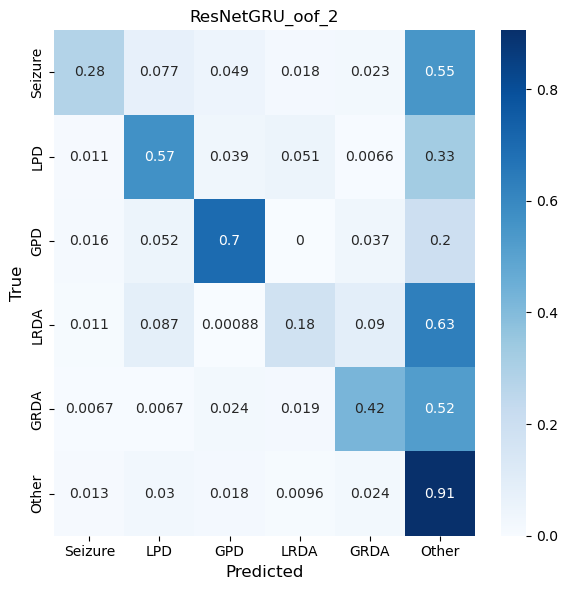

In [16]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()